# RTED-TDS Co-Sim

Authored by [Jinning Wang](https://scholar.google.com/citations?user=Wr7nQZAAAAAJ&hl=en&oi=ao), recently updated on 06/06/2022.

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented with an equation defined PI controller.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted2`` has attributes ``mdl`` which is a gurobipy model.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance
- ``sse`` EV aggregator

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, matplotlib, scipy

## Import case

In [1]:
%run -i 'cosim_import.py'

0.post4532+g3df883b
2.8.0


`caseH` is the start time [H] of the co-simulation, now 10 and 18 are supported.

In [2]:
caseH = 18
ict = False
ecc = True
agc= True

%run -i 'cosim_setup_andes.py'

EVA: ts=18[H], 50000 EVs, Total Q=434.54 MWh
Online 14477, Q=362.27 MWh, SoC=0.7435
Power(MW): Pt=-39.0266, Pc=-39.0266, Pd=-0.0
Ctrl: 0=7897; 1=6580; 
EVA: Load A from Aest.csv.
Working directory: "/Users/jinningwang/Documents/work/andes/jwang/notes"
> Loaded config from file "/Users/jinningwang/.andes/andes.rc"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 8 processes.


Saved generated pycode to "/Users/jinningwang/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.1847 seconds.
Parsing input file "/Users/jinningwang/Documents/work/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.0707 seconds.
System internal structure set up in 0.0271 seconds.


## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


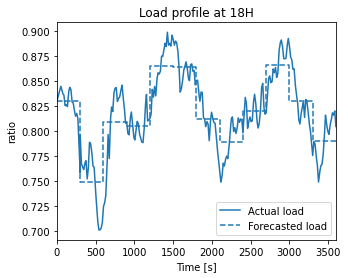

In [3]:
%run -i 'cosim_loadsyn.py'

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [4]:
%run -i 'cosim_setup_dispatch.py'
dc_comp.round(4)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0895 seconds.
0: |F(x)| = 9.601680411
1: |F(x)| = 3.497456408
2: |F(x)| = 0.1830766442
3: |F(x)| = 0.0007183028614
4: |F(x)| = 1.659288396e-08
Converged in 5 iterations in 0.0058 seconds.
Power flow results are consistent. Conversion is successful.


Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-08


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0039 seconds.
0: |F(x)| = 9.601680411
1: |F(x)| = 3.497456408
2: |F(x)| = 0.1830766442
3: |F(x)| = 0.0007183028614
4: |F(x)| = 1.659288396e-08
Converged in 5 iterations in 0.0045 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED limited: sfru, sfrd
RTED: total cost=4889.131


pp cost=2184.5741560778906, gb cost=4889.131241556355


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,970.0313,39.9756,15.8831,1.0,970.0312
1,646.0000,228.9208,2.2281,1.0,646.0000
2,290.0000,81.0987,-0.8653,1.0,290.0000
3,652.0000,114.2245,7.2985,1.0,652.0000
4,508.0000,137.9576,5.4672,1.0,508.0000
5,646.6875,212.0871,6.4196,1.0,646.6875
6,232.0000,55.2884,3.4379,1.0,232.0000
7,564.0000,-59.8950,13.9534,1.0,564.0000
8,865.0000,49.8766,18.9462,1.0,865.0000
9,30.0000,49.8766,18.9462,1.0,30.0000


## Prepare

### Make link table

In [5]:
%run -i 'cosim_linktable.py'
ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,rg_idx,rexc_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,False,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,False,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,False,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,False,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,False,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,False,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,False,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,False,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,False,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,False,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

In [6]:
# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 3600

rru, rrd, rsfr = 1.0, 1.0, 0.05

# Define functions and constants used in loop
%run -i 'cosim_const.py'

Check convergence

In [7]:
# %run -i 'cosim_bmain.py'

In [8]:
col = ['u', 'lc', 'c', 'soc', 'soc0', 'socd', 'c', 'sx', 'agc', 'na', 'nam']
sse.ev[sse.ev['lc'] == 1][col]

,u,lc,c,soc,soc0,socd,c,sx,agc,na,nam


Loop

In [9]:
%run -i 'cosim_main.py'

RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED is solved.
RTED: total cost=4703.44
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0050 seconds.
0: |F(x)| = 7.905038032
1: |F(x)| = 3.420738974
2: |F(x)| = 0.1795098528
3: |F(x)| = 0.001097695163
4: |F(x)| = 3.009338378e-08
Converged in 5 iterations in 0.0062 seconds.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initialization for 

nec= 14482
Pr= 6.816441838408418


Simulation to t=5.00 sec completed in 0.0369 seconds.
Simulation to t=6.00 sec completed in 0.0411 seconds.
Simulation to t=7.00 sec completed in 0.0356 seconds.
Simulation to t=8.00 sec completed in 0.0335 seconds.


nec= 14485
Pr= 8.377846519110426


Simulation to t=9.00 sec completed in 0.0346 seconds.
Simulation to t=10.00 sec completed in 0.0338 seconds.
Simulation to t=11.00 sec completed in 0.0374 seconds.
Simulation to t=12.00 sec completed in 0.0405 seconds.


nec= 14488
Pr= 12.98388297508768


Simulation to t=13.00 sec completed in 0.0413 seconds.
Simulation to t=14.00 sec completed in 0.0339 seconds.
Simulation to t=15.00 sec completed in 0.0354 seconds.
Simulation to t=16.00 sec completed in 0.0340 seconds.


nec= 14494
Pr= 16.047838555834876


Simulation to t=17.00 sec completed in 0.0310 seconds.
Simulation to t=18.00 sec completed in 0.0325 seconds.
Simulation to t=19.00 sec completed in 0.0379 seconds.
Simulation to t=20.00 sec completed in 0.0390 seconds.


nec= 14496
Pr= 19.857958511145156


Simulation to t=21.00 sec completed in 0.0345 seconds.
Simulation to t=22.00 sec completed in 0.0345 seconds.
Simulation to t=23.00 sec completed in 0.0333 seconds.
Simulation to t=24.00 sec completed in 0.0333 seconds.


nec= 14497
Pr= 23.20283601901119


Simulation to t=25.00 sec completed in 0.0573 seconds.
Simulation to t=26.00 sec completed in 0.0315 seconds.
Simulation to t=27.00 sec completed in 0.0326 seconds.
Simulation to t=28.00 sec completed in 0.0353 seconds.


nec= 14504
Pr= 26.903503779677884


Simulation to t=29.00 sec completed in 0.0331 seconds.
Simulation to t=30.00 sec completed in 0.0340 seconds.
Simulation to t=31.00 sec completed in 0.0326 seconds.
Simulation to t=32.00 sec completed in 0.0336 seconds.


nec= 14508
Pr= 30.2394504947391


Simulation to t=33.00 sec completed in 0.0365 seconds.
Simulation to t=34.00 sec completed in 0.0386 seconds.
Simulation to t=35.00 sec completed in 0.0356 seconds.
Simulation to t=36.00 sec completed in 0.0337 seconds.


nec= 14512
Pr= 33.85577007454506


Simulation to t=37.00 sec completed in 0.0346 seconds.
Simulation to t=38.00 sec completed in 0.0400 seconds.
Simulation to t=39.00 sec completed in 0.0436 seconds.
Simulation to t=40.00 sec completed in 0.0401 seconds.


nec= 14517
Pr= 35.86264737613174


Simulation to t=41.00 sec completed in 0.0379 seconds.
Simulation to t=42.00 sec completed in 0.0389 seconds.
Simulation to t=43.00 sec completed in 0.0372 seconds.
Simulation to t=44.00 sec completed in 0.0458 seconds.


nec= 14518
Pr= 39.94883170555605


Simulation to t=45.00 sec completed in 0.0396 seconds.
Simulation to t=46.00 sec completed in 0.0378 seconds.
Simulation to t=47.00 sec completed in 0.0358 seconds.
Simulation to t=48.00 sec completed in 0.0368 seconds.


nec= 14518
Pr= 43.41189318868805


Simulation to t=49.00 sec completed in 0.0413 seconds.
Simulation to t=50.00 sec completed in 0.0378 seconds.
Simulation to t=51.00 sec completed in 0.0411 seconds.
Simulation to t=52.00 sec completed in 0.0364 seconds.


nec= 14521
Pr= 46.844626190407546


Simulation to t=53.00 sec completed in 0.0361 seconds.
Simulation to t=54.00 sec completed in 0.0417 seconds.
Simulation to t=55.00 sec completed in 0.0356 seconds.
Simulation to t=56.00 sec completed in 0.0415 seconds.


nec= 14524
Pr= 46.030097647911546


Simulation to t=57.00 sec completed in 0.0372 seconds.
Simulation to t=58.00 sec completed in 0.0362 seconds.
Simulation to t=59.00 sec completed in 0.0357 seconds.
Simulation to t=60.00 sec completed in 0.0348 seconds.


nec= 14525
Pr= 45.54395943768168


Simulation to t=61.00 sec completed in 0.0378 seconds.
Simulation to t=62.00 sec completed in 0.0348 seconds.
Simulation to t=63.00 sec completed in 0.0365 seconds.
Simulation to t=64.00 sec completed in 0.0328 seconds.


nec= 14529
Pr= 43.46020203681382


Simulation to t=65.00 sec completed in 0.0372 seconds.
Simulation to t=66.00 sec completed in 0.0361 seconds.
Simulation to t=67.00 sec completed in 0.0434 seconds.
Simulation to t=68.00 sec completed in 0.0403 seconds.


nec= 14532
Pr= 41.271531773238294


Simulation to t=69.00 sec completed in 0.0413 seconds.
Simulation to t=70.00 sec completed in 0.0790 seconds.
Simulation to t=71.00 sec completed in 0.0400 seconds.
Simulation to t=72.00 sec completed in 0.0455 seconds.


nec= 14538
Pr= 38.41133294551861


Simulation to t=73.00 sec completed in 0.0411 seconds.
Simulation to t=74.00 sec completed in 0.0490 seconds.
Simulation to t=75.00 sec completed in 0.0540 seconds.
Simulation to t=76.00 sec completed in 0.0480 seconds.


nec= 14539
Pr= 35.354637316071745


Simulation to t=77.00 sec completed in 0.0451 seconds.
Simulation to t=78.00 sec completed in 0.0448 seconds.
Simulation to t=79.00 sec completed in 0.0414 seconds.
Simulation to t=80.00 sec completed in 0.0434 seconds.


nec= 14542
Pr= 34.53856806020038


Simulation to t=81.00 sec completed in 0.0375 seconds.
Simulation to t=82.00 sec completed in 0.0531 seconds.
Simulation to t=83.00 sec completed in 0.0435 seconds.
Simulation to t=84.00 sec completed in 0.0410 seconds.


nec= 14546
Pr= 32.141402987143884


Simulation to t=85.00 sec completed in 0.0440 seconds.
Simulation to t=86.00 sec completed in 0.0464 seconds.
Simulation to t=87.00 sec completed in 0.0472 seconds.
Simulation to t=88.00 sec completed in 0.0484 seconds.


nec= 14549
Pr= 30.568161488449974


Simulation to t=89.00 sec completed in 0.0535 seconds.
Simulation to t=90.00 sec completed in 0.0444 seconds.
Simulation to t=91.00 sec completed in 0.0442 seconds.
Simulation to t=92.00 sec completed in 0.0424 seconds.


nec= 14553
Pr= 28.455967788452313


Simulation to t=93.00 sec completed in 0.0432 seconds.
Simulation to t=94.00 sec completed in 0.0388 seconds.
Simulation to t=95.00 sec completed in 0.0478 seconds.


nec= 14557
Pr= 22.75878103924091


Simulation to t=96.00 sec completed in 0.0734 seconds.
Simulation to t=97.00 sec completed in 0.0506 seconds.
Simulation to t=98.00 sec completed in 0.0459 seconds.
Simulation to t=99.00 sec completed in 0.0484 seconds.
Simulation to t=100.00 sec completed in 0.0502 seconds.


nec= 14560
Pr= 17.116727683483738


Simulation to t=101.00 sec completed in 0.0458 seconds.
Simulation to t=102.00 sec completed in 0.0480 seconds.
Simulation to t=103.00 sec completed in 0.0588 seconds.
Simulation to t=104.00 sec completed in 0.0568 seconds.


nec= 14564
Pr= 10.1328931586002


Simulation to t=105.00 sec completed in 0.0519 seconds.
Simulation to t=106.00 sec completed in 0.0392 seconds.
Simulation to t=107.00 sec completed in 0.0408 seconds.


nec= 14568
Pr= 4.550481139376666


Simulation to t=108.00 sec completed in 0.0682 seconds.
Simulation to t=109.00 sec completed in 0.0557 seconds.
Simulation to t=110.00 sec completed in 0.1309 seconds.
Simulation to t=111.00 sec completed in 0.0508 seconds.


nec= 14570
Pr= 2.9081616559027745


Simulation to t=112.00 sec completed in 0.0501 seconds.
Simulation to t=113.00 sec completed in 0.0557 seconds.
Simulation to t=114.00 sec completed in 0.0431 seconds.
Simulation to t=115.00 sec completed in 0.0427 seconds.


nec= 14572
Pr= -0.15039082212834565
nec= 14572
Pr= 0.7900522444125091


Simulation to t=116.00 sec completed in 0.0533 seconds.
Simulation to t=117.00 sec completed in 0.0537 seconds.
Simulation to t=118.00 sec completed in 0.0529 seconds.
Simulation to t=119.00 sec completed in 0.0528 seconds.
Simulation to t=120.00 sec completed in 0.0476 seconds.
Simulation to t=121.00 sec completed in 0.0442 seconds.
Simulation to t=122.00 sec completed in 0.0476 seconds.
Simulation to t=123.00 sec completed in 0.0428 seconds.


nec= 14579
Pr= 0.08184775809516065


Simulation to t=124.00 sec completed in 0.0497 seconds.
Simulation to t=125.00 sec completed in 0.0512 seconds.
Simulation to t=126.00 sec completed in 0.0461 seconds.
Simulation to t=127.00 sec completed in 0.0466 seconds.


nec= 14581
Pr= -0.3043767529561747
nec= 14581
Pr= -0.22959329184237176


Simulation to t=128.00 sec completed in 0.0454 seconds.
Simulation to t=129.00 sec completed in 0.0412 seconds.
Simulation to t=130.00 sec completed in 0.0430 seconds.
Simulation to t=131.00 sec completed in 0.0428 seconds.


nec= 14582
Pr= -0.8248735267946069
nec= 14582
Pr= -0.5646413726477911


Simulation to t=132.00 sec completed in 0.0455 seconds.
Simulation to t=133.00 sec completed in 0.0429 seconds.
Simulation to t=134.00 sec completed in 0.0417 seconds.
Simulation to t=135.00 sec completed in 0.0410 seconds.


nec= 14588
Pr= -0.9838150007138298
nec= 14588
Pr= -0.9043468292821882


Simulation to t=136.00 sec completed in 0.0539 seconds.
Simulation to t=137.00 sec completed in 0.0480 seconds.
Simulation to t=138.00 sec completed in 0.0393 seconds.
Simulation to t=139.00 sec completed in 0.0423 seconds.
Simulation to t=140.00 sec completed in 0.0402 seconds.


nec= 14594
Pr= 0.20245131361187918


Simulation to t=141.00 sec completed in 0.0388 seconds.
Simulation to t=142.00 sec completed in 0.0412 seconds.
Simulation to t=143.00 sec completed in 0.0395 seconds.
Simulation to t=144.00 sec completed in 0.0386 seconds.


nec= 14595
Pr= 6.752231055334789


Simulation to t=145.00 sec completed in 0.0501 seconds.
Simulation to t=146.00 sec completed in 0.0471 seconds.
Simulation to t=147.00 sec completed in 0.0418 seconds.


nec= 14600
Pr= 14.353581291364854


Simulation to t=148.00 sec completed in 0.0454 seconds.
Simulation to t=149.00 sec completed in 0.0503 seconds.
Simulation to t=150.00 sec completed in 0.0406 seconds.
Simulation to t=151.00 sec completed in 0.0409 seconds.
Simulation to t=152.00 sec completed in 0.0539 seconds.


nec= 14603
Pr= 23.201308697166535


Simulation to t=153.00 sec completed in 0.0452 seconds.
Simulation to t=154.00 sec completed in 0.0383 seconds.
Simulation to t=155.00 sec completed in 0.0426 seconds.
Simulation to t=156.00 sec completed in 0.0459 seconds.


nec= 14609
Pr= 28.291256622044457


Simulation to t=157.00 sec completed in 0.0408 seconds.
Simulation to t=158.00 sec completed in 0.0406 seconds.
Simulation to t=159.00 sec completed in 0.0411 seconds.
Simulation to t=160.00 sec completed in 0.0405 seconds.


nec= 14618
Pr= 32.12008922537662


Simulation to t=161.00 sec completed in 0.0417 seconds.
Simulation to t=162.00 sec completed in 0.0384 seconds.
Simulation to t=163.00 sec completed in 0.0393 seconds.
Simulation to t=164.00 sec completed in 0.0448 seconds.


nec= 14622
Pr= 37.579801458180285


Simulation to t=165.00 sec completed in 0.0465 seconds.
Simulation to t=166.00 sec completed in 0.0393 seconds.
Simulation to t=167.00 sec completed in 0.0416 seconds.
Simulation to t=168.00 sec completed in 0.0388 seconds.


nec= 14625
Pr= 41.38460173377628


Simulation to t=169.00 sec completed in 0.0415 seconds.
Simulation to t=170.00 sec completed in 0.0386 seconds.
Simulation to t=171.00 sec completed in 0.0436 seconds.
Simulation to t=172.00 sec completed in 0.0385 seconds.


nec= 14627
Pr= 42.398460950021544


Simulation to t=173.00 sec completed in 0.0435 seconds.
Simulation to t=174.00 sec completed in 0.0508 seconds.
Simulation to t=175.00 sec completed in 0.0460 seconds.
Simulation to t=176.00 sec completed in 0.0391 seconds.


nec= 14628
Pr= 43.174432690600526


Simulation to t=177.00 sec completed in 0.0472 seconds.
Simulation to t=178.00 sec completed in 0.0459 seconds.
Simulation to t=179.00 sec completed in 0.0414 seconds.
Simulation to t=180.00 sec completed in 0.0489 seconds.


nec= 14632
Pr= 42.792870611711066


Simulation to t=181.00 sec completed in 0.0483 seconds.
Simulation to t=182.00 sec completed in 0.0402 seconds.
Simulation to t=183.00 sec completed in 0.0406 seconds.
Simulation to t=184.00 sec completed in 0.0458 seconds.


nec= 14634
Pr= 39.66230195323028


Simulation to t=185.00 sec completed in 0.0402 seconds.
Simulation to t=186.00 sec completed in 0.0399 seconds.
Simulation to t=187.00 sec completed in 0.0421 seconds.
Simulation to t=188.00 sec completed in 0.0437 seconds.


nec= 14638
Pr= 33.26490181215222


Simulation to t=189.00 sec completed in 0.0447 seconds.
Simulation to t=190.00 sec completed in 0.0397 seconds.
Simulation to t=191.00 sec completed in 0.0460 seconds.
Simulation to t=192.00 sec completed in 0.0460 seconds.


nec= 14641
Pr= 26.42725807294339


Simulation to t=193.00 sec completed in 0.0514 seconds.
Simulation to t=194.00 sec completed in 0.0439 seconds.
Simulation to t=195.00 sec completed in 0.0453 seconds.


nec= 14643
Pr= 18.07185013389508


Simulation to t=196.00 sec completed in 0.0549 seconds.
Simulation to t=197.00 sec completed in 0.0505 seconds.
Simulation to t=198.00 sec completed in 0.0395 seconds.
Simulation to t=199.00 sec completed in 0.0423 seconds.
Simulation to t=200.00 sec completed in 0.0395 seconds.


nec= 14648
Pr= 16.218560321033934


Simulation to t=201.00 sec completed in 0.0394 seconds.
Simulation to t=202.00 sec completed in 0.0383 seconds.
Simulation to t=203.00 sec completed in 0.0455 seconds.
Simulation to t=204.00 sec completed in 0.0387 seconds.


nec= 14648
Pr= 11.732081728685875


Simulation to t=205.00 sec completed in 0.0390 seconds.
Simulation to t=206.00 sec completed in 0.0391 seconds.
Simulation to t=207.00 sec completed in 0.0432 seconds.
Simulation to t=208.00 sec completed in 0.0434 seconds.


nec= 14653
Pr= 9.362603508808936


Simulation to t=209.00 sec completed in 0.0389 seconds.
Simulation to t=210.00 sec completed in 0.0410 seconds.
Simulation to t=211.00 sec completed in 0.0394 seconds.
Simulation to t=212.00 sec completed in 0.0468 seconds.


nec= 14654
Pr= 6.7723384479698066


Simulation to t=213.00 sec completed in 0.0446 seconds.
Simulation to t=214.00 sec completed in 0.0461 seconds.
Simulation to t=215.00 sec completed in 0.0392 seconds.
Simulation to t=216.00 sec completed in 0.0514 seconds.


nec= 14656
Pr= 2.1354909430608044


Simulation to t=217.00 sec completed in 0.0429 seconds.
Simulation to t=218.00 sec completed in 0.0406 seconds.
Simulation to t=219.00 sec completed in 0.0394 seconds.


nec= 14657
Pr= -0.5541233691144227
nec= 14657
Pr= -0.2842616938569674


Simulation to t=220.00 sec completed in 0.0386 seconds.
Simulation to t=221.00 sec completed in 0.0404 seconds.
Simulation to t=222.00 sec completed in 0.0440 seconds.
Simulation to t=223.00 sec completed in 0.0434 seconds.


nec= 14661
Pr= -2.59153799934293
nec= 14661
Pr= -1.5729040293078815


Simulation to t=224.00 sec completed in 0.0415 seconds.
Simulation to t=225.00 sec completed in 0.0392 seconds.
Simulation to t=226.00 sec completed in 0.0406 seconds.
Simulation to t=227.00 sec completed in 0.0408 seconds.


nec= 14665
Pr= -3.0765371752619237
nec= 14665
Pr= -2.8340744309082693


Simulation to t=228.00 sec completed in 0.0438 seconds.
Simulation to t=229.00 sec completed in 0.0448 seconds.
Simulation to t=230.00 sec completed in 0.0435 seconds.
Simulation to t=231.00 sec completed in 0.0407 seconds.


nec= 14669
Pr= -4.7680857114603405
nec= 14669
Pr= -3.9224504117339913


Simulation to t=232.00 sec completed in 0.0400 seconds.
Simulation to t=233.00 sec completed in 0.0404 seconds.
Simulation to t=234.00 sec completed in 0.0411 seconds.
Simulation to t=235.00 sec completed in 0.0406 seconds.


nec= 14670
Pr= -5.336334833761328
nec= 14670
Pr= -5.052243377374707


Simulation to t=236.00 sec completed in 0.0427 seconds.
Simulation to t=237.00 sec completed in 0.0401 seconds.
Simulation to t=238.00 sec completed in 0.0418 seconds.
Simulation to t=239.00 sec completed in 0.0443 seconds.


nec= 14674
Pr= -8.866123485405561
nec= 14674
Pr= -7.1012579857307365


Simulation to t=240.00 sec completed in 0.0441 seconds.
Simulation to t=241.00 sec completed in 0.0452 seconds.
Simulation to t=242.00 sec completed in 0.0410 seconds.
Simulation to t=243.00 sec completed in 0.0472 seconds.
Simulation to t=244.00 sec completed in 0.0429 seconds.


nec= 14679
Pr= -7.625702033846598


Simulation to t=245.00 sec completed in 0.0402 seconds.
Simulation to t=246.00 sec completed in 0.0395 seconds.
Simulation to t=247.00 sec completed in 0.0428 seconds.
Simulation to t=248.00 sec completed in 0.0413 seconds.


nec= 14686
Pr= -7.6679027329780025


Simulation to t=249.00 sec completed in 0.0404 seconds.
Simulation to t=250.00 sec completed in 0.0430 seconds.
Simulation to t=251.00 sec completed in 0.0402 seconds.
Simulation to t=252.00 sec completed in 0.0394 seconds.


nec= 14689
Pr= -7.604616020397608


Simulation to t=253.00 sec completed in 0.0414 seconds.
Simulation to t=254.00 sec completed in 0.0391 seconds.
Simulation to t=255.00 sec completed in 0.0393 seconds.
Simulation to t=256.00 sec completed in 0.0428 seconds.


nec= 14692
Pr= -7.3467012948337285


Simulation to t=257.00 sec completed in 0.0392 seconds.
Simulation to t=258.00 sec completed in 0.0398 seconds.
Simulation to t=259.00 sec completed in 0.0419 seconds.
Simulation to t=260.00 sec completed in 0.0410 seconds.


nec= 14698
Pr= -7.706405346795736


Simulation to t=261.00 sec completed in 0.0390 seconds.
Simulation to t=262.00 sec completed in 0.0369 seconds.
Simulation to t=263.00 sec completed in 0.0390 seconds.
Simulation to t=264.00 sec completed in 0.0371 seconds.


nec= 14701
Pr= -8.225440905274288


Simulation to t=265.00 sec completed in 0.0438 seconds.
Simulation to t=266.00 sec completed in 0.0432 seconds.
Simulation to t=267.00 sec completed in 0.0416 seconds.
Simulation to t=268.00 sec completed in 0.0385 seconds.


nec= 14703
Pr= -8.867788502568983


Simulation to t=269.00 sec completed in 0.0384 seconds.
Simulation to t=270.00 sec completed in 0.0564 seconds.
Simulation to t=271.00 sec completed in 0.0604 seconds.


nec= 14703
Pr= -10.63628615990132
nec= 14703
Pr= -9.779623416321892


Simulation to t=272.00 sec completed in 0.0466 seconds.
Simulation to t=273.00 sec completed in 0.0470 seconds.
Simulation to t=274.00 sec completed in 0.0464 seconds.
Simulation to t=275.00 sec completed in 0.0518 seconds.


nec= 14706
Pr= -15.210249405617859
nec= 14706
Pr= -12.92326778275959


Simulation to t=276.00 sec completed in 0.0575 seconds.
Simulation to t=277.00 sec completed in 0.0587 seconds.
Simulation to t=278.00 sec completed in 0.0557 seconds.
Simulation to t=279.00 sec completed in 0.0542 seconds.
Simulation to t=280.00 sec completed in 0.0534 seconds.


nec= 14710
Pr= -14.78450432219324


Simulation to t=281.00 sec completed in 0.0576 seconds.
Simulation to t=282.00 sec completed in 0.0584 seconds.
Simulation to t=283.00 sec completed in 0.0594 seconds.


nec= 14716
Pr= -22.37067782100272
nec= 14716
Pr= -18.80751125561445


Simulation to t=284.00 sec completed in 0.0641 seconds.
Simulation to t=285.00 sec completed in 0.0562 seconds.
Simulation to t=286.00 sec completed in 0.0571 seconds.
Simulation to t=287.00 sec completed in 0.0535 seconds.


nec= 14719
Pr= -24.1914979169503
nec= 14719
Pr= -23.10392950088802


Simulation to t=288.00 sec completed in 0.0572 seconds.
Simulation to t=289.00 sec completed in 0.0576 seconds.
Simulation to t=290.00 sec completed in 0.0671 seconds.
Simulation to t=291.00 sec completed in 0.0693 seconds.


nec= 14720
Pr= -32.37301204676246
nec= 14720
Pr= -27.798638421109082


Simulation to t=292.00 sec completed in 0.0582 seconds.
Simulation to t=293.00 sec completed in 0.0581 seconds.
Simulation to t=294.00 sec completed in 0.0559 seconds.
Simulation to t=295.00 sec completed in 0.0863 seconds.
Simulation to t=296.00 sec completed in 0.0652 seconds.
Simulation to t=297.00 sec completed in 0.0568 seconds.
Simulation to t=298.00 sec completed in 0.0569 seconds.
Simulation to t=299.00 sec completed in 0.0566 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4620.714


nec= 14730
Pr= 0.7746422002478681


Simulation to t=300.00 sec completed in 0.0810 seconds.
Simulation to t=301.00 sec completed in 0.0800 seconds.
Simulation to t=302.00 sec completed in 0.0714 seconds.
Simulation to t=303.00 sec completed in 0.0695 seconds.
Simulation to t=304.00 sec completed in 0.0621 seconds.
Simulation to t=305.00 sec completed in 0.0617 seconds.
Simulation to t=306.00 sec completed in 0.0676 seconds.
Simulation to t=307.00 sec completed in 0.0580 seconds.
Simulation to t=308.00 sec completed in 0.0613 seconds.
Simulation to t=309.00 sec completed in 0.0632 seconds.
Simulation to t=310.00 sec completed in 0.0579 seconds.
Simulation to t=311.00 sec completed in 0.0614 seconds.
Simulation to t=312.00 sec completed in 0.0556 seconds.
Simulation to t=313.00 sec completed in 0.0631 seconds.
Simulation to t=314.00 sec completed in 0.0583 seconds.
Simulation to t=315.00 sec completed in 0.0607 seconds.
Simulation to t=316.00 sec completed in 0.0543 seconds.
Simulation to t=317.00 sec completed in 0.0559 s

nec= 14740
Pr= -8.894016900740098e-08


Simulation to t=321.00 sec completed in 0.0706 seconds.
Simulation to t=322.00 sec completed in 0.0603 seconds.
Simulation to t=323.00 sec completed in 0.0608 seconds.
Simulation to t=324.00 sec completed in 0.0567 seconds.
Simulation to t=325.00 sec completed in 0.0589 seconds.
Simulation to t=326.00 sec completed in 0.0581 seconds.
Simulation to t=327.00 sec completed in 0.0530 seconds.
Simulation to t=328.00 sec completed in 0.0499 seconds.
Simulation to t=329.00 sec completed in 0.0547 seconds.
Simulation to t=330.00 sec completed in 0.0471 seconds.
Simulation to t=331.00 sec completed in 0.0461 seconds.
Simulation to t=332.00 sec completed in 0.0520 seconds.
Simulation to t=333.00 sec completed in 0.0573 seconds.
Simulation to t=334.00 sec completed in 0.0614 seconds.
Simulation to t=335.00 sec completed in 0.0593 seconds.
Simulation to t=336.00 sec completed in 0.0563 seconds.
Simulation to t=337.00 sec completed in 0.0563 seconds.
Simulation to t=338.00 sec completed in 0.0551 s

nec= 14762
Pr= 8.677911711313628


Simulation to t=353.00 sec completed in 0.0732 seconds.
Simulation to t=354.00 sec completed in 0.0665 seconds.
Simulation to t=355.00 sec completed in 0.0636 seconds.


nec= 14764
Pr= 20.774364505781598


Simulation to t=356.00 sec completed in 0.0663 seconds.
Simulation to t=357.00 sec completed in 0.0591 seconds.
Simulation to t=358.00 sec completed in 0.0579 seconds.
Simulation to t=359.00 sec completed in 0.0605 seconds.


nec= 14768
Pr= 32.73214584308668


Simulation to t=360.00 sec completed in 0.0598 seconds.
Simulation to t=361.00 sec completed in 0.0649 seconds.
Simulation to t=362.00 sec completed in 0.0777 seconds.
Simulation to t=363.00 sec completed in 0.0593 seconds.
Simulation to t=364.00 sec completed in 0.0563 seconds.


nec= 14771
Pr= 40.510528647329615


Simulation to t=365.00 sec completed in 0.0556 seconds.
Simulation to t=366.00 sec completed in 0.0559 seconds.
Simulation to t=367.00 sec completed in 0.0560 seconds.
Simulation to t=368.00 sec completed in 0.0576 seconds.


nec= 14771
Pr= 47.605042383918295


Simulation to t=369.00 sec completed in 0.0576 seconds.
Simulation to t=370.00 sec completed in 0.0581 seconds.
Simulation to t=371.00 sec completed in 0.0617 seconds.


nec= 14772
Pr= 51.80835600816814


Simulation to t=372.00 sec completed in 0.0581 seconds.
Simulation to t=373.00 sec completed in 0.0557 seconds.
Simulation to t=374.00 sec completed in 0.0537 seconds.
Simulation to t=375.00 sec completed in 0.0581 seconds.


nec= 14776
Pr= 57.26110475164262


Simulation to t=376.00 sec completed in 0.0622 seconds.
Simulation to t=377.00 sec completed in 0.0621 seconds.
Simulation to t=378.00 sec completed in 0.0926 seconds.
Simulation to t=379.00 sec completed in 0.0879 seconds.


nec= 14780
Pr= 49.22818741833728


Simulation to t=380.00 sec completed in 0.0753 seconds.
Simulation to t=381.00 sec completed in 0.0785 seconds.
Simulation to t=382.00 sec completed in 0.0850 seconds.
Simulation to t=383.00 sec completed in 0.0580 seconds.


nec= 14786
Pr= 40.02346743319239


Simulation to t=384.00 sec completed in 0.0753 seconds.
Simulation to t=385.00 sec completed in 0.0558 seconds.
Simulation to t=386.00 sec completed in 0.0676 seconds.
Simulation to t=387.00 sec completed in 0.0633 seconds.


nec= 14788
Pr= 26.003808069989464


Simulation to t=388.00 sec completed in 0.0735 seconds.
Simulation to t=389.00 sec completed in 0.0714 seconds.
Simulation to t=390.00 sec completed in 0.1003 seconds.
Simulation to t=391.00 sec completed in 0.0638 seconds.


nec= 14791
Pr= 12.404248549315213


Simulation to t=392.00 sec completed in 0.0690 seconds.
Simulation to t=393.00 sec completed in 0.0835 seconds.
Simulation to t=394.00 sec completed in 0.0626 seconds.
Simulation to t=395.00 sec completed in 0.0643 seconds.


nec= 14792
Pr= 15.027990178360946


Simulation to t=396.00 sec completed in 0.0737 seconds.
Simulation to t=397.00 sec completed in 0.0551 seconds.
Simulation to t=398.00 sec completed in 0.0748 seconds.
Simulation to t=399.00 sec completed in 0.0651 seconds.


nec= 14793
Pr= 14.514920798447806


Simulation to t=400.00 sec completed in 0.0693 seconds.
Simulation to t=401.00 sec completed in 0.0649 seconds.
Simulation to t=402.00 sec completed in 0.0732 seconds.
Simulation to t=403.00 sec completed in 0.0745 seconds.


nec= 14797
Pr= 21.654079367415513


Simulation to t=404.00 sec completed in 0.0637 seconds.
Simulation to t=405.00 sec completed in 0.0556 seconds.
Simulation to t=406.00 sec completed in 0.0640 seconds.
Simulation to t=407.00 sec completed in 0.0567 seconds.


nec= 14800
Pr= 30.094460430917145


Simulation to t=408.00 sec completed in 0.0767 seconds.
Simulation to t=409.00 sec completed in 0.0704 seconds.
Simulation to t=410.00 sec completed in 0.0669 seconds.
Simulation to t=411.00 sec completed in 0.0774 seconds.


nec= 14802
Pr= 50.65244706242806


Simulation to t=412.00 sec completed in 0.0620 seconds.
Simulation to t=413.00 sec completed in 0.0703 seconds.
Simulation to t=414.00 sec completed in 0.0742 seconds.
Simulation to t=415.00 sec completed in 0.0589 seconds.


nec= 14805
Pr= 69.6051805496176


Simulation to t=416.00 sec completed in 0.0676 seconds.
Simulation to t=417.00 sec completed in 0.0623 seconds.
Simulation to t=418.00 sec completed in 0.0649 seconds.
Simulation to t=419.00 sec completed in 0.0964 seconds.


nec= 14808
Pr= 92.30967233499048
nec= 14808
Pr= 94.68432006534655


Simulation to t=420.00 sec completed in 0.1053 seconds.
Simulation to t=421.00 sec completed in 0.0868 seconds.
Simulation to t=422.00 sec completed in 0.0961 seconds.
Simulation to t=423.00 sec completed in 0.0812 seconds.


nec= 14812
Pr= 104.7323274237183
nec= 14812
Pr= 109.15808173476364


Simulation to t=424.00 sec completed in 0.0631 seconds.
Simulation to t=425.00 sec completed in 0.0557 seconds.
Simulation to t=426.00 sec completed in 0.0672 seconds.
Simulation to t=427.00 sec completed in 0.0568 seconds.


nec= 14816
Pr= 116.98790861582812
nec= 14816
Pr= 117.21576246246845


Simulation to t=428.00 sec completed in 0.0925 seconds.
Simulation to t=429.00 sec completed in 0.0749 seconds.
Simulation to t=430.00 sec completed in 0.0731 seconds.
Simulation to t=431.00 sec completed in 0.0848 seconds.


nec= 14818
Pr= 117.47519011318573
nec= 14818
Pr= 117.73465278383428
nec= 14818
Pr= 117.99411545448282
nec= 14818
Pr= 118.25357812513137
nec= 14818
Pr= 118.51304079577992
nec= 14818
Pr= 118.77250346642846
nec= 14818
Pr= 119.031966137077
nec= 14818
Pr= 119.29142880772555
nec= 14818
Pr= 119.5508914783741
nec= 14818
Pr= 119.81035414902264


Simulation to t=432.00 sec completed in 0.0669 seconds.


nec= 14821
Pr= 120.06981681967119
nec= 14821
Pr= 120.32933202021661
nec= 14821
Pr= 120.58884722076203
nec= 14821
Pr= 120.84836242130746
nec= 14821
Pr= 121.10787762185288
nec= 14821
Pr= 121.3673928223983
nec= 14821
Pr= 121.62690802294372
nec= 14821
Pr= 121.88642322348915
nec= 14821
Pr= 122.14593842403457
nec= 14821
Pr= 122.40545362457999


Simulation to t=433.00 sec completed in 0.0860 seconds.


nec= 14822
Pr= 122.66496882512541
nec= 14822
Pr= 122.92450153563645
nec= 14822
Pr= 123.18403424614749
nec= 14822
Pr= 123.44356695665853
nec= 14822
Pr= 123.70309966716957
nec= 14822
Pr= 123.88804221699753


Simulation to t=434.00 sec completed in 0.0595 seconds.
Simulation to t=435.00 sec completed in 0.0547 seconds.


nec= 14824
Pr= 124.14757492750857
nec= 14824
Pr= 124.40714265795087
nec= 14824
Pr= 124.66671038839317
nec= 14824
Pr= 124.80125955427482
nec= 14824
Pr= 124.80125955427482


Simulation to t=436.00 sec completed in 0.0999 seconds.


nec= 14823
Pr= 124.80125955427482


Simulation to t=437.00 sec completed in 0.0560 seconds.


nec= 14823
Pr= 124.80125955427482


Simulation to t=438.00 sec completed in 0.0704 seconds.


nec= 14824
Pr= 124.80125955427482


Simulation to t=439.00 sec completed in 0.0448 seconds.


nec= 14824
Pr= 124.80125955427482


Simulation to t=440.00 sec completed in 0.0591 seconds.


nec= 14825
Pr= 124.9062226260238
nec= 14825
Pr= 124.90622970664117


Simulation to t=441.00 sec completed in 0.0654 seconds.
Simulation to t=442.00 sec completed in 0.0432 seconds.


nec= 14825
Pr= 124.90623678725854
nec= 14828
Pr= 124.9062438678759


Simulation to t=443.00 sec completed in 0.0629 seconds.


nec= 14829
Pr= 122.42825515477168


Simulation to t=444.00 sec completed in 0.0808 seconds.
Simulation to t=445.00 sec completed in 0.0756 seconds.
Simulation to t=446.00 sec completed in 0.0546 seconds.
Simulation to t=447.00 sec completed in 0.0500 seconds.


nec= 14830
Pr= 116.43742740692781


Simulation to t=448.00 sec completed in 0.0892 seconds.
Simulation to t=449.00 sec completed in 0.0699 seconds.
Simulation to t=450.00 sec completed in 0.0663 seconds.
Simulation to t=451.00 sec completed in 0.0608 seconds.


nec= 14836
Pr= 109.50375829610869


Simulation to t=452.00 sec completed in 0.0983 seconds.
Simulation to t=453.00 sec completed in 0.0733 seconds.
Simulation to t=454.00 sec completed in 0.0626 seconds.
Simulation to t=455.00 sec completed in 0.0691 seconds.


nec= 14839
Pr= 97.85568081765337


Simulation to t=456.00 sec completed in 0.0659 seconds.
Simulation to t=457.00 sec completed in 0.0645 seconds.
Simulation to t=458.00 sec completed in 0.0698 seconds.
Simulation to t=459.00 sec completed in 0.0851 seconds.


nec= 14843
Pr= 86.25333967868994


Simulation to t=460.00 sec completed in 0.0805 seconds.
Simulation to t=461.00 sec completed in 0.0741 seconds.
Simulation to t=462.00 sec completed in 0.0704 seconds.
Simulation to t=463.00 sec completed in 0.0604 seconds.


nec= 14847
Pr= 72.61764155899


Simulation to t=464.00 sec completed in 0.0705 seconds.
Simulation to t=465.00 sec completed in 0.0707 seconds.
Simulation to t=466.00 sec completed in 0.0577 seconds.
Simulation to t=467.00 sec completed in 0.0883 seconds.


nec= 14850
Pr= 60.89662424626394


Simulation to t=468.00 sec completed in 0.0671 seconds.
Simulation to t=469.00 sec completed in 0.0645 seconds.
Simulation to t=470.00 sec completed in 0.0650 seconds.
Simulation to t=471.00 sec completed in 0.0712 seconds.


nec= 14852
Pr= 55.9248168848918


Simulation to t=472.00 sec completed in 0.0707 seconds.
Simulation to t=473.00 sec completed in 0.0766 seconds.
Simulation to t=474.00 sec completed in 0.0849 seconds.
Simulation to t=475.00 sec completed in 0.0637 seconds.


nec= 14854
Pr= 49.63365312571485


Simulation to t=476.00 sec completed in 0.1068 seconds.
Simulation to t=477.00 sec completed in 0.0611 seconds.
Simulation to t=478.00 sec completed in 0.0847 seconds.
Simulation to t=479.00 sec completed in 0.0731 seconds.


nec= 14855
Pr= 46.141518602324844


Simulation to t=480.00 sec completed in 0.0796 seconds.
Simulation to t=481.00 sec completed in 0.0983 seconds.
Simulation to t=482.00 sec completed in 0.0943 seconds.
Simulation to t=483.00 sec completed in 0.0664 seconds.


nec= 14862
Pr= 35.56647320051869
nec= 14862
Pr= 36.90839034082019


Simulation to t=484.00 sec completed in 0.1241 seconds.
Simulation to t=485.00 sec completed in 0.0731 seconds.
Simulation to t=486.00 sec completed in 0.0703 seconds.
Simulation to t=487.00 sec completed in 0.0584 seconds.


nec= 14864
Pr= 18.289238345663165
nec= 14864
Pr= 22.012100727768583


Simulation to t=488.00 sec completed in 0.0730 seconds.
Simulation to t=489.00 sec completed in 0.0935 seconds.
Simulation to t=490.00 sec completed in 0.0773 seconds.
Simulation to t=491.00 sec completed in 0.0681 seconds.


nec= 14866
Pr= 2.8275406903847085
nec= 14866
Pr= 6.416676165085021


Simulation to t=492.00 sec completed in 0.0641 seconds.
Simulation to t=493.00 sec completed in 0.0712 seconds.
Simulation to t=494.00 sec completed in 0.0842 seconds.
Simulation to t=495.00 sec completed in 0.0950 seconds.


nec= 14869
Pr= -2.827039920545789
nec= 14869
Pr= -8.894016945149019e-08


Simulation to t=496.00 sec completed in 0.1035 seconds.
Simulation to t=497.00 sec completed in 0.0837 seconds.
Simulation to t=498.00 sec completed in 0.0915 seconds.
Simulation to t=499.00 sec completed in 0.0815 seconds.
Simulation to t=500.00 sec completed in 0.1316 seconds.
Simulation to t=501.00 sec completed in 0.0670 seconds.
Simulation to t=502.00 sec completed in 0.1167 seconds.
Simulation to t=503.00 sec completed in 0.1122 seconds.
Simulation to t=504.00 sec completed in 0.1141 seconds.
Simulation to t=505.00 sec completed in 0.0933 seconds.
Simulation to t=506.00 sec completed in 0.1242 seconds.
Simulation to t=507.00 sec completed in 0.0968 seconds.
Simulation to t=508.00 sec completed in 0.0828 seconds.
Simulation to t=509.00 sec completed in 0.0993 seconds.
Simulation to t=510.00 sec completed in 0.0909 seconds.
Simulation to t=511.00 sec completed in 0.0732 seconds.
Simulation to t=512.00 sec completed in 0.0907 seconds.
Simulation to t=513.00 sec completed in 0.0900 s

nec= 14965
Pr= -40.91030144412603
nec= 14965
Pr= -31.004091763155508


Simulation to t=600.00 sec completed in 0.0770 seconds.
Simulation to t=601.00 sec completed in 0.0722 seconds.
Simulation to t=602.00 sec completed in 0.0708 seconds.
Simulation to t=603.00 sec completed in 0.0731 seconds.
Simulation to t=604.00 sec completed in 0.0739 seconds.
Simulation to t=605.00 sec completed in 0.0743 seconds.
Simulation to t=606.00 sec completed in 0.0426 seconds.
Simulation to t=607.00 sec completed in 0.0448 seconds.
Simulation to t=608.00 sec completed in 0.0426 seconds.
Simulation to t=609.00 sec completed in 0.0465 seconds.
Simulation to t=610.00 sec completed in 0.0408 seconds.
Simulation to t=611.00 sec completed in 0.0452 seconds.
Simulation to t=612.00 sec completed in 0.0504 seconds.
Simulation to t=613.00 sec completed in 0.0613 seconds.
Simulation to t=614.00 sec completed in 0.0528 seconds.
Simulation to t=615.00 sec completed in 0.0455 seconds.
Simulation to t=616.00 sec completed in 0.0589 seconds.
Simulation to t=617.00 sec completed in 0.0445 s

nec= 14992
Pr= -30.92715876233899


Simulation to t=640.00 sec completed in 0.0634 seconds.
Simulation to t=641.00 sec completed in 0.0641 seconds.
Simulation to t=642.00 sec completed in 0.0804 seconds.
Simulation to t=643.00 sec completed in 0.0514 seconds.
Simulation to t=644.00 sec completed in 0.0599 seconds.
Simulation to t=645.00 sec completed in 0.1018 seconds.
Simulation to t=646.00 sec completed in 0.0663 seconds.
Simulation to t=647.00 sec completed in 0.0583 seconds.
Simulation to t=648.00 sec completed in 0.0585 seconds.
Simulation to t=649.00 sec completed in 0.0560 seconds.
Simulation to t=650.00 sec completed in 0.0627 seconds.
Simulation to t=651.00 sec completed in 0.0889 seconds.
Simulation to t=652.00 sec completed in 0.0758 seconds.
Simulation to t=653.00 sec completed in 0.0706 seconds.
Simulation to t=654.00 sec completed in 0.0667 seconds.
Simulation to t=655.00 sec completed in 0.0749 seconds.
Simulation to t=656.00 sec completed in 0.0754 seconds.
Simulation to t=657.00 sec completed in 0.0837 s

nec= 15021
Pr= -30.794495880473747


Simulation to t=680.00 sec completed in 0.0715 seconds.
Simulation to t=681.00 sec completed in 0.0622 seconds.
Simulation to t=682.00 sec completed in 0.0673 seconds.
Simulation to t=683.00 sec completed in 0.0656 seconds.
Simulation to t=684.00 sec completed in 0.0651 seconds.
Simulation to t=685.00 sec completed in 0.0628 seconds.
Simulation to t=686.00 sec completed in 0.0676 seconds.
Simulation to t=687.00 sec completed in 0.0657 seconds.
Simulation to t=688.00 sec completed in 0.0667 seconds.
Simulation to t=689.00 sec completed in 0.0680 seconds.
Simulation to t=690.00 sec completed in 0.0764 seconds.
Simulation to t=691.00 sec completed in 0.0478 seconds.
Simulation to t=692.00 sec completed in 0.0534 seconds.
Simulation to t=693.00 sec completed in 0.0415 seconds.
Simulation to t=694.00 sec completed in 0.0414 seconds.
Simulation to t=695.00 sec completed in 0.0426 seconds.
Simulation to t=696.00 sec completed in 0.0547 seconds.


nec= 15031
Pr= -24.457360935633954


Simulation to t=697.00 sec completed in 0.0467 seconds.
Simulation to t=698.00 sec completed in 0.0418 seconds.
Simulation to t=699.00 sec completed in 0.0471 seconds.
Simulation to t=700.00 sec completed in 0.0581 seconds.


nec= 15034
Pr= -12.404946240180493


Simulation to t=701.00 sec completed in 0.0641 seconds.
Simulation to t=702.00 sec completed in 0.0602 seconds.
Simulation to t=703.00 sec completed in 0.0551 seconds.


nec= 15039
Pr= -4.588110966398323


Simulation to t=704.00 sec completed in 0.0652 seconds.
Simulation to t=705.00 sec completed in 0.0699 seconds.
Simulation to t=706.00 sec completed in 0.0718 seconds.
Simulation to t=707.00 sec completed in 0.0667 seconds.


nec= 15043
Pr= 4.503939217330077


Simulation to t=708.00 sec completed in 0.0477 seconds.
Simulation to t=709.00 sec completed in 0.0435 seconds.
Simulation to t=710.00 sec completed in 0.0467 seconds.
Simulation to t=711.00 sec completed in 0.0427 seconds.


nec= 15049
Pr= 14.810365053679007


Simulation to t=712.00 sec completed in 0.0476 seconds.
Simulation to t=713.00 sec completed in 0.0461 seconds.
Simulation to t=714.00 sec completed in 0.0425 seconds.
Simulation to t=715.00 sec completed in 0.0412 seconds.


nec= 15055
Pr= 21.369297645380716


Simulation to t=716.00 sec completed in 0.0439 seconds.
Simulation to t=717.00 sec completed in 0.0437 seconds.
Simulation to t=718.00 sec completed in 0.0400 seconds.
Simulation to t=719.00 sec completed in 0.0421 seconds.
Simulation to t=720.00 sec completed in 0.0472 seconds.


nec= 15057
Pr= 21.547243887010275


Simulation to t=721.00 sec completed in 0.0470 seconds.
Simulation to t=722.00 sec completed in 0.0452 seconds.
Simulation to t=723.00 sec completed in 0.0454 seconds.


nec= 15060
Pr= 29.4346122408667


Simulation to t=724.00 sec completed in 0.0899 seconds.
Simulation to t=725.00 sec completed in 0.0614 seconds.
Simulation to t=726.00 sec completed in 0.0617 seconds.
Simulation to t=727.00 sec completed in 0.0450 seconds.


nec= 15062
Pr= 41.300506990477324


Simulation to t=728.00 sec completed in 0.1012 seconds.
Simulation to t=729.00 sec completed in 0.0670 seconds.
Simulation to t=730.00 sec completed in 0.0636 seconds.
Simulation to t=731.00 sec completed in 0.0613 seconds.


nec= 15067
Pr= 52.7034758057312


Simulation to t=732.00 sec completed in 0.0583 seconds.
Simulation to t=733.00 sec completed in 0.0599 seconds.
Simulation to t=734.00 sec completed in 0.0543 seconds.
Simulation to t=735.00 sec completed in 0.0600 seconds.


nec= 15072
Pr= 67.01535991838531


Simulation to t=736.00 sec completed in 0.0628 seconds.
Simulation to t=737.00 sec completed in 0.0587 seconds.
Simulation to t=738.00 sec completed in 0.0620 seconds.
Simulation to t=739.00 sec completed in 0.0595 seconds.


nec= 15077
Pr= 74.81647524275434


Simulation to t=740.00 sec completed in 0.0618 seconds.
Simulation to t=741.00 sec completed in 0.0670 seconds.
Simulation to t=742.00 sec completed in 0.0545 seconds.
Simulation to t=743.00 sec completed in 0.0557 seconds.


nec= 15080
Pr= 83.04768413627849


Simulation to t=744.00 sec completed in 0.0954 seconds.
Simulation to t=745.00 sec completed in 0.0593 seconds.
Simulation to t=746.00 sec completed in 0.0566 seconds.
Simulation to t=747.00 sec completed in 0.0535 seconds.


nec= 15083
Pr= 89.20000784511495


Simulation to t=748.00 sec completed in 0.0763 seconds.
Simulation to t=749.00 sec completed in 0.0610 seconds.
Simulation to t=750.00 sec completed in 0.0533 seconds.
Simulation to t=751.00 sec completed in 0.0543 seconds.


nec= 15083
Pr= 94.9915184460333


Simulation to t=752.00 sec completed in 0.0645 seconds.
Simulation to t=753.00 sec completed in 0.0527 seconds.
Simulation to t=754.00 sec completed in 0.0572 seconds.
Simulation to t=755.00 sec completed in 0.0500 seconds.


nec= 15089
Pr= 98.04056946018778


Simulation to t=756.00 sec completed in 0.0709 seconds.
Simulation to t=757.00 sec completed in 0.0489 seconds.
Simulation to t=758.00 sec completed in 0.0599 seconds.
Simulation to t=759.00 sec completed in 0.0472 seconds.


nec= 15094
Pr= 102.69053341692783


Simulation to t=760.00 sec completed in 0.0591 seconds.
Simulation to t=761.00 sec completed in 0.0474 seconds.
Simulation to t=762.00 sec completed in 0.0520 seconds.
Simulation to t=763.00 sec completed in 0.0505 seconds.
Simulation to t=764.00 sec completed in 0.0410 seconds.


nec= 15096
Pr= 103.6957146786935


Simulation to t=765.00 sec completed in 0.0461 seconds.
Simulation to t=766.00 sec completed in 0.0494 seconds.
Simulation to t=767.00 sec completed in 0.0499 seconds.


nec= 15100
Pr= 103.47004151031193


Simulation to t=768.00 sec completed in 0.0613 seconds.
Simulation to t=769.00 sec completed in 0.0490 seconds.
Simulation to t=770.00 sec completed in 0.0486 seconds.
Simulation to t=771.00 sec completed in 0.0519 seconds.


nec= 15102
Pr= 96.34476415643118


Simulation to t=772.00 sec completed in 0.0702 seconds.
Simulation to t=773.00 sec completed in 0.0639 seconds.
Simulation to t=774.00 sec completed in 0.0628 seconds.
Simulation to t=775.00 sec completed in 0.0599 seconds.


nec= 15104
Pr= 89.9027512026962


Simulation to t=776.00 sec completed in 0.0689 seconds.
Simulation to t=777.00 sec completed in 0.0602 seconds.
Simulation to t=778.00 sec completed in 0.0448 seconds.
Simulation to t=779.00 sec completed in 0.0519 seconds.
Simulation to t=780.00 sec completed in 0.0450 seconds.


nec= 15105
Pr= 80.50316344622124


Simulation to t=781.00 sec completed in 0.0499 seconds.
Simulation to t=782.00 sec completed in 0.0515 seconds.
Simulation to t=783.00 sec completed in 0.0442 seconds.
Simulation to t=784.00 sec completed in 0.0477 seconds.


nec= 15109
Pr= 75.4811696358435


Simulation to t=785.00 sec completed in 0.0456 seconds.
Simulation to t=786.00 sec completed in 0.0432 seconds.
Simulation to t=787.00 sec completed in 0.0442 seconds.
Simulation to t=788.00 sec completed in 0.0447 seconds.


nec= 15112
Pr= 73.91315410198389


Simulation to t=789.00 sec completed in 0.0452 seconds.
Simulation to t=790.00 sec completed in 0.0497 seconds.
Simulation to t=791.00 sec completed in 0.0469 seconds.
Simulation to t=792.00 sec completed in 0.0439 seconds.


nec= 15115
Pr= 72.81213209203838


Simulation to t=793.00 sec completed in 0.0456 seconds.
Simulation to t=794.00 sec completed in 0.0454 seconds.
Simulation to t=795.00 sec completed in 0.0455 seconds.
Simulation to t=796.00 sec completed in 0.0465 seconds.


nec= 15120
Pr= 73.503548111536


Simulation to t=797.00 sec completed in 0.0472 seconds.
Simulation to t=798.00 sec completed in 0.0456 seconds.
Simulation to t=799.00 sec completed in 0.0446 seconds.
Simulation to t=800.00 sec completed in 0.0460 seconds.


nec= 15123
Pr= 72.43218240377375


Simulation to t=801.00 sec completed in 0.0531 seconds.
Simulation to t=802.00 sec completed in 0.0458 seconds.
Simulation to t=803.00 sec completed in 0.0440 seconds.
Simulation to t=804.00 sec completed in 0.0503 seconds.


nec= 15124
Pr= 73.92027802088299


Simulation to t=805.00 sec completed in 0.0471 seconds.
Simulation to t=806.00 sec completed in 0.0413 seconds.
Simulation to t=807.00 sec completed in 0.0512 seconds.
Simulation to t=808.00 sec completed in 0.0400 seconds.


nec= 15129
Pr= 74.85055995613591


Simulation to t=809.00 sec completed in 0.0407 seconds.
Simulation to t=810.00 sec completed in 0.0486 seconds.
Simulation to t=811.00 sec completed in 0.0481 seconds.
Simulation to t=812.00 sec completed in 0.0409 seconds.


nec= 15132
Pr= 76.44912671924307


Simulation to t=813.00 sec completed in 0.0483 seconds.
Simulation to t=814.00 sec completed in 0.0481 seconds.
Simulation to t=815.00 sec completed in 0.0464 seconds.
Simulation to t=816.00 sec completed in 0.0461 seconds.


nec= 15137
Pr= 80.14966285600482


Simulation to t=817.00 sec completed in 0.0472 seconds.
Simulation to t=818.00 sec completed in 0.0497 seconds.
Simulation to t=819.00 sec completed in 0.0467 seconds.


nec= 15139
Pr= 83.88657893721783


Simulation to t=820.00 sec completed in 0.0463 seconds.
Simulation to t=821.00 sec completed in 0.0485 seconds.
Simulation to t=822.00 sec completed in 0.0495 seconds.
Simulation to t=823.00 sec completed in 0.0410 seconds.
Simulation to t=824.00 sec completed in 0.0535 seconds.


nec= 15141
Pr= 88.39456921776453


Simulation to t=825.00 sec completed in 0.0494 seconds.
Simulation to t=826.00 sec completed in 0.0473 seconds.
Simulation to t=827.00 sec completed in 0.0596 seconds.


nec= 15145
Pr= 92.90687943999171


Simulation to t=828.00 sec completed in 0.0540 seconds.
Simulation to t=829.00 sec completed in 0.0503 seconds.
Simulation to t=830.00 sec completed in 0.0462 seconds.
Simulation to t=831.00 sec completed in 0.0502 seconds.


nec= 15147
Pr= 97.18278132523061


Simulation to t=832.00 sec completed in 0.0495 seconds.
Simulation to t=833.00 sec completed in 0.0547 seconds.
Simulation to t=834.00 sec completed in 0.0578 seconds.
Simulation to t=835.00 sec completed in 0.0429 seconds.


nec= 15153
Pr= 101.56479847483413


Simulation to t=836.00 sec completed in 0.0595 seconds.
Simulation to t=837.00 sec completed in 0.0505 seconds.
Simulation to t=838.00 sec completed in 0.0465 seconds.
Simulation to t=839.00 sec completed in 0.0461 seconds.


nec= 15158
Pr= 106.83610712177712


Simulation to t=840.00 sec completed in 0.0626 seconds.
Simulation to t=841.00 sec completed in 0.0506 seconds.
Simulation to t=842.00 sec completed in 0.0505 seconds.
Simulation to t=843.00 sec completed in 0.0481 seconds.


nec= 15163
Pr= 106.16902381578872


Simulation to t=844.00 sec completed in 0.0465 seconds.
Simulation to t=845.00 sec completed in 0.0479 seconds.
Simulation to t=846.00 sec completed in 0.0477 seconds.
Simulation to t=847.00 sec completed in 0.0467 seconds.


nec= 15165
Pr= 100.83265987134965


Simulation to t=848.00 sec completed in 0.0455 seconds.
Simulation to t=849.00 sec completed in 0.0487 seconds.
Simulation to t=850.00 sec completed in 0.0467 seconds.
Simulation to t=851.00 sec completed in 0.0470 seconds.
Simulation to t=852.00 sec completed in 0.0445 seconds.


nec= 15172
Pr= 94.75617475402122


Simulation to t=853.00 sec completed in 0.0425 seconds.
Simulation to t=854.00 sec completed in 0.0457 seconds.
Simulation to t=855.00 sec completed in 0.0476 seconds.
Simulation to t=856.00 sec completed in 0.0409 seconds.


nec= 15178
Pr= 86.32423092359058


Simulation to t=857.00 sec completed in 0.0451 seconds.
Simulation to t=858.00 sec completed in 0.0448 seconds.
Simulation to t=859.00 sec completed in 0.0421 seconds.


nec= 15183
Pr= 78.98008964456761


Simulation to t=860.00 sec completed in 0.0442 seconds.
Simulation to t=861.00 sec completed in 0.0434 seconds.
Simulation to t=862.00 sec completed in 0.0442 seconds.
Simulation to t=863.00 sec completed in 0.0468 seconds.


nec= 15189
Pr= 70.85354797532099


Simulation to t=864.00 sec completed in 0.0555 seconds.
Simulation to t=865.00 sec completed in 0.0516 seconds.
Simulation to t=866.00 sec completed in 0.0488 seconds.
Simulation to t=867.00 sec completed in 0.0496 seconds.


nec= 15192
Pr= 62.90437489130325


Simulation to t=868.00 sec completed in 0.0560 seconds.
Simulation to t=869.00 sec completed in 0.0420 seconds.
Simulation to t=870.00 sec completed in 0.0460 seconds.
Simulation to t=871.00 sec completed in 0.0462 seconds.


nec= 15195
Pr= 54.57658614659551


Simulation to t=872.00 sec completed in 0.0596 seconds.
Simulation to t=873.00 sec completed in 0.0460 seconds.
Simulation to t=874.00 sec completed in 0.0508 seconds.
Simulation to t=875.00 sec completed in 0.0569 seconds.


nec= 15200
Pr= 43.78057523258848


Simulation to t=876.00 sec completed in 0.0672 seconds.
Simulation to t=877.00 sec completed in 0.0583 seconds.
Simulation to t=878.00 sec completed in 0.0596 seconds.
Simulation to t=879.00 sec completed in 0.0508 seconds.


nec= 15204
Pr= 34.066577726259396


Simulation to t=880.00 sec completed in 0.0623 seconds.
Simulation to t=881.00 sec completed in 0.0557 seconds.
Simulation to t=882.00 sec completed in 0.0594 seconds.
Simulation to t=883.00 sec completed in 0.0588 seconds.


nec= 15204
Pr= 18.195208046997227
nec= 15204
Pr= 22.11966067405658


Simulation to t=884.00 sec completed in 0.0751 seconds.
Simulation to t=885.00 sec completed in 0.0872 seconds.
Simulation to t=886.00 sec completed in 0.0675 seconds.
Simulation to t=887.00 sec completed in 0.0622 seconds.


nec= 15208
Pr= 8.394551129939734
nec= 15208
Pr= 12.290872156445706


Simulation to t=888.00 sec completed in 0.0625 seconds.
Simulation to t=889.00 sec completed in 0.0577 seconds.
Simulation to t=890.00 sec completed in 0.0561 seconds.
Simulation to t=891.00 sec completed in 0.0526 seconds.


nec= 15212
Pr= 8.328990479004467
nec= 15212
Pr= 8.361254564978934


Simulation to t=892.00 sec completed in 0.0618 seconds.
Simulation to t=893.00 sec completed in 0.0479 seconds.
Simulation to t=894.00 sec completed in 0.0561 seconds.
Simulation to t=895.00 sec completed in 0.0475 seconds.


nec= 15215
Pr= 0.556260799723888
nec= 15215
Pr= 4.0719747522239595


Simulation to t=896.00 sec completed in 0.0628 seconds.
Simulation to t=897.00 sec completed in 0.0475 seconds.
Simulation to t=898.00 sec completed in 0.0466 seconds.
Simulation to t=899.00 sec completed in 0.0456 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4676.252
Simulation to t=900.00 sec completed in 0.0550 seconds.


nec= 15221
Pr= 2.0622748160951376


Simulation to t=901.00 sec completed in 0.0490 seconds.
Simulation to t=902.00 sec completed in 0.0557 seconds.
Simulation to t=903.00 sec completed in 0.0531 seconds.


nec= 15222
Pr= -2.1779641769890175
nec= 15222
Pr= -0.8115481792765948


Simulation to t=904.00 sec completed in 0.0617 seconds.
Simulation to t=905.00 sec completed in 0.0583 seconds.
Simulation to t=906.00 sec completed in 0.0609 seconds.
Simulation to t=907.00 sec completed in 0.0525 seconds.


nec= 15224
Pr= -2.6484020792729557
nec= 15224
Pr= -2.413232645475368


Simulation to t=908.00 sec completed in 0.0583 seconds.
Simulation to t=909.00 sec completed in 0.0512 seconds.
Simulation to t=910.00 sec completed in 0.0537 seconds.
Simulation to t=911.00 sec completed in 0.0511 seconds.


nec= 15228
Pr= -5.4884457647986205
nec= 15228
Pr= -4.068513694406857


Simulation to t=912.00 sec completed in 0.0524 seconds.
Simulation to t=913.00 sec completed in 0.0500 seconds.
Simulation to t=914.00 sec completed in 0.0553 seconds.
Simulation to t=915.00 sec completed in 0.0470 seconds.


nec= 15230
Pr= -6.346970541925732
nec= 15230
Pr= -5.917739071514901


Simulation to t=916.00 sec completed in 0.0619 seconds.
Simulation to t=917.00 sec completed in 0.0449 seconds.
Simulation to t=918.00 sec completed in 0.0532 seconds.
Simulation to t=919.00 sec completed in 0.0521 seconds.


nec= 15234
Pr= -6.228860115052113


Simulation to t=920.00 sec completed in 0.0556 seconds.
Simulation to t=921.00 sec completed in 0.0497 seconds.
Simulation to t=922.00 sec completed in 0.0553 seconds.
Simulation to t=923.00 sec completed in 0.0521 seconds.


nec= 15237
Pr= -7.431727720932902
nec= 15237
Pr= -6.878841656163369


Simulation to t=924.00 sec completed in 0.0518 seconds.
Simulation to t=925.00 sec completed in 0.0521 seconds.
Simulation to t=926.00 sec completed in 0.0476 seconds.
Simulation to t=927.00 sec completed in 0.0484 seconds.


nec= 15239
Pr= -7.24825315638739


Simulation to t=928.00 sec completed in 0.0651 seconds.
Simulation to t=929.00 sec completed in 0.0531 seconds.
Simulation to t=930.00 sec completed in 0.0447 seconds.
Simulation to t=931.00 sec completed in 0.0517 seconds.


nec= 15243
Pr= -7.305862423177517


Simulation to t=932.00 sec completed in 0.0489 seconds.
Simulation to t=933.00 sec completed in 0.0492 seconds.
Simulation to t=934.00 sec completed in 0.0459 seconds.
Simulation to t=935.00 sec completed in 0.0456 seconds.
Simulation to t=936.00 sec completed in 0.0587 seconds.


nec= 15248
Pr= -5.095718714415818


Simulation to t=937.00 sec completed in 0.0519 seconds.
Simulation to t=938.00 sec completed in 0.0589 seconds.
Simulation to t=939.00 sec completed in 0.0576 seconds.
Simulation to t=940.00 sec completed in 0.0458 seconds.


nec= 15250
Pr= -2.739783444599446


Simulation to t=941.00 sec completed in 0.0420 seconds.
Simulation to t=942.00 sec completed in 0.0480 seconds.
Simulation to t=943.00 sec completed in 0.0448 seconds.
Simulation to t=944.00 sec completed in 0.0463 seconds.


nec= 15254
Pr= 0.6714753537179887


Simulation to t=945.00 sec completed in 0.0499 seconds.
Simulation to t=946.00 sec completed in 0.0491 seconds.
Simulation to t=947.00 sec completed in 0.0460 seconds.


nec= 15255
Pr= 11.782313642982952


Simulation to t=948.00 sec completed in 0.0586 seconds.
Simulation to t=949.00 sec completed in 0.0523 seconds.
Simulation to t=950.00 sec completed in 0.0430 seconds.
Simulation to t=951.00 sec completed in 0.0405 seconds.
Simulation to t=952.00 sec completed in 0.0499 seconds.


nec= 15258
Pr= 18.10996198406533


Simulation to t=953.00 sec completed in 0.0462 seconds.
Simulation to t=954.00 sec completed in 0.0423 seconds.
Simulation to t=955.00 sec completed in 0.0423 seconds.


nec= 15261
Pr= 26.268586012299487


Simulation to t=956.00 sec completed in 0.1006 seconds.
Simulation to t=957.00 sec completed in 0.1372 seconds.
Simulation to t=958.00 sec completed in 0.0469 seconds.
Simulation to t=959.00 sec completed in 0.0490 seconds.
Simulation to t=960.00 sec completed in 0.0462 seconds.


nec= 15265
Pr= 29.785751240747945


Simulation to t=961.00 sec completed in 0.0446 seconds.
Simulation to t=962.00 sec completed in 0.0443 seconds.
Simulation to t=963.00 sec completed in 0.0495 seconds.
Simulation to t=964.00 sec completed in 0.0407 seconds.


nec= 15266
Pr= 32.75653613437191


Simulation to t=965.00 sec completed in 0.0593 seconds.
Simulation to t=966.00 sec completed in 0.0527 seconds.
Simulation to t=967.00 sec completed in 0.0738 seconds.


nec= 15268
Pr= 28.611151463093684


Simulation to t=968.00 sec completed in 0.0531 seconds.
Simulation to t=969.00 sec completed in 0.0509 seconds.
Simulation to t=970.00 sec completed in 0.0449 seconds.
Simulation to t=971.00 sec completed in 0.0475 seconds.
Simulation to t=972.00 sec completed in 0.0521 seconds.


nec= 15270
Pr= 24.57777299244008


Simulation to t=973.00 sec completed in 0.0469 seconds.
Simulation to t=974.00 sec completed in 0.0399 seconds.
Simulation to t=975.00 sec completed in 0.0433 seconds.
Simulation to t=976.00 sec completed in 0.0525 seconds.


nec= 15272
Pr= 17.452406675157267


Simulation to t=977.00 sec completed in 0.0500 seconds.
Simulation to t=978.00 sec completed in 0.0464 seconds.
Simulation to t=979.00 sec completed in 0.0438 seconds.


nec= 15273
Pr= 9.700632753491284


Simulation to t=980.00 sec completed in 0.0665 seconds.
Simulation to t=981.00 sec completed in 0.0730 seconds.
Simulation to t=982.00 sec completed in 0.0605 seconds.
Simulation to t=983.00 sec completed in 0.0467 seconds.


nec= 15277
Pr= 0.7164595810455978


Simulation to t=984.00 sec completed in 0.0966 seconds.
Simulation to t=985.00 sec completed in 0.0551 seconds.
Simulation to t=986.00 sec completed in 0.0493 seconds.
Simulation to t=987.00 sec completed in 0.0465 seconds.


nec= 15279
Pr= -4.113229594409658


Simulation to t=988.00 sec completed in 0.0616 seconds.
Simulation to t=989.00 sec completed in 0.0675 seconds.
Simulation to t=990.00 sec completed in 0.0564 seconds.
Simulation to t=991.00 sec completed in 0.0478 seconds.


nec= 15280
Pr= -9.023874667977541
nec= 15280
Pr= -6.803227378777715


Simulation to t=992.00 sec completed in 0.0552 seconds.
Simulation to t=993.00 sec completed in 0.0449 seconds.
Simulation to t=994.00 sec completed in 0.0428 seconds.
Simulation to t=995.00 sec completed in 0.0453 seconds.
Simulation to t=996.00 sec completed in 0.0464 seconds.


nec= 15285
Pr= -8.258612740411479


Simulation to t=997.00 sec completed in 0.0429 seconds.
Simulation to t=998.00 sec completed in 0.0425 seconds.
Simulation to t=999.00 sec completed in 0.0480 seconds.


nec= 15292
Pr= -5.230070809356744


Simulation to t=1000.00 sec completed in 0.0484 seconds.
Simulation to t=1001.00 sec completed in 0.0455 seconds.
Simulation to t=1002.00 sec completed in 0.0403 seconds.
Simulation to t=1003.00 sec completed in 0.0607 seconds.


nec= 15295
Pr= -6.750933751258134


Simulation to t=1004.00 sec completed in 0.0565 seconds.
Simulation to t=1005.00 sec completed in 0.0482 seconds.
Simulation to t=1006.00 sec completed in 0.0443 seconds.
Simulation to t=1007.00 sec completed in 0.0436 seconds.
Simulation to t=1008.00 sec completed in 0.0506 seconds.


nec= 15296
Pr= -7.2260901517168845


Simulation to t=1009.00 sec completed in 0.0508 seconds.
Simulation to t=1010.00 sec completed in 0.0553 seconds.
Simulation to t=1011.00 sec completed in 0.0450 seconds.
Simulation to t=1012.00 sec completed in 0.0466 seconds.


nec= 15297
Pr= -6.349426797822605


Simulation to t=1013.00 sec completed in 0.0485 seconds.
Simulation to t=1014.00 sec completed in 0.0445 seconds.
Simulation to t=1015.00 sec completed in 0.0451 seconds.
Simulation to t=1016.00 sec completed in 0.0505 seconds.


nec= 15301
Pr= -5.31702516242265


Simulation to t=1017.00 sec completed in 0.0468 seconds.
Simulation to t=1018.00 sec completed in 0.0472 seconds.
Simulation to t=1019.00 sec completed in 0.0484 seconds.
Simulation to t=1020.00 sec completed in 0.0497 seconds.


nec= 15302
Pr= -3.795355487316172


Simulation to t=1021.00 sec completed in 0.0420 seconds.
Simulation to t=1022.00 sec completed in 0.0429 seconds.
Simulation to t=1023.00 sec completed in 0.0417 seconds.
Simulation to t=1024.00 sec completed in 0.0526 seconds.


nec= 15302
Pr= -2.157696719150054


Simulation to t=1025.00 sec completed in 0.0457 seconds.
Simulation to t=1026.00 sec completed in 0.0464 seconds.
Simulation to t=1027.00 sec completed in 0.0474 seconds.
Simulation to t=1028.00 sec completed in 0.0443 seconds.


nec= 15310
Pr= -0.41631503200268427


Simulation to t=1029.00 sec completed in 0.0441 seconds.
Simulation to t=1030.00 sec completed in 0.0562 seconds.
Simulation to t=1031.00 sec completed in 0.0465 seconds.
Simulation to t=1032.00 sec completed in 0.0414 seconds.


nec= 15311
Pr= 1.4104920883952523


Simulation to t=1033.00 sec completed in 0.0426 seconds.
Simulation to t=1034.00 sec completed in 0.0445 seconds.
Simulation to t=1035.00 sec completed in 0.0421 seconds.
Simulation to t=1036.00 sec completed in 0.0472 seconds.


nec= 15314
Pr= 6.943641623380643


Simulation to t=1037.00 sec completed in 0.0443 seconds.
Simulation to t=1038.00 sec completed in 0.0409 seconds.
Simulation to t=1039.00 sec completed in 0.0415 seconds.
Simulation to t=1040.00 sec completed in 0.0504 seconds.


nec= 15315
Pr= 3.66404587549284


Simulation to t=1041.00 sec completed in 0.0472 seconds.
Simulation to t=1042.00 sec completed in 0.0453 seconds.
Simulation to t=1043.00 sec completed in 0.0507 seconds.


nec= 15317
Pr= 7.420714062225891


Simulation to t=1044.00 sec completed in 0.0438 seconds.
Simulation to t=1045.00 sec completed in 0.0471 seconds.
Simulation to t=1046.00 sec completed in 0.0473 seconds.
Simulation to t=1047.00 sec completed in 0.1641 seconds.
Simulation to t=1048.00 sec completed in 0.0518 seconds.


nec= 15320
Pr= 7.240767175926494


Simulation to t=1049.00 sec completed in 0.0536 seconds.
Simulation to t=1050.00 sec completed in 0.0561 seconds.
Simulation to t=1051.00 sec completed in 0.0477 seconds.
Simulation to t=1052.00 sec completed in 0.0462 seconds.


nec= 15323
Pr= 7.613178635016053


Simulation to t=1053.00 sec completed in 0.0425 seconds.
Simulation to t=1054.00 sec completed in 0.0454 seconds.
Simulation to t=1055.00 sec completed in 0.0608 seconds.
Simulation to t=1056.00 sec completed in 0.0517 seconds.


nec= 15327
Pr= 2.4058811044639095


Simulation to t=1057.00 sec completed in 0.0452 seconds.
Simulation to t=1058.00 sec completed in 0.0473 seconds.
Simulation to t=1059.00 sec completed in 0.0475 seconds.
Simulation to t=1060.00 sec completed in 0.0500 seconds.


nec= 15330
Pr= -2.2671685051641255


Simulation to t=1061.00 sec completed in 0.0469 seconds.
Simulation to t=1062.00 sec completed in 0.0413 seconds.
Simulation to t=1063.00 sec completed in 0.0489 seconds.


nec= 15335
Pr= -4.9460632085830545


Simulation to t=1064.00 sec completed in 0.0433 seconds.
Simulation to t=1065.00 sec completed in 0.0376 seconds.
Simulation to t=1066.00 sec completed in 0.0535 seconds.
Simulation to t=1067.00 sec completed in 0.0461 seconds.
Simulation to t=1068.00 sec completed in 0.0383 seconds.


nec= 15338
Pr= -6.7231668139968095


Simulation to t=1069.00 sec completed in 0.0459 seconds.
Simulation to t=1070.00 sec completed in 0.0534 seconds.
Simulation to t=1071.00 sec completed in 0.0483 seconds.
Simulation to t=1072.00 sec completed in 0.0479 seconds.


nec= 15341
Pr= -7.865542705214985


Simulation to t=1073.00 sec completed in 0.0446 seconds.
Simulation to t=1074.00 sec completed in 0.0422 seconds.
Simulation to t=1075.00 sec completed in 0.0452 seconds.


nec= 15346
Pr= -9.073171651388133


Simulation to t=1076.00 sec completed in 0.0501 seconds.
Simulation to t=1077.00 sec completed in 0.0497 seconds.
Simulation to t=1078.00 sec completed in 0.0440 seconds.
Simulation to t=1079.00 sec completed in 0.0465 seconds.


nec= 15348
Pr= -3.421426297396901


Simulation to t=1080.00 sec completed in 0.0590 seconds.
Simulation to t=1081.00 sec completed in 0.0539 seconds.
Simulation to t=1082.00 sec completed in 0.0528 seconds.
Simulation to t=1083.00 sec completed in 0.0419 seconds.
Simulation to t=1084.00 sec completed in 0.0487 seconds.


nec= 15355
Pr= -5.144945221235106


Simulation to t=1085.00 sec completed in 0.0458 seconds.
Simulation to t=1086.00 sec completed in 0.0466 seconds.
Simulation to t=1087.00 sec completed in 0.0482 seconds.
Simulation to t=1088.00 sec completed in 0.0436 seconds.


nec= 15356
Pr= -6.046950682119804


Simulation to t=1089.00 sec completed in 0.0439 seconds.
Simulation to t=1090.00 sec completed in 0.0451 seconds.
Simulation to t=1091.00 sec completed in 0.0427 seconds.


nec= 15358
Pr= -7.233749459816079


Simulation to t=1092.00 sec completed in 0.0530 seconds.
Simulation to t=1093.00 sec completed in 0.0483 seconds.
Simulation to t=1094.00 sec completed in 0.0553 seconds.
Simulation to t=1095.00 sec completed in 0.0439 seconds.


nec= 15360
Pr= -8.221581692430082


Simulation to t=1096.00 sec completed in 0.0415 seconds.
Simulation to t=1097.00 sec completed in 0.0465 seconds.
Simulation to t=1098.00 sec completed in 0.0461 seconds.
Simulation to t=1099.00 sec completed in 0.0444 seconds.
Simulation to t=1100.00 sec completed in 0.0473 seconds.


nec= 15363
Pr= -8.818570508665779


Simulation to t=1101.00 sec completed in 0.0423 seconds.
Simulation to t=1102.00 sec completed in 0.0433 seconds.
Simulation to t=1103.00 sec completed in 0.0607 seconds.


nec= 15369
Pr= -9.300620939136937
nec= 15369
Pr= -9.26168563865474


Simulation to t=1104.00 sec completed in 0.0437 seconds.
Simulation to t=1105.00 sec completed in 0.0457 seconds.
Simulation to t=1106.00 sec completed in 0.0450 seconds.
Simulation to t=1107.00 sec completed in 0.0596 seconds.


nec= 15370
Pr= -9.892006161027014
nec= 15370
Pr= -9.5963924760397


Simulation to t=1108.00 sec completed in 0.0554 seconds.
Simulation to t=1109.00 sec completed in 0.0418 seconds.
Simulation to t=1110.00 sec completed in 0.0472 seconds.
Simulation to t=1111.00 sec completed in 0.0499 seconds.


nec= 15371
Pr= -9.725746013328518


Simulation to t=1112.00 sec completed in 0.0549 seconds.
Simulation to t=1113.00 sec completed in 0.0515 seconds.
Simulation to t=1114.00 sec completed in 0.0535 seconds.
Simulation to t=1115.00 sec completed in 0.0543 seconds.


nec= 15377
Pr= -8.125261175256629


Simulation to t=1116.00 sec completed in 0.0517 seconds.
Simulation to t=1117.00 sec completed in 0.0508 seconds.
Simulation to t=1118.00 sec completed in 0.0530 seconds.
Simulation to t=1119.00 sec completed in 0.0529 seconds.


nec= 15382
Pr= -16.189528253508986
nec= 15382
Pr= -13.040810549446439


Simulation to t=1120.00 sec completed in 0.0472 seconds.
Simulation to t=1121.00 sec completed in 0.0500 seconds.
Simulation to t=1122.00 sec completed in 0.0662 seconds.
Simulation to t=1123.00 sec completed in 0.0520 seconds.
Simulation to t=1124.00 sec completed in 0.0429 seconds.


nec= 15385
Pr= -10.171833824415707


Simulation to t=1125.00 sec completed in 0.0463 seconds.
Simulation to t=1126.00 sec completed in 0.0553 seconds.
Simulation to t=1127.00 sec completed in 0.0499 seconds.
Simulation to t=1128.00 sec completed in 0.0543 seconds.


nec= 15387
Pr= -7.528077553021484


Simulation to t=1129.00 sec completed in 0.0432 seconds.
Simulation to t=1130.00 sec completed in 0.0873 seconds.
Simulation to t=1131.00 sec completed in 0.0832 seconds.


nec= 15390
Pr= -3.0995804482863214


Simulation to t=1132.00 sec completed in 0.0645 seconds.
Simulation to t=1133.00 sec completed in 0.0455 seconds.
Simulation to t=1134.00 sec completed in 0.0483 seconds.
Simulation to t=1135.00 sec completed in 0.0440 seconds.


nec= 15392
Pr= 12.3436285431509


Simulation to t=1136.00 sec completed in 0.0844 seconds.
Simulation to t=1137.00 sec completed in 0.0759 seconds.
Simulation to t=1138.00 sec completed in 0.0609 seconds.
Simulation to t=1139.00 sec completed in 0.0606 seconds.


nec= 15395
Pr= 28.160757851492015


Simulation to t=1140.00 sec completed in 0.0675 seconds.
Simulation to t=1141.00 sec completed in 0.0596 seconds.
Simulation to t=1142.00 sec completed in 0.0668 seconds.
Simulation to t=1143.00 sec completed in 0.0647 seconds.


nec= 15396
Pr= 43.027873879259445


Simulation to t=1144.00 sec completed in 0.0764 seconds.
Simulation to t=1145.00 sec completed in 0.0625 seconds.
Simulation to t=1146.00 sec completed in 0.0581 seconds.
Simulation to t=1147.00 sec completed in 0.0895 seconds.


nec= 15402
Pr= 55.06176391537646


Simulation to t=1148.00 sec completed in 0.0593 seconds.
Simulation to t=1149.00 sec completed in 0.0684 seconds.
Simulation to t=1150.00 sec completed in 0.0686 seconds.
Simulation to t=1151.00 sec completed in 0.0694 seconds.


nec= 15404
Pr= 67.75450827757314


Simulation to t=1152.00 sec completed in 0.0749 seconds.
Simulation to t=1153.00 sec completed in 0.0723 seconds.
Simulation to t=1154.00 sec completed in 0.0695 seconds.
Simulation to t=1155.00 sec completed in 0.0631 seconds.


nec= 15409
Pr= 79.26399661333268


Simulation to t=1156.00 sec completed in 0.0847 seconds.
Simulation to t=1157.00 sec completed in 0.0747 seconds.
Simulation to t=1158.00 sec completed in 0.0675 seconds.
Simulation to t=1159.00 sec completed in 0.0618 seconds.


nec= 15412
Pr= 79.55874047758749


Simulation to t=1160.00 sec completed in 0.0659 seconds.
Simulation to t=1161.00 sec completed in 0.0590 seconds.
Simulation to t=1162.00 sec completed in 0.0506 seconds.
Simulation to t=1163.00 sec completed in 0.0538 seconds.
Simulation to t=1164.00 sec completed in 0.0573 seconds.


nec= 15414
Pr= 69.36154357924948


Simulation to t=1165.00 sec completed in 0.0609 seconds.
Simulation to t=1166.00 sec completed in 0.0666 seconds.
Simulation to t=1167.00 sec completed in 0.0579 seconds.


nec= 15417
Pr= 56.21978140812263


Simulation to t=1168.00 sec completed in 0.0636 seconds.
Simulation to t=1169.00 sec completed in 0.0656 seconds.
Simulation to t=1170.00 sec completed in 0.0657 seconds.
Simulation to t=1171.00 sec completed in 0.0563 seconds.
Simulation to t=1172.00 sec completed in 0.0627 seconds.


nec= 15418
Pr= 40.37842670825794


Simulation to t=1173.00 sec completed in 0.0737 seconds.
Simulation to t=1174.00 sec completed in 0.0725 seconds.
Simulation to t=1175.00 sec completed in 0.0552 seconds.


nec= 15422
Pr= 36.621864061323926


Simulation to t=1176.00 sec completed in 0.0548 seconds.
Simulation to t=1177.00 sec completed in 0.0466 seconds.
Simulation to t=1178.00 sec completed in 0.0446 seconds.
Simulation to t=1179.00 sec completed in 0.0402 seconds.


nec= 15426
Pr= 30.575297864906602


Simulation to t=1180.00 sec completed in 0.0700 seconds.
Simulation to t=1181.00 sec completed in 0.0451 seconds.
Simulation to t=1182.00 sec completed in 0.0469 seconds.
Simulation to t=1183.00 sec completed in 0.0477 seconds.
Simulation to t=1184.00 sec completed in 0.0477 seconds.


nec= 15427
Pr= 28.957896124271098


Simulation to t=1185.00 sec completed in 0.0482 seconds.
Simulation to t=1186.00 sec completed in 0.0471 seconds.
Simulation to t=1187.00 sec completed in 0.0428 seconds.
Simulation to t=1188.00 sec completed in 0.0425 seconds.


nec= 15433
Pr= 26.986819480089512


Simulation to t=1189.00 sec completed in 0.0435 seconds.
Simulation to t=1190.00 sec completed in 0.0386 seconds.
Simulation to t=1191.00 sec completed in 0.0391 seconds.
Simulation to t=1192.00 sec completed in 0.0421 seconds.


nec= 15435
Pr= 26.68139314627697


Simulation to t=1193.00 sec completed in 0.0422 seconds.
Simulation to t=1194.00 sec completed in 0.0382 seconds.
Simulation to t=1195.00 sec completed in 0.0496 seconds.
Simulation to t=1196.00 sec completed in 0.0417 seconds.


nec= 15439
Pr= 26.432684619617184


Simulation to t=1197.00 sec completed in 0.0418 seconds.
Simulation to t=1198.00 sec completed in 0.0487 seconds.
Simulation to t=1199.00 sec completed in 0.0489 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4741.063
ACOPF failed, DCOPF is used instead.
Simulation to t=1200.00 sec completed in 0.0500 seconds.


nec= 15442
Pr= 18.270656833232767


Simulation to t=1201.00 sec completed in 0.0474 seconds.
Simulation to t=1202.00 sec completed in 0.0503 seconds.
Simulation to t=1203.00 sec completed in 0.0659 seconds.


nec= 15445
Pr= 14.382006365219889
nec= 15445
Pr= 16.10913414145577


Simulation to t=1204.00 sec completed in 0.0703 seconds.
Simulation to t=1205.00 sec completed in 0.0660 seconds.
Simulation to t=1206.00 sec completed in 0.0502 seconds.
Simulation to t=1207.00 sec completed in 0.0519 seconds.


nec= 15445
Pr= 7.927463365740515
nec= 15445
Pr= 11.11994835711434


Simulation to t=1208.00 sec completed in 0.0510 seconds.
Simulation to t=1209.00 sec completed in 0.0542 seconds.
Simulation to t=1210.00 sec completed in 0.0506 seconds.
Simulation to t=1211.00 sec completed in 0.0572 seconds.


nec= 15447
Pr= 4.216703233679698
nec= 15447
Pr= 6.072083299710106


Simulation to t=1212.00 sec completed in 0.0705 seconds.
Simulation to t=1213.00 sec completed in 0.0758 seconds.
Simulation to t=1214.00 sec completed in 0.0489 seconds.
Simulation to t=1215.00 sec completed in 0.0429 seconds.


nec= 15455
Pr= -3.8142979202382863
nec= 15455
Pr= -0.1888576507810753


Simulation to t=1216.00 sec completed in 0.0513 seconds.
Simulation to t=1217.00 sec completed in 0.0640 seconds.
Simulation to t=1218.00 sec completed in 0.0505 seconds.
Simulation to t=1219.00 sec completed in 0.0550 seconds.


nec= 15457
Pr= -0.41591710730081033


Simulation to t=1220.00 sec completed in 0.0626 seconds.
Simulation to t=1221.00 sec completed in 0.0846 seconds.
Simulation to t=1222.00 sec completed in 0.0471 seconds.
Simulation to t=1223.00 sec completed in 0.0465 seconds.


nec= 15462
Pr= 0.6733352650500422


Simulation to t=1224.00 sec completed in 0.0600 seconds.
Simulation to t=1225.00 sec completed in 0.0479 seconds.
Simulation to t=1226.00 sec completed in 0.0578 seconds.
Simulation to t=1227.00 sec completed in 0.0544 seconds.
Simulation to t=1228.00 sec completed in 0.0610 seconds.


nec= 15466
Pr= 3.3336604886939627


Simulation to t=1229.00 sec completed in 0.0724 seconds.
Simulation to t=1230.00 sec completed in 0.0597 seconds.
Simulation to t=1231.00 sec completed in 0.0712 seconds.


nec= 15468
Pr= 6.0758566172313655


Simulation to t=1232.00 sec completed in 0.0711 seconds.
Simulation to t=1233.00 sec completed in 0.0613 seconds.
Simulation to t=1234.00 sec completed in 0.1235 seconds.
Simulation to t=1235.00 sec completed in 0.0445 seconds.


nec= 15470
Pr= -2.1915363006599824


Simulation to t=1236.00 sec completed in 0.0980 seconds.
Simulation to t=1237.00 sec completed in 0.0776 seconds.
Simulation to t=1238.00 sec completed in 0.0451 seconds.
Simulation to t=1239.00 sec completed in 0.0544 seconds.
Simulation to t=1240.00 sec completed in 0.0444 seconds.


nec= 15472
Pr= -2.6310053349144806


Simulation to t=1241.00 sec completed in 0.0493 seconds.
Simulation to t=1242.00 sec completed in 0.0467 seconds.
Simulation to t=1243.00 sec completed in 0.0473 seconds.


nec= 15477
Pr= -17.078674181007248
nec= 15477
Pr= -10.352399258566937


Simulation to t=1244.00 sec completed in 0.0497 seconds.
Simulation to t=1245.00 sec completed in 0.0544 seconds.
Simulation to t=1246.00 sec completed in 0.0519 seconds.
Simulation to t=1247.00 sec completed in 0.0458 seconds.


nec= 15478
Pr= -16.447413543183664


Simulation to t=1248.00 sec completed in 0.0428 seconds.
Simulation to t=1249.00 sec completed in 0.0473 seconds.
Simulation to t=1250.00 sec completed in 0.0450 seconds.
Simulation to t=1251.00 sec completed in 0.0549 seconds.


nec= 15480
Pr= -17.4496738661784
nec= 15480
Pr= -17.26455212656662


Simulation to t=1252.00 sec completed in 0.0484 seconds.
Simulation to t=1253.00 sec completed in 0.0464 seconds.
Simulation to t=1254.00 sec completed in 0.0422 seconds.
Simulation to t=1255.00 sec completed in 0.0473 seconds.
Simulation to t=1256.00 sec completed in 0.0492 seconds.


nec= 15482
Pr= -17.419765174282578


Simulation to t=1257.00 sec completed in 0.0442 seconds.
Simulation to t=1258.00 sec completed in 0.0454 seconds.
Simulation to t=1259.00 sec completed in 0.0463 seconds.
Simulation to t=1260.00 sec completed in 0.0471 seconds.


nec= 15485
Pr= -15.734763203016609


Simulation to t=1261.00 sec completed in 0.0453 seconds.
Simulation to t=1262.00 sec completed in 0.0474 seconds.
Simulation to t=1263.00 sec completed in 0.0449 seconds.
Simulation to t=1264.00 sec completed in 0.0429 seconds.
Simulation to t=1265.00 sec completed in 0.0427 seconds.
Simulation to t=1266.00 sec completed in 0.0464 seconds.
Simulation to t=1267.00 sec completed in 0.0390 seconds.


nec= 15488
Pr= -18.054013753206377
nec= 15488
Pr= -17.751899514959188


Simulation to t=1268.00 sec completed in 0.0537 seconds.
Simulation to t=1269.00 sec completed in 0.0478 seconds.
Simulation to t=1270.00 sec completed in 0.0453 seconds.
Simulation to t=1271.00 sec completed in 0.0436 seconds.


nec= 15495
Pr= -21.337523588132626
nec= 15495
Pr= -19.695934801319197


Simulation to t=1272.00 sec completed in 0.0461 seconds.
Simulation to t=1273.00 sec completed in 0.0543 seconds.
Simulation to t=1274.00 sec completed in 0.0573 seconds.
Simulation to t=1275.00 sec completed in 0.0540 seconds.


nec= 15497
Pr= -24.414118430094902
nec= 15497
Pr= -22.503297967093275


Simulation to t=1276.00 sec completed in 0.0462 seconds.
Simulation to t=1277.00 sec completed in 0.0441 seconds.
Simulation to t=1278.00 sec completed in 0.0459 seconds.
Simulation to t=1279.00 sec completed in 0.0451 seconds.


nec= 15498
Pr= -25.606737814145262
nec= 15498
Pr= -24.055133610877775


Simulation to t=1280.00 sec completed in 0.0603 seconds.
Simulation to t=1281.00 sec completed in 0.0564 seconds.
Simulation to t=1282.00 sec completed in 0.0817 seconds.
Simulation to t=1283.00 sec completed in 0.0359 seconds.
Simulation to t=1284.00 sec completed in 0.0468 seconds.


nec= 15503
Pr= -20.457683570196444


Simulation to t=1285.00 sec completed in 0.0477 seconds.
Simulation to t=1286.00 sec completed in 0.0541 seconds.
Simulation to t=1287.00 sec completed in 0.0498 seconds.


nec= 15509
Pr= -16.382199281913422


Simulation to t=1288.00 sec completed in 0.0629 seconds.
Simulation to t=1289.00 sec completed in 0.0627 seconds.
Simulation to t=1290.00 sec completed in 0.0689 seconds.
Simulation to t=1291.00 sec completed in 0.0556 seconds.


nec= 15512
Pr= -11.425647327435872


Simulation to t=1292.00 sec completed in 0.1018 seconds.
Simulation to t=1293.00 sec completed in 0.0565 seconds.
Simulation to t=1294.00 sec completed in 0.0599 seconds.
Simulation to t=1295.00 sec completed in 0.0512 seconds.


nec= 15514
Pr= -8.617042649683988


Simulation to t=1296.00 sec completed in 0.0612 seconds.
Simulation to t=1297.00 sec completed in 0.0564 seconds.
Simulation to t=1298.00 sec completed in 0.0432 seconds.
Simulation to t=1299.00 sec completed in 0.0432 seconds.


nec= 15516
Pr= -5.328651810513305


Simulation to t=1300.00 sec completed in 0.0687 seconds.
Simulation to t=1301.00 sec completed in 0.0413 seconds.
Simulation to t=1302.00 sec completed in 0.0468 seconds.
Simulation to t=1303.00 sec completed in 0.0538 seconds.
Simulation to t=1304.00 sec completed in 0.0465 seconds.


nec= 15519
Pr= -2.6711277625227243


Simulation to t=1305.00 sec completed in 0.0441 seconds.
Simulation to t=1306.00 sec completed in 0.0491 seconds.
Simulation to t=1307.00 sec completed in 0.0461 seconds.
Simulation to t=1308.00 sec completed in 0.0470 seconds.


nec= 15523
Pr= 0.012327153074203512


Simulation to t=1309.00 sec completed in 0.0510 seconds.
Simulation to t=1310.00 sec completed in 0.0500 seconds.
Simulation to t=1311.00 sec completed in 0.0403 seconds.
Simulation to t=1312.00 sec completed in 0.0442 seconds.


nec= 15523
Pr= 1.205831432935069


Simulation to t=1313.00 sec completed in 0.0446 seconds.
Simulation to t=1314.00 sec completed in 0.0431 seconds.
Simulation to t=1315.00 sec completed in 0.0436 seconds.
Simulation to t=1316.00 sec completed in 0.0463 seconds.


nec= 15526
Pr= 2.3595251108702793


Simulation to t=1317.00 sec completed in 0.0453 seconds.
Simulation to t=1318.00 sec completed in 0.0404 seconds.
Simulation to t=1319.00 sec completed in 0.0411 seconds.
Simulation to t=1320.00 sec completed in 0.0492 seconds.


nec= 15530
Pr= 4.34705947938725


Simulation to t=1321.00 sec completed in 0.0423 seconds.
Simulation to t=1322.00 sec completed in 0.0470 seconds.
Simulation to t=1323.00 sec completed in 0.0389 seconds.
Simulation to t=1324.00 sec completed in 0.0421 seconds.


nec= 15530
Pr= 4.6348582825128375


Simulation to t=1325.00 sec completed in 0.0437 seconds.
Simulation to t=1326.00 sec completed in 0.0451 seconds.
Simulation to t=1327.00 sec completed in 0.0451 seconds.
Simulation to t=1328.00 sec completed in 0.0504 seconds.


nec= 15532
Pr= 6.108658217976755


Simulation to t=1329.00 sec completed in 0.0490 seconds.
Simulation to t=1330.00 sec completed in 0.0431 seconds.
Simulation to t=1331.00 sec completed in 0.0481 seconds.
Simulation to t=1332.00 sec completed in 0.0489 seconds.


nec= 15536
Pr= 7.230371041098545


Simulation to t=1333.00 sec completed in 0.0453 seconds.
Simulation to t=1334.00 sec completed in 0.0548 seconds.
Simulation to t=1335.00 sec completed in 0.0568 seconds.


nec= 15537
Pr= 8.859945235701279


Simulation to t=1336.00 sec completed in 0.0636 seconds.
Simulation to t=1337.00 sec completed in 0.0728 seconds.
Simulation to t=1338.00 sec completed in 0.0613 seconds.
Simulation to t=1339.00 sec completed in 0.0621 seconds.


nec= 15544
Pr= 14.303839486539548


Simulation to t=1340.00 sec completed in 0.0802 seconds.
Simulation to t=1341.00 sec completed in 0.0650 seconds.
Simulation to t=1342.00 sec completed in 0.0612 seconds.
Simulation to t=1343.00 sec completed in 0.0587 seconds.


nec= 15546
Pr= 21.007261600709786


Simulation to t=1344.00 sec completed in 0.0717 seconds.
Simulation to t=1345.00 sec completed in 0.0700 seconds.
Simulation to t=1346.00 sec completed in 0.0632 seconds.
Simulation to t=1347.00 sec completed in 0.0635 seconds.
Simulation to t=1348.00 sec completed in 0.0620 seconds.


nec= 15548
Pr= 28.455671587224703


Simulation to t=1349.00 sec completed in 0.0674 seconds.
Simulation to t=1350.00 sec completed in 0.0672 seconds.
Simulation to t=1351.00 sec completed in 0.0547 seconds.


nec= 15550
Pr= 36.54123597560748


Simulation to t=1352.00 sec completed in 0.0577 seconds.
Simulation to t=1353.00 sec completed in 0.0685 seconds.
Simulation to t=1354.00 sec completed in 0.0579 seconds.
Simulation to t=1355.00 sec completed in 0.0637 seconds.


nec= 15551
Pr= 39.40665805461585


Simulation to t=1356.00 sec completed in 0.0730 seconds.
Simulation to t=1357.00 sec completed in 0.0542 seconds.
Simulation to t=1358.00 sec completed in 0.0580 seconds.
Simulation to t=1359.00 sec completed in 0.0618 seconds.


nec= 15554
Pr= 39.13230917753678


Simulation to t=1360.00 sec completed in 0.0794 seconds.
Simulation to t=1361.00 sec completed in 0.0570 seconds.
Simulation to t=1362.00 sec completed in 0.0585 seconds.
Simulation to t=1363.00 sec completed in 0.0503 seconds.
Simulation to t=1364.00 sec completed in 0.0432 seconds.


nec= 15557
Pr= 41.47353614621651


Simulation to t=1365.00 sec completed in 0.0502 seconds.
Simulation to t=1366.00 sec completed in 0.0522 seconds.
Simulation to t=1367.00 sec completed in 0.0416 seconds.


nec= 15560
Pr= 43.14422229404037


Simulation to t=1368.00 sec completed in 0.0672 seconds.
Simulation to t=1369.00 sec completed in 0.0428 seconds.
Simulation to t=1370.00 sec completed in 0.0471 seconds.
Simulation to t=1371.00 sec completed in 0.0478 seconds.


nec= 15568
Pr= 46.96209162284872


Simulation to t=1372.00 sec completed in 0.0689 seconds.
Simulation to t=1373.00 sec completed in 0.0578 seconds.
Simulation to t=1374.00 sec completed in 0.0560 seconds.
Simulation to t=1375.00 sec completed in 0.0544 seconds.


nec= 15570
Pr= 50.2373805578436


Simulation to t=1376.00 sec completed in 0.0693 seconds.
Simulation to t=1377.00 sec completed in 0.0644 seconds.
Simulation to t=1378.00 sec completed in 0.0696 seconds.
Simulation to t=1379.00 sec completed in 0.0824 seconds.


nec= 15572
Pr= 54.039182419760216


Simulation to t=1380.00 sec completed in 0.0604 seconds.
Simulation to t=1381.00 sec completed in 0.0657 seconds.
Simulation to t=1382.00 sec completed in 0.0740 seconds.
Simulation to t=1383.00 sec completed in 0.0695 seconds.


nec= 15576
Pr= 57.94794565480528


Simulation to t=1384.00 sec completed in 0.0690 seconds.
Simulation to t=1385.00 sec completed in 0.0692 seconds.
Simulation to t=1386.00 sec completed in 0.0612 seconds.
Simulation to t=1387.00 sec completed in 0.0504 seconds.


nec= 15582
Pr= 62.311646455148434


Simulation to t=1388.00 sec completed in 0.1022 seconds.
Simulation to t=1389.00 sec completed in 0.0680 seconds.
Simulation to t=1390.00 sec completed in 0.0667 seconds.
Simulation to t=1391.00 sec completed in 0.0568 seconds.


nec= 15588
Pr= 66.2242756335437


Simulation to t=1392.00 sec completed in 0.0602 seconds.
Simulation to t=1393.00 sec completed in 0.0637 seconds.
Simulation to t=1394.00 sec completed in 0.2104 seconds.
Simulation to t=1395.00 sec completed in 0.0575 seconds.


nec= 15592
Pr= 70.75273888803433


Simulation to t=1396.00 sec completed in 0.0732 seconds.
Simulation to t=1397.00 sec completed in 0.0742 seconds.
Simulation to t=1398.00 sec completed in 0.0586 seconds.
Simulation to t=1399.00 sec completed in 0.0696 seconds.


nec= 15598
Pr= 74.67831164037496


Simulation to t=1400.00 sec completed in 0.0783 seconds.
Simulation to t=1401.00 sec completed in 0.0699 seconds.
Simulation to t=1402.00 sec completed in 0.0544 seconds.
Simulation to t=1403.00 sec completed in 0.0617 seconds.


nec= 15602
Pr= 74.27890114603771


Simulation to t=1404.00 sec completed in 0.0800 seconds.
Simulation to t=1405.00 sec completed in 0.0498 seconds.
Simulation to t=1406.00 sec completed in 0.0429 seconds.
Simulation to t=1407.00 sec completed in 0.1872 seconds.


nec= 15604
Pr= 73.86876005006683


Simulation to t=1408.00 sec completed in 0.0597 seconds.
Simulation to t=1409.00 sec completed in 0.0486 seconds.
Simulation to t=1410.00 sec completed in 0.0513 seconds.
Simulation to t=1411.00 sec completed in 0.0513 seconds.
Simulation to t=1412.00 sec completed in 0.0593 seconds.


nec= 15609
Pr= 73.03218993018903


Simulation to t=1413.00 sec completed in 0.0572 seconds.
Simulation to t=1414.00 sec completed in 0.0582 seconds.
Simulation to t=1415.00 sec completed in 0.0740 seconds.


nec= 15612
Pr= 78.68418958444754


Simulation to t=1416.00 sec completed in 0.0408 seconds.
Simulation to t=1417.00 sec completed in 0.0471 seconds.
Simulation to t=1418.00 sec completed in 0.0424 seconds.
Simulation to t=1419.00 sec completed in 0.0487 seconds.
Simulation to t=1420.00 sec completed in 0.0509 seconds.


nec= 15617
Pr= 83.79050540002832


Simulation to t=1421.00 sec completed in 0.0466 seconds.
Simulation to t=1422.00 sec completed in 0.0513 seconds.
Simulation to t=1423.00 sec completed in 0.0465 seconds.


nec= 15618
Pr= 91.15395655823608


Simulation to t=1424.00 sec completed in 0.0615 seconds.
Simulation to t=1425.00 sec completed in 0.0700 seconds.
Simulation to t=1426.00 sec completed in 0.0495 seconds.
Simulation to t=1427.00 sec completed in 0.0507 seconds.
Simulation to t=1428.00 sec completed in 0.0461 seconds.


nec= 15622
Pr= 96.28433730018146


Simulation to t=1429.00 sec completed in 0.0564 seconds.
Simulation to t=1430.00 sec completed in 0.0630 seconds.
Simulation to t=1431.00 sec completed in 0.0421 seconds.
Simulation to t=1432.00 sec completed in 0.0514 seconds.


nec= 15628
Pr= 92.79016840591481


Simulation to t=1433.00 sec completed in 0.0433 seconds.
Simulation to t=1434.00 sec completed in 0.0542 seconds.
Simulation to t=1435.00 sec completed in 0.0526 seconds.


nec= 15631
Pr= 90.3783665774204


Simulation to t=1436.00 sec completed in 0.0504 seconds.
Simulation to t=1437.00 sec completed in 0.0531 seconds.
Simulation to t=1438.00 sec completed in 0.0493 seconds.
Simulation to t=1439.00 sec completed in 0.0496 seconds.


nec= 15633
Pr= 81.3382992601838


Simulation to t=1440.00 sec completed in 0.0552 seconds.
Simulation to t=1441.00 sec completed in 0.0500 seconds.
Simulation to t=1442.00 sec completed in 0.0468 seconds.
Simulation to t=1443.00 sec completed in 0.0440 seconds.


nec= 15634
Pr= 79.25823200001452


Simulation to t=1444.00 sec completed in 0.0574 seconds.
Simulation to t=1445.00 sec completed in 0.0437 seconds.
Simulation to t=1446.00 sec completed in 0.0434 seconds.
Simulation to t=1447.00 sec completed in 0.0462 seconds.
Simulation to t=1448.00 sec completed in 0.0474 seconds.


nec= 15634
Pr= 78.15872907159388


Simulation to t=1449.00 sec completed in 0.0423 seconds.
Simulation to t=1450.00 sec completed in 0.0442 seconds.
Simulation to t=1451.00 sec completed in 0.0458 seconds.
Simulation to t=1452.00 sec completed in 0.0433 seconds.


nec= 15634
Pr= 77.69098644811818


Simulation to t=1453.00 sec completed in 0.0438 seconds.
Simulation to t=1454.00 sec completed in 0.0518 seconds.
Simulation to t=1455.00 sec completed in 0.0430 seconds.
Simulation to t=1456.00 sec completed in 0.0437 seconds.


nec= 15635
Pr= 77.86749064528021


Simulation to t=1457.00 sec completed in 0.0431 seconds.
Simulation to t=1458.00 sec completed in 0.0468 seconds.
Simulation to t=1459.00 sec completed in 0.0462 seconds.
Simulation to t=1460.00 sec completed in 0.0428 seconds.


nec= 15637
Pr= 76.83029757120084


Simulation to t=1461.00 sec completed in 0.0426 seconds.
Simulation to t=1462.00 sec completed in 0.0476 seconds.
Simulation to t=1463.00 sec completed in 0.0506 seconds.
Simulation to t=1464.00 sec completed in 0.0491 seconds.


nec= 15643
Pr= 75.73515369947708


Simulation to t=1465.00 sec completed in 0.0411 seconds.
Simulation to t=1466.00 sec completed in 0.0447 seconds.
Simulation to t=1467.00 sec completed in 0.0515 seconds.
Simulation to t=1468.00 sec completed in 0.0432 seconds.


nec= 15645
Pr= 74.32837154722226


Simulation to t=1469.00 sec completed in 0.0434 seconds.
Simulation to t=1470.00 sec completed in 0.0478 seconds.
Simulation to t=1471.00 sec completed in 0.0479 seconds.
Simulation to t=1472.00 sec completed in 0.0467 seconds.


nec= 15645
Pr= 73.19512332739079


Simulation to t=1473.00 sec completed in 0.0507 seconds.
Simulation to t=1474.00 sec completed in 0.0531 seconds.
Simulation to t=1475.00 sec completed in 0.0434 seconds.
Simulation to t=1476.00 sec completed in 0.0427 seconds.


nec= 15646
Pr= 77.05423812265896


Simulation to t=1477.00 sec completed in 0.0420 seconds.
Simulation to t=1478.00 sec completed in 0.0566 seconds.
Simulation to t=1479.00 sec completed in 0.0432 seconds.


nec= 15649
Pr= 84.3503515446596


Simulation to t=1480.00 sec completed in 0.0550 seconds.
Simulation to t=1481.00 sec completed in 0.0472 seconds.
Simulation to t=1482.00 sec completed in 0.0583 seconds.
Simulation to t=1483.00 sec completed in 0.0471 seconds.


nec= 15649
Pr= 88.73009808714122


Simulation to t=1484.00 sec completed in 0.0549 seconds.
Simulation to t=1485.00 sec completed in 0.0485 seconds.
Simulation to t=1486.00 sec completed in 0.0619 seconds.
Simulation to t=1487.00 sec completed in 0.0516 seconds.
Simulation to t=1488.00 sec completed in 0.0521 seconds.


nec= 15653
Pr= 93.08112407158168


Simulation to t=1489.00 sec completed in 0.0449 seconds.
Simulation to t=1490.00 sec completed in 0.0420 seconds.
Simulation to t=1491.00 sec completed in 0.0516 seconds.


nec= 15656
Pr= 92.493218704783


Simulation to t=1492.00 sec completed in 0.0795 seconds.
Simulation to t=1493.00 sec completed in 0.0476 seconds.
Simulation to t=1494.00 sec completed in 0.0458 seconds.
Simulation to t=1495.00 sec completed in 0.0473 seconds.
Simulation to t=1496.00 sec completed in 0.0463 seconds.


nec= 15656
Pr= 92.90882071516576


Simulation to t=1497.00 sec completed in 0.0421 seconds.
Simulation to t=1498.00 sec completed in 0.0447 seconds.
Simulation to t=1499.00 sec completed in 0.0482 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4718.525


nec= 15656
Pr= 35.641946770933444


Simulation to t=1500.00 sec completed in 0.0746 seconds.
Simulation to t=1501.00 sec completed in 0.0617 seconds.
Simulation to t=1502.00 sec completed in 0.0660 seconds.
Simulation to t=1503.00 sec completed in 0.0660 seconds.


nec= 15655
Pr= 37.44371143479173


Simulation to t=1504.00 sec completed in 0.0678 seconds.
Simulation to t=1505.00 sec completed in 0.0594 seconds.
Simulation to t=1506.00 sec completed in 0.0966 seconds.
Simulation to t=1507.00 sec completed in 0.0916 seconds.


nec= 15655
Pr= 34.52830218470782


Simulation to t=1508.00 sec completed in 0.0462 seconds.
Simulation to t=1509.00 sec completed in 0.0557 seconds.
Simulation to t=1510.00 sec completed in 0.0601 seconds.
Simulation to t=1511.00 sec completed in 0.0487 seconds.


nec= 15655
Pr= 34.595244970066396


Simulation to t=1512.00 sec completed in 0.0433 seconds.
Simulation to t=1513.00 sec completed in 0.0476 seconds.
Simulation to t=1514.00 sec completed in 0.0570 seconds.
Simulation to t=1515.00 sec completed in 0.0575 seconds.


nec= 15656
Pr= 33.20446960653847


Simulation to t=1516.00 sec completed in 0.0506 seconds.
Simulation to t=1517.00 sec completed in 0.0490 seconds.
Simulation to t=1518.00 sec completed in 0.0556 seconds.
Simulation to t=1519.00 sec completed in 0.0495 seconds.


nec= 15657
Pr= 31.620763524878804


Simulation to t=1520.00 sec completed in 0.0550 seconds.
Simulation to t=1521.00 sec completed in 0.0561 seconds.
Simulation to t=1522.00 sec completed in 0.0499 seconds.
Simulation to t=1523.00 sec completed in 0.0457 seconds.


nec= 15660
Pr= 32.42897534189263


Simulation to t=1524.00 sec completed in 0.0659 seconds.
Simulation to t=1525.00 sec completed in 0.0525 seconds.
Simulation to t=1526.00 sec completed in 0.0431 seconds.
Simulation to t=1527.00 sec completed in 0.0511 seconds.


nec= 15663
Pr= 33.360163377651794


Simulation to t=1528.00 sec completed in 0.1700 seconds.
Simulation to t=1529.00 sec completed in 0.0574 seconds.
Simulation to t=1530.00 sec completed in 0.0538 seconds.
Simulation to t=1531.00 sec completed in 0.0440 seconds.
Simulation to t=1532.00 sec completed in 0.0552 seconds.


nec= 15669
Pr= 34.547097631296204


Simulation to t=1533.00 sec completed in 0.0514 seconds.
Simulation to t=1534.00 sec completed in 0.0381 seconds.
Simulation to t=1535.00 sec completed in 0.0518 seconds.
Simulation to t=1536.00 sec completed in 0.0530 seconds.


nec= 15671
Pr= 34.98532724368317


Simulation to t=1537.00 sec completed in 0.0578 seconds.
Simulation to t=1538.00 sec completed in 0.0559 seconds.
Simulation to t=1539.00 sec completed in 0.0477 seconds.


nec= 15672
Pr= 35.51641501073893


Simulation to t=1540.00 sec completed in 0.0670 seconds.
Simulation to t=1541.00 sec completed in 0.0550 seconds.
Simulation to t=1542.00 sec completed in 0.0445 seconds.
Simulation to t=1543.00 sec completed in 0.0526 seconds.


nec= 15679
Pr= 35.84714764795157


Simulation to t=1544.00 sec completed in 0.0720 seconds.
Simulation to t=1545.00 sec completed in 0.0520 seconds.
Simulation to t=1546.00 sec completed in 0.0638 seconds.
Simulation to t=1547.00 sec completed in 0.0461 seconds.
Simulation to t=1548.00 sec completed in 0.0521 seconds.


nec= 15682
Pr= 35.9132835636666


Simulation to t=1549.00 sec completed in 0.0495 seconds.
Simulation to t=1550.00 sec completed in 0.0513 seconds.
Simulation to t=1551.00 sec completed in 0.0517 seconds.
Simulation to t=1552.00 sec completed in 0.0502 seconds.


nec= 15689
Pr= 34.88391151607075


Simulation to t=1553.00 sec completed in 0.0494 seconds.
Simulation to t=1554.00 sec completed in 0.0497 seconds.
Simulation to t=1555.00 sec completed in 0.0475 seconds.
Simulation to t=1556.00 sec completed in 0.0548 seconds.


nec= 15691
Pr= 33.75938054593614


Simulation to t=1557.00 sec completed in 0.0454 seconds.
Simulation to t=1558.00 sec completed in 0.0540 seconds.
Simulation to t=1559.00 sec completed in 0.0597 seconds.


nec= 15695
Pr= 34.01458998616844


Simulation to t=1560.00 sec completed in 0.0573 seconds.
Simulation to t=1561.00 sec completed in 0.0515 seconds.
Simulation to t=1562.00 sec completed in 0.0640 seconds.
Simulation to t=1563.00 sec completed in 0.0469 seconds.


nec= 15697
Pr= 31.616202307086947


Simulation to t=1564.00 sec completed in 0.0667 seconds.
Simulation to t=1565.00 sec completed in 0.0463 seconds.
Simulation to t=1566.00 sec completed in 0.0477 seconds.
Simulation to t=1567.00 sec completed in 0.0407 seconds.
Simulation to t=1568.00 sec completed in 0.0498 seconds.


nec= 15701
Pr= 28.627798256854362


Simulation to t=1569.00 sec completed in 0.0444 seconds.
Simulation to t=1570.00 sec completed in 0.0462 seconds.
Simulation to t=1571.00 sec completed in 0.0420 seconds.


nec= 15706
Pr= 25.42342583463617


Simulation to t=1572.00 sec completed in 0.0546 seconds.
Simulation to t=1573.00 sec completed in 0.0443 seconds.
Simulation to t=1574.00 sec completed in 0.0503 seconds.
Simulation to t=1575.00 sec completed in 0.0742 seconds.


nec= 15707
Pr= 19.84080445170871
nec= 15707
Pr= 21.954892777208286


Simulation to t=1576.00 sec completed in 0.0417 seconds.
Simulation to t=1577.00 sec completed in 0.0511 seconds.
Simulation to t=1578.00 sec completed in 0.0452 seconds.
Simulation to t=1579.00 sec completed in 0.0535 seconds.


nec= 15712
Pr= 15.382023021120062
nec= 15712
Pr= 17.10840113871362


Simulation to t=1580.00 sec completed in 0.0578 seconds.
Simulation to t=1581.00 sec completed in 0.0567 seconds.
Simulation to t=1582.00 sec completed in 0.0622 seconds.
Simulation to t=1583.00 sec completed in 0.0512 seconds.


nec= 15715
Pr= 8.166183288842308
nec= 15715
Pr= 11.773766653013446


Simulation to t=1584.00 sec completed in 0.0600 seconds.
Simulation to t=1585.00 sec completed in 0.0627 seconds.
Simulation to t=1586.00 sec completed in 0.0665 seconds.
Simulation to t=1587.00 sec completed in 0.0610 seconds.


nec= 15723
Pr= 3.918124578169408
nec= 15723
Pr= 6.041989054643696


Simulation to t=1588.00 sec completed in 0.0746 seconds.
Simulation to t=1589.00 sec completed in 0.0716 seconds.
Simulation to t=1590.00 sec completed in 0.0800 seconds.
Simulation to t=1591.00 sec completed in 0.0588 seconds.


nec= 15727
Pr= -4.365222346136313
nec= 15727
Pr= -0.7598058954902513


Simulation to t=1592.00 sec completed in 0.0507 seconds.
Simulation to t=1593.00 sec completed in 0.1039 seconds.
Simulation to t=1594.00 sec completed in 0.0554 seconds.
Simulation to t=1595.00 sec completed in 0.0467 seconds.


nec= 15728
Pr= -9.178933881791625
nec= 15728
Pr= -6.772348507800865


Simulation to t=1596.00 sec completed in 0.0593 seconds.
Simulation to t=1597.00 sec completed in 0.0708 seconds.
Simulation to t=1598.00 sec completed in 0.0423 seconds.
Simulation to t=1599.00 sec completed in 0.0456 seconds.


nec= 15733
Pr= -17.49318470881694
nec= 15733
Pr= -13.37616660749546


Simulation to t=1600.00 sec completed in 0.0653 seconds.
Simulation to t=1601.00 sec completed in 0.0658 seconds.
Simulation to t=1602.00 sec completed in 0.0538 seconds.
Simulation to t=1603.00 sec completed in 0.0422 seconds.
Simulation to t=1604.00 sec completed in 0.0509 seconds.


nec= 15737
Pr= -14.900377015661224


Simulation to t=1605.00 sec completed in 0.0662 seconds.
Simulation to t=1606.00 sec completed in 0.0433 seconds.
Simulation to t=1607.00 sec completed in 0.0488 seconds.
Simulation to t=1608.00 sec completed in 0.0464 seconds.


nec= 15740
Pr= -15.262924259216053


Simulation to t=1609.00 sec completed in 0.0513 seconds.
Simulation to t=1610.00 sec completed in 0.0520 seconds.
Simulation to t=1611.00 sec completed in 0.0513 seconds.
Simulation to t=1612.00 sec completed in 0.0440 seconds.


nec= 15743
Pr= -12.268079859611507


Simulation to t=1613.00 sec completed in 0.0555 seconds.
Simulation to t=1614.00 sec completed in 0.0581 seconds.
Simulation to t=1615.00 sec completed in 0.0674 seconds.


nec= 15749
Pr= -8.982987369208072


Simulation to t=1616.00 sec completed in 0.0653 seconds.
Simulation to t=1617.00 sec completed in 0.0524 seconds.
Simulation to t=1618.00 sec completed in 0.0542 seconds.
Simulation to t=1619.00 sec completed in 0.0537 seconds.


nec= 15753
Pr= -4.32719427060668


Simulation to t=1620.00 sec completed in 0.1133 seconds.
Simulation to t=1621.00 sec completed in 0.0662 seconds.
Simulation to t=1622.00 sec completed in 0.0684 seconds.
Simulation to t=1623.00 sec completed in 0.0563 seconds.


nec= 15755
Pr= 0.3646452628601944


Simulation to t=1624.00 sec completed in 0.0746 seconds.
Simulation to t=1625.00 sec completed in 0.0621 seconds.
Simulation to t=1626.00 sec completed in 0.0515 seconds.
Simulation to t=1627.00 sec completed in 0.0473 seconds.


nec= 15756
Pr= 2.631728688500399


Simulation to t=1628.00 sec completed in 0.0692 seconds.
Simulation to t=1629.00 sec completed in 0.0578 seconds.
Simulation to t=1630.00 sec completed in 0.0485 seconds.
Simulation to t=1631.00 sec completed in 0.0482 seconds.


nec= 15758
Pr= 5.101216270975965


Simulation to t=1632.00 sec completed in 0.0649 seconds.
Simulation to t=1633.00 sec completed in 0.0599 seconds.
Simulation to t=1634.00 sec completed in 0.0575 seconds.
Simulation to t=1635.00 sec completed in 0.0470 seconds.


nec= 15758
Pr= 7.659912803236915


Simulation to t=1636.00 sec completed in 0.2096 seconds.
Simulation to t=1637.00 sec completed in 0.0640 seconds.
Simulation to t=1638.00 sec completed in 0.0533 seconds.
Simulation to t=1639.00 sec completed in 0.0545 seconds.


nec= 15762
Pr= 9.413193991554525


Simulation to t=1640.00 sec completed in 0.0625 seconds.
Simulation to t=1641.00 sec completed in 0.0599 seconds.
Simulation to t=1642.00 sec completed in 0.0443 seconds.
Simulation to t=1643.00 sec completed in 0.0476 seconds.


nec= 15768
Pr= 10.91307949375513


Simulation to t=1644.00 sec completed in 0.0604 seconds.
Simulation to t=1645.00 sec completed in 0.0441 seconds.
Simulation to t=1646.00 sec completed in 0.0463 seconds.
Simulation to t=1647.00 sec completed in 0.0460 seconds.


nec= 15771
Pr= 12.190603180226642


Simulation to t=1648.00 sec completed in 0.0549 seconds.
Simulation to t=1649.00 sec completed in 0.0451 seconds.
Simulation to t=1650.00 sec completed in 0.0430 seconds.
Simulation to t=1651.00 sec completed in 0.0451 seconds.
Simulation to t=1652.00 sec completed in 0.0472 seconds.


nec= 15773
Pr= 13.359477945335605


Simulation to t=1653.00 sec completed in 0.0451 seconds.
Simulation to t=1654.00 sec completed in 0.0488 seconds.
Simulation to t=1655.00 sec completed in 0.0600 seconds.


nec= 15776
Pr= 14.632537253330398


Simulation to t=1656.00 sec completed in 0.0787 seconds.
Simulation to t=1657.00 sec completed in 0.0562 seconds.
Simulation to t=1658.00 sec completed in 0.0505 seconds.
Simulation to t=1659.00 sec completed in 0.0425 seconds.
Simulation to t=1660.00 sec completed in 0.0461 seconds.


nec= 15781
Pr= 15.852940168251841


Simulation to t=1661.00 sec completed in 0.0621 seconds.
Simulation to t=1662.00 sec completed in 0.0496 seconds.
Simulation to t=1663.00 sec completed in 0.0523 seconds.
Simulation to t=1664.00 sec completed in 0.0480 seconds.


nec= 15782
Pr= 17.096031988916664


Simulation to t=1665.00 sec completed in 0.0453 seconds.
Simulation to t=1666.00 sec completed in 0.0527 seconds.
Simulation to t=1667.00 sec completed in 0.0465 seconds.


nec= 15782
Pr= 17.931763745157625


Simulation to t=1668.00 sec completed in 0.0468 seconds.
Simulation to t=1669.00 sec completed in 0.0473 seconds.
Simulation to t=1670.00 sec completed in 0.0516 seconds.
Simulation to t=1671.00 sec completed in 0.0645 seconds.


nec= 15787
Pr= 17.455527719697848


Simulation to t=1672.00 sec completed in 0.0463 seconds.
Simulation to t=1673.00 sec completed in 0.0804 seconds.
Simulation to t=1674.00 sec completed in 0.0510 seconds.
Simulation to t=1675.00 sec completed in 0.0497 seconds.


nec= 15792
Pr= 17.011463849186224


Simulation to t=1676.00 sec completed in 0.0442 seconds.
Simulation to t=1677.00 sec completed in 0.0495 seconds.
Simulation to t=1678.00 sec completed in 0.0494 seconds.
Simulation to t=1679.00 sec completed in 0.0558 seconds.


nec= 15796
Pr= 15.694435128425777


Simulation to t=1680.00 sec completed in 0.0612 seconds.
Simulation to t=1681.00 sec completed in 0.0459 seconds.
Simulation to t=1682.00 sec completed in 0.0493 seconds.
Simulation to t=1683.00 sec completed in 0.0528 seconds.


nec= 15797
Pr= 14.370060377895602


Simulation to t=1684.00 sec completed in 0.0858 seconds.
Simulation to t=1685.00 sec completed in 0.0512 seconds.
Simulation to t=1686.00 sec completed in 0.0519 seconds.
Simulation to t=1687.00 sec completed in 0.0439 seconds.
Simulation to t=1688.00 sec completed in 0.0560 seconds.


nec= 15801
Pr= 12.380485348913801


Simulation to t=1689.00 sec completed in 0.0534 seconds.
Simulation to t=1690.00 sec completed in 0.0486 seconds.
Simulation to t=1691.00 sec completed in 0.0536 seconds.
Simulation to t=1692.00 sec completed in 0.0552 seconds.


nec= 15807
Pr= 10.308357786988312


Simulation to t=1693.00 sec completed in 0.0489 seconds.
Simulation to t=1694.00 sec completed in 0.0562 seconds.
Simulation to t=1695.00 sec completed in 0.0474 seconds.


nec= 15811
Pr= 7.981423777328562


Simulation to t=1696.00 sec completed in 0.0661 seconds.
Simulation to t=1697.00 sec completed in 0.0480 seconds.
Simulation to t=1698.00 sec completed in 0.0488 seconds.
Simulation to t=1699.00 sec completed in 0.0494 seconds.
Simulation to t=1700.00 sec completed in 0.0515 seconds.


nec= 15812
Pr= 6.525094576687735


Simulation to t=1701.00 sec completed in 0.0682 seconds.
Simulation to t=1702.00 sec completed in 0.0434 seconds.
Simulation to t=1703.00 sec completed in 0.0479 seconds.
Simulation to t=1704.00 sec completed in 0.0451 seconds.


nec= 15812
Pr= 5.239037002433388


Simulation to t=1705.00 sec completed in 0.0495 seconds.
Simulation to t=1706.00 sec completed in 0.0437 seconds.
Simulation to t=1707.00 sec completed in 0.0445 seconds.
Simulation to t=1708.00 sec completed in 0.0535 seconds.


nec= 15815
Pr= 4.173368471657211


Simulation to t=1709.00 sec completed in 0.0510 seconds.
Simulation to t=1710.00 sec completed in 0.0499 seconds.
Simulation to t=1711.00 sec completed in 0.0585 seconds.


nec= 15817
Pr= 3.439476082974669


Simulation to t=1712.00 sec completed in 0.0571 seconds.
Simulation to t=1713.00 sec completed in 0.0512 seconds.
Simulation to t=1714.00 sec completed in 0.0588 seconds.
Simulation to t=1715.00 sec completed in 0.0486 seconds.


nec= 15821
Pr= 5.4860930839701165


Simulation to t=1716.00 sec completed in 0.0683 seconds.
Simulation to t=1717.00 sec completed in 0.0582 seconds.
Simulation to t=1718.00 sec completed in 0.0512 seconds.
Simulation to t=1719.00 sec completed in 0.0496 seconds.


nec= 15823
Pr= 8.854262186267452


Simulation to t=1720.00 sec completed in 0.0713 seconds.
Simulation to t=1721.00 sec completed in 0.0654 seconds.
Simulation to t=1722.00 sec completed in 0.0696 seconds.
Simulation to t=1723.00 sec completed in 0.0461 seconds.


nec= 15827
Pr= 11.749130030971845


Simulation to t=1724.00 sec completed in 0.0728 seconds.
Simulation to t=1725.00 sec completed in 0.0908 seconds.
Simulation to t=1726.00 sec completed in 0.0645 seconds.
Simulation to t=1727.00 sec completed in 0.0606 seconds.


nec= 15834
Pr= 14.440706324181772


Simulation to t=1728.00 sec completed in 0.0649 seconds.
Simulation to t=1729.00 sec completed in 0.0619 seconds.
Simulation to t=1730.00 sec completed in 0.0640 seconds.
Simulation to t=1731.00 sec completed in 0.0446 seconds.
Simulation to t=1732.00 sec completed in 0.0456 seconds.


nec= 15835
Pr= 15.347447825186734


Simulation to t=1733.00 sec completed in 0.0437 seconds.
Simulation to t=1734.00 sec completed in 0.0413 seconds.
Simulation to t=1735.00 sec completed in 0.0720 seconds.
Simulation to t=1736.00 sec completed in 0.0476 seconds.


nec= 15844
Pr= 16.498695379009458


Simulation to t=1737.00 sec completed in 0.0434 seconds.
Simulation to t=1738.00 sec completed in 0.0578 seconds.
Simulation to t=1739.00 sec completed in 0.0505 seconds.


nec= 15850
Pr= 17.074475511203257


Simulation to t=1740.00 sec completed in 0.0497 seconds.
Simulation to t=1741.00 sec completed in 0.0537 seconds.
Simulation to t=1742.00 sec completed in 0.0467 seconds.
Simulation to t=1743.00 sec completed in 0.0514 seconds.
Simulation to t=1744.00 sec completed in 0.0462 seconds.


nec= 15852
Pr= 16.99155276148271


Simulation to t=1745.00 sec completed in 0.0452 seconds.
Simulation to t=1746.00 sec completed in 0.0438 seconds.
Simulation to t=1747.00 sec completed in 0.0557 seconds.
Simulation to t=1748.00 sec completed in 0.0463 seconds.


nec= 15855
Pr= 16.051705596827677


Simulation to t=1749.00 sec completed in 0.0478 seconds.
Simulation to t=1750.00 sec completed in 0.0453 seconds.
Simulation to t=1751.00 sec completed in 0.0617 seconds.
Simulation to t=1752.00 sec completed in 0.0466 seconds.


nec= 15856
Pr= 14.969736773387915


Simulation to t=1753.00 sec completed in 0.0415 seconds.
Simulation to t=1754.00 sec completed in 0.0461 seconds.
Simulation to t=1755.00 sec completed in 0.0550 seconds.


nec= 15860
Pr= 13.554269269101162


Simulation to t=1756.00 sec completed in 0.0495 seconds.
Simulation to t=1757.00 sec completed in 0.0424 seconds.
Simulation to t=1758.00 sec completed in 0.0973 seconds.
Simulation to t=1759.00 sec completed in 0.0441 seconds.
Simulation to t=1760.00 sec completed in 0.0452 seconds.


nec= 15863
Pr= 11.314927760643402


Simulation to t=1761.00 sec completed in 0.0479 seconds.
Simulation to t=1762.00 sec completed in 0.0424 seconds.
Simulation to t=1763.00 sec completed in 0.0536 seconds.
Simulation to t=1764.00 sec completed in 0.0470 seconds.


nec= 15866
Pr= 11.17904338581039


Simulation to t=1765.00 sec completed in 0.0417 seconds.
Simulation to t=1766.00 sec completed in 0.0446 seconds.
Simulation to t=1767.00 sec completed in 0.0416 seconds.
Simulation to t=1768.00 sec completed in 0.0408 seconds.


nec= 15868
Pr= 10.99562100915741


Simulation to t=1769.00 sec completed in 0.0450 seconds.
Simulation to t=1770.00 sec completed in 0.0454 seconds.
Simulation to t=1771.00 sec completed in 0.0441 seconds.


nec= 15872
Pr= 10.877602783447909


Simulation to t=1772.00 sec completed in 0.0540 seconds.
Simulation to t=1773.00 sec completed in 0.0665 seconds.
Simulation to t=1774.00 sec completed in 0.0464 seconds.
Simulation to t=1775.00 sec completed in 0.0533 seconds.
Simulation to t=1776.00 sec completed in 0.0450 seconds.


nec= 15874
Pr= 8.595658801924241


Simulation to t=1777.00 sec completed in 0.0439 seconds.
Simulation to t=1778.00 sec completed in 0.0510 seconds.
Simulation to t=1779.00 sec completed in 0.0480 seconds.
Simulation to t=1780.00 sec completed in 0.0494 seconds.


nec= 15878
Pr= 6.357275252758935


Simulation to t=1781.00 sec completed in 0.0552 seconds.
Simulation to t=1782.00 sec completed in 0.0547 seconds.
Simulation to t=1783.00 sec completed in 0.0485 seconds.
Simulation to t=1784.00 sec completed in 0.0532 seconds.


nec= 15883
Pr= 3.4820952166252788


Simulation to t=1785.00 sec completed in 0.0449 seconds.
Simulation to t=1786.00 sec completed in 0.0455 seconds.
Simulation to t=1787.00 sec completed in 0.0462 seconds.


nec= 15887
Pr= 1.1219206082000626


Simulation to t=1788.00 sec completed in 0.0567 seconds.
Simulation to t=1789.00 sec completed in 0.0479 seconds.
Simulation to t=1790.00 sec completed in 0.0556 seconds.
Simulation to t=1791.00 sec completed in 0.0492 seconds.
Simulation to t=1792.00 sec completed in 0.0445 seconds.


nec= 15891
Pr= 0.9830779248421213


Simulation to t=1793.00 sec completed in 0.0452 seconds.
Simulation to t=1794.00 sec completed in 0.0540 seconds.
Simulation to t=1795.00 sec completed in 0.0522 seconds.
Simulation to t=1796.00 sec completed in 0.0430 seconds.


nec= 15893
Pr= 0.6489027740174469


Simulation to t=1797.00 sec completed in 0.0454 seconds.
Simulation to t=1798.00 sec completed in 0.0520 seconds.
Simulation to t=1799.00 sec completed in 0.0467 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4686.732
Simulation to t=1800.00 sec completed in 0.0604 seconds.


nec= 15895
Pr= 9.525947130359151


Simulation to t=1801.00 sec completed in 0.0598 seconds.
Simulation to t=1802.00 sec completed in 0.0586 seconds.
Simulation to t=1803.00 sec completed in 0.0445 seconds.


nec= 15897
Pr= 12.828233304690832


Simulation to t=1804.00 sec completed in 0.0649 seconds.
Simulation to t=1805.00 sec completed in 0.0635 seconds.
Simulation to t=1806.00 sec completed in 0.0551 seconds.
Simulation to t=1807.00 sec completed in 0.0438 seconds.
Simulation to t=1808.00 sec completed in 0.0606 seconds.


nec= 15898
Pr= 19.68277699133597


Simulation to t=1809.00 sec completed in 0.0524 seconds.
Simulation to t=1810.00 sec completed in 0.0414 seconds.
Simulation to t=1811.00 sec completed in 0.0454 seconds.


nec= 15900
Pr= 26.61036608345464


Simulation to t=1812.00 sec completed in 0.0631 seconds.
Simulation to t=1813.00 sec completed in 0.0632 seconds.
Simulation to t=1814.00 sec completed in 0.0624 seconds.
Simulation to t=1815.00 sec completed in 0.0693 seconds.


nec= 15903
Pr= 35.09331740530369


Simulation to t=1816.00 sec completed in 0.0651 seconds.
Simulation to t=1817.00 sec completed in 0.1182 seconds.
Simulation to t=1818.00 sec completed in 0.0786 seconds.
Simulation to t=1819.00 sec completed in 0.0530 seconds.


nec= 15906
Pr= 38.2403075289378


Simulation to t=1820.00 sec completed in 0.0670 seconds.
Simulation to t=1821.00 sec completed in 0.0637 seconds.
Simulation to t=1822.00 sec completed in 0.0450 seconds.
Simulation to t=1823.00 sec completed in 0.0561 seconds.


nec= 15909
Pr= 40.97275807571787


Simulation to t=1824.00 sec completed in 0.0543 seconds.
Simulation to t=1825.00 sec completed in 0.0549 seconds.
Simulation to t=1826.00 sec completed in 0.0621 seconds.
Simulation to t=1827.00 sec completed in 0.1070 seconds.


nec= 15916
Pr= 41.82968723638179


Simulation to t=1828.00 sec completed in 0.0621 seconds.
Simulation to t=1829.00 sec completed in 0.1060 seconds.
Simulation to t=1830.00 sec completed in 0.0703 seconds.
Simulation to t=1831.00 sec completed in 0.0567 seconds.
Simulation to t=1832.00 sec completed in 0.0437 seconds.


nec= 15918
Pr= 42.41992012335488


Simulation to t=1833.00 sec completed in 0.0391 seconds.
Simulation to t=1834.00 sec completed in 0.0959 seconds.
Simulation to t=1835.00 sec completed in 0.0425 seconds.


nec= 15922
Pr= 44.53189753849144


Simulation to t=1836.00 sec completed in 0.1352 seconds.
Simulation to t=1837.00 sec completed in 0.0408 seconds.
Simulation to t=1838.00 sec completed in 0.0416 seconds.
Simulation to t=1839.00 sec completed in 0.0424 seconds.
Simulation to t=1840.00 sec completed in 0.0398 seconds.


nec= 15923
Pr= 41.945316790602696


Simulation to t=1841.00 sec completed in 0.0551 seconds.
Simulation to t=1842.00 sec completed in 0.0548 seconds.
Simulation to t=1843.00 sec completed in 0.0476 seconds.
Simulation to t=1844.00 sec completed in 0.0461 seconds.


nec= 15929
Pr= 45.851129590448686


Simulation to t=1845.00 sec completed in 0.0922 seconds.
Simulation to t=1846.00 sec completed in 0.0539 seconds.
Simulation to t=1847.00 sec completed in 0.0480 seconds.
Simulation to t=1848.00 sec completed in 0.0442 seconds.


nec= 15931
Pr= 50.064889556732396


Simulation to t=1849.00 sec completed in 0.0492 seconds.
Simulation to t=1850.00 sec completed in 0.0704 seconds.
Simulation to t=1851.00 sec completed in 0.0921 seconds.


nec= 15937
Pr= 58.88186857543204


Simulation to t=1852.00 sec completed in 0.0624 seconds.
Simulation to t=1853.00 sec completed in 0.0527 seconds.
Simulation to t=1854.00 sec completed in 0.0473 seconds.
Simulation to t=1855.00 sec completed in 0.0404 seconds.


nec= 15941
Pr= 64.91438888113602


Simulation to t=1856.00 sec completed in 0.0550 seconds.
Simulation to t=1857.00 sec completed in 0.0495 seconds.
Simulation to t=1858.00 sec completed in 0.0441 seconds.
Simulation to t=1859.00 sec completed in 0.0431 seconds.


nec= 15944
Pr= 73.23632281726694


Simulation to t=1860.00 sec completed in 0.0719 seconds.
Simulation to t=1861.00 sec completed in 0.0557 seconds.
Simulation to t=1862.00 sec completed in 0.0423 seconds.
Simulation to t=1863.00 sec completed in 0.0516 seconds.


nec= 15947
Pr= 77.96372089304981


Simulation to t=1864.00 sec completed in 0.0585 seconds.
Simulation to t=1865.00 sec completed in 0.0424 seconds.
Simulation to t=1866.00 sec completed in 0.0530 seconds.
Simulation to t=1867.00 sec completed in 0.0452 seconds.
Simulation to t=1868.00 sec completed in 0.0450 seconds.


nec= 15948
Pr= 80.53438340382034


Simulation to t=1869.00 sec completed in 0.0421 seconds.
Simulation to t=1870.00 sec completed in 0.0501 seconds.
Simulation to t=1871.00 sec completed in 0.0455 seconds.


nec= 15953
Pr= 82.63113493908361


Simulation to t=1872.00 sec completed in 0.0517 seconds.
Simulation to t=1873.00 sec completed in 0.0659 seconds.
Simulation to t=1874.00 sec completed in 0.0533 seconds.
Simulation to t=1875.00 sec completed in 0.0541 seconds.


nec= 15955
Pr= 83.55209988807978


Simulation to t=1876.00 sec completed in 0.0560 seconds.
Simulation to t=1877.00 sec completed in 0.0615 seconds.
Simulation to t=1878.00 sec completed in 0.0538 seconds.
Simulation to t=1879.00 sec completed in 0.0501 seconds.


nec= 15963
Pr= 77.38746635152802


Simulation to t=1880.00 sec completed in 0.0656 seconds.
Simulation to t=1881.00 sec completed in 0.0675 seconds.
Simulation to t=1882.00 sec completed in 0.0614 seconds.
Simulation to t=1883.00 sec completed in 0.0470 seconds.


nec= 15968
Pr= 63.105179293675405


Simulation to t=1884.00 sec completed in 0.1541 seconds.
Simulation to t=1885.00 sec completed in 0.0621 seconds.
Simulation to t=1886.00 sec completed in 0.0658 seconds.
Simulation to t=1887.00 sec completed in 0.0570 seconds.


nec= 15969
Pr= 47.053029625859246


Simulation to t=1888.00 sec completed in 0.0745 seconds.
Simulation to t=1889.00 sec completed in 0.0671 seconds.
Simulation to t=1890.00 sec completed in 0.0565 seconds.
Simulation to t=1891.00 sec completed in 0.0718 seconds.
Simulation to t=1892.00 sec completed in 0.0640 seconds.


nec= 15971
Pr= 29.288654092534877


Simulation to t=1893.00 sec completed in 0.0570 seconds.
Simulation to t=1894.00 sec completed in 0.0681 seconds.
Simulation to t=1895.00 sec completed in 0.0701 seconds.


nec= 15974
Pr= 23.204055069212657


Simulation to t=1896.00 sec completed in 0.0614 seconds.
Simulation to t=1897.00 sec completed in 0.0565 seconds.
Simulation to t=1898.00 sec completed in 0.0669 seconds.
Simulation to t=1899.00 sec completed in 0.0644 seconds.


nec= 15976
Pr= 12.850869910606955
nec= 15976
Pr= 14.884647218998435


Simulation to t=1900.00 sec completed in 0.0667 seconds.
Simulation to t=1901.00 sec completed in 0.0515 seconds.
Simulation to t=1902.00 sec completed in 0.0446 seconds.
Simulation to t=1903.00 sec completed in 0.0437 seconds.


nec= 15981
Pr= 9.557248411519396
nec= 15981
Pr= 11.203665669730896


Simulation to t=1904.00 sec completed in 0.0506 seconds.
Simulation to t=1905.00 sec completed in 0.0434 seconds.
Simulation to t=1906.00 sec completed in 0.0460 seconds.
Simulation to t=1907.00 sec completed in 0.0429 seconds.


nec= 15985
Pr= 2.74501044631865
nec= 15985
Pr= 6.105232879366945


Simulation to t=1908.00 sec completed in 0.0561 seconds.
Simulation to t=1909.00 sec completed in 0.0460 seconds.
Simulation to t=1910.00 sec completed in 0.0591 seconds.
Simulation to t=1911.00 sec completed in 0.0433 seconds.


nec= 15988
Pr= -0.1766111201596896
nec= 15988
Pr= 1.0367210822423663


Simulation to t=1912.00 sec completed in 0.0596 seconds.
Simulation to t=1913.00 sec completed in 0.0461 seconds.
Simulation to t=1914.00 sec completed in 0.2251 seconds.
Simulation to t=1915.00 sec completed in 0.0505 seconds.


nec= 15989
Pr= -1.0522391526821728
nec= 15989
Pr= -0.6147404915682038


Simulation to t=1916.00 sec completed in 0.0528 seconds.
Simulation to t=1917.00 sec completed in 0.0509 seconds.
Simulation to t=1918.00 sec completed in 0.0571 seconds.
Simulation to t=1919.00 sec completed in 0.0553 seconds.


nec= 15994
Pr= -5.954964034112129
nec= 15994
Pr= -3.5036395582117836


Simulation to t=1920.00 sec completed in 0.0552 seconds.
Simulation to t=1921.00 sec completed in 0.0537 seconds.
Simulation to t=1922.00 sec completed in 0.0409 seconds.
Simulation to t=1923.00 sec completed in 0.0431 seconds.
Simulation to t=1924.00 sec completed in 0.0457 seconds.


nec= 15998
Pr= -4.270736983273138


Simulation to t=1925.00 sec completed in 0.0489 seconds.
Simulation to t=1926.00 sec completed in 0.0405 seconds.
Simulation to t=1927.00 sec completed in 0.0504 seconds.


nec= 16001
Pr= -4.08109542459989


Simulation to t=1928.00 sec completed in 0.0803 seconds.
Simulation to t=1929.00 sec completed in 0.0451 seconds.
Simulation to t=1930.00 sec completed in 0.0586 seconds.
Simulation to t=1931.00 sec completed in 0.0664 seconds.
Simulation to t=1932.00 sec completed in 0.0424 seconds.


nec= 16006
Pr= -3.7231973523053252


Simulation to t=1933.00 sec completed in 0.0437 seconds.
Simulation to t=1934.00 sec completed in 0.0679 seconds.
Simulation to t=1935.00 sec completed in 0.0434 seconds.
Simulation to t=1936.00 sec completed in 0.0485 seconds.


nec= 16008
Pr= -2.968368381595689


Simulation to t=1937.00 sec completed in 0.0515 seconds.
Simulation to t=1938.00 sec completed in 0.0530 seconds.
Simulation to t=1939.00 sec completed in 0.0428 seconds.


nec= 16011
Pr= -2.9913010393897697


Simulation to t=1940.00 sec completed in 0.0548 seconds.
Simulation to t=1941.00 sec completed in 0.0449 seconds.
Simulation to t=1942.00 sec completed in 0.0479 seconds.
Simulation to t=1943.00 sec completed in 0.0906 seconds.


nec= 16014
Pr= -3.1590095361038832


Simulation to t=1944.00 sec completed in 0.0678 seconds.
Simulation to t=1945.00 sec completed in 0.0441 seconds.
Simulation to t=1946.00 sec completed in 0.0503 seconds.
Simulation to t=1947.00 sec completed in 0.0422 seconds.


nec= 16015
Pr= -3.4710299802619873


Simulation to t=1948.00 sec completed in 0.0599 seconds.
Simulation to t=1949.00 sec completed in 0.0476 seconds.
Simulation to t=1950.00 sec completed in 0.0446 seconds.
Simulation to t=1951.00 sec completed in 0.0472 seconds.


nec= 16016
Pr= -4.047930290193957


Simulation to t=1952.00 sec completed in 0.0969 seconds.
Simulation to t=1953.00 sec completed in 0.0553 seconds.
Simulation to t=1954.00 sec completed in 0.0777 seconds.
Simulation to t=1955.00 sec completed in 0.0530 seconds.


nec= 16017
Pr= -7.268984255478522
nec= 16017
Pr= -6.619318940972627


Simulation to t=1956.00 sec completed in 0.0661 seconds.
Simulation to t=1957.00 sec completed in 0.0519 seconds.
Simulation to t=1958.00 sec completed in 0.0717 seconds.
Simulation to t=1959.00 sec completed in 0.0522 seconds.


nec= 16022
Pr= -9.248419876916689
nec= 16022
Pr= -8.258762060058004


Simulation to t=1960.00 sec completed in 0.0629 seconds.
Simulation to t=1961.00 sec completed in 0.0778 seconds.
Simulation to t=1962.00 sec completed in 0.0618 seconds.
Simulation to t=1963.00 sec completed in 0.0538 seconds.


nec= 16023
Pr= -14.104430819559502
nec= 16023
Pr= -11.686831398545126


Simulation to t=1964.00 sec completed in 0.0635 seconds.
Simulation to t=1965.00 sec completed in 0.0666 seconds.
Simulation to t=1966.00 sec completed in 0.0710 seconds.
Simulation to t=1967.00 sec completed in 0.0661 seconds.


nec= 16029
Pr= -13.875735841406922


Simulation to t=1968.00 sec completed in 0.0561 seconds.
Simulation to t=1969.00 sec completed in 0.0612 seconds.
Simulation to t=1970.00 sec completed in 0.0474 seconds.
Simulation to t=1971.00 sec completed in 0.0495 seconds.


nec= 16034
Pr= -11.804153275509888


Simulation to t=1972.00 sec completed in 0.0651 seconds.
Simulation to t=1973.00 sec completed in 0.0452 seconds.
Simulation to t=1974.00 sec completed in 0.0619 seconds.
Simulation to t=1975.00 sec completed in 0.1976 seconds.


nec= 16038
Pr= -9.91307354371823


Simulation to t=1976.00 sec completed in 0.0636 seconds.
Simulation to t=1977.00 sec completed in 0.0566 seconds.
Simulation to t=1978.00 sec completed in 0.0477 seconds.
Simulation to t=1979.00 sec completed in 0.0432 seconds.


nec= 16044
Pr= -6.611829422510153


Simulation to t=1980.00 sec completed in 0.0617 seconds.
Simulation to t=1981.00 sec completed in 0.0494 seconds.
Simulation to t=1982.00 sec completed in 0.0474 seconds.
Simulation to t=1983.00 sec completed in 0.0479 seconds.
Simulation to t=1984.00 sec completed in 0.0524 seconds.


nec= 16049
Pr= -3.7756991737241936


Simulation to t=1985.00 sec completed in 0.0473 seconds.
Simulation to t=1986.00 sec completed in 0.0413 seconds.
Simulation to t=1987.00 sec completed in 0.0551 seconds.
Simulation to t=1988.00 sec completed in 0.0550 seconds.


nec= 16050
Pr= -1.3534905818137069


Simulation to t=1989.00 sec completed in 0.0439 seconds.
Simulation to t=1990.00 sec completed in 0.0416 seconds.
Simulation to t=1991.00 sec completed in 0.0446 seconds.


nec= 16054
Pr= 1.1806271777025654


Simulation to t=1992.00 sec completed in 0.0555 seconds.
Simulation to t=1993.00 sec completed in 0.0479 seconds.
Simulation to t=1994.00 sec completed in 0.0483 seconds.
Simulation to t=1995.00 sec completed in 0.0473 seconds.


nec= 16059
Pr= 8.845395332123283


Simulation to t=1996.00 sec completed in 0.0643 seconds.
Simulation to t=1997.00 sec completed in 0.0524 seconds.
Simulation to t=1998.00 sec completed in 0.0490 seconds.
Simulation to t=1999.00 sec completed in 0.1273 seconds.


nec= 16061
Pr= 7.722607660987652


Simulation to t=2000.00 sec completed in 0.0461 seconds.
Simulation to t=2001.00 sec completed in 0.0443 seconds.
Simulation to t=2002.00 sec completed in 0.0477 seconds.
Simulation to t=2003.00 sec completed in 0.0792 seconds.


nec= 16064
Pr= 8.988929515174993


Simulation to t=2004.00 sec completed in 0.0479 seconds.
Simulation to t=2005.00 sec completed in 0.0534 seconds.
Simulation to t=2006.00 sec completed in 0.0468 seconds.
Simulation to t=2007.00 sec completed in 0.0435 seconds.


nec= 16067
Pr= 6.641003589765966


Simulation to t=2008.00 sec completed in 0.0470 seconds.
Simulation to t=2009.00 sec completed in 0.0499 seconds.
Simulation to t=2010.00 sec completed in 0.0534 seconds.
Simulation to t=2011.00 sec completed in 0.0450 seconds.


nec= 16068
Pr= 4.271086578286901


Simulation to t=2012.00 sec completed in 0.0451 seconds.
Simulation to t=2013.00 sec completed in 0.0479 seconds.
Simulation to t=2014.00 sec completed in 0.0455 seconds.
Simulation to t=2015.00 sec completed in 0.0647 seconds.


nec= 16069
Pr= 1.4393210575791122


Simulation to t=2016.00 sec completed in 0.0748 seconds.
Simulation to t=2017.00 sec completed in 0.0430 seconds.
Simulation to t=2018.00 sec completed in 0.0499 seconds.
Simulation to t=2019.00 sec completed in 0.0483 seconds.


nec= 16072
Pr= -1.0311650597509572


Simulation to t=2020.00 sec completed in 0.0644 seconds.
Simulation to t=2021.00 sec completed in 0.0550 seconds.
Simulation to t=2022.00 sec completed in 0.0498 seconds.
Simulation to t=2023.00 sec completed in 0.0423 seconds.
Simulation to t=2024.00 sec completed in 0.0419 seconds.


nec= 16075
Pr= -1.9383943895102458


Simulation to t=2025.00 sec completed in 0.0456 seconds.
Simulation to t=2026.00 sec completed in 0.0410 seconds.
Simulation to t=2027.00 sec completed in 0.1300 seconds.


nec= 16080
Pr= -2.8145230406070665


Simulation to t=2028.00 sec completed in 0.0748 seconds.
Simulation to t=2029.00 sec completed in 0.0573 seconds.
Simulation to t=2030.00 sec completed in 0.0524 seconds.
Simulation to t=2031.00 sec completed in 0.0461 seconds.


nec= 16087
Pr= -3.2132653760313095


Simulation to t=2032.00 sec completed in 0.0514 seconds.
Simulation to t=2033.00 sec completed in 0.0518 seconds.
Simulation to t=2034.00 sec completed in 0.0549 seconds.
Simulation to t=2035.00 sec completed in 0.0504 seconds.
Simulation to t=2036.00 sec completed in 0.0452 seconds.


nec= 16092
Pr= -3.665200698548555


Simulation to t=2037.00 sec completed in 0.0466 seconds.
Simulation to t=2038.00 sec completed in 0.0486 seconds.
Simulation to t=2039.00 sec completed in 0.0509 seconds.


nec= 16095
Pr= -0.9702733439629099


Simulation to t=2040.00 sec completed in 0.0846 seconds.
Simulation to t=2041.00 sec completed in 0.0542 seconds.
Simulation to t=2042.00 sec completed in 0.0537 seconds.
Simulation to t=2043.00 sec completed in 0.0479 seconds.
Simulation to t=2044.00 sec completed in 0.0508 seconds.


nec= 16097
Pr= -2.4405226125991457


Simulation to t=2045.00 sec completed in 0.0630 seconds.
Simulation to t=2046.00 sec completed in 0.0468 seconds.
Simulation to t=2047.00 sec completed in 0.0646 seconds.


nec= 16099
Pr= -4.436154437626586


Simulation to t=2048.00 sec completed in 0.0579 seconds.
Simulation to t=2049.00 sec completed in 0.0588 seconds.
Simulation to t=2050.00 sec completed in 0.0564 seconds.
Simulation to t=2051.00 sec completed in 0.0600 seconds.


nec= 16101
Pr= -6.6741316599124865


Simulation to t=2052.00 sec completed in 0.0710 seconds.
Simulation to t=2053.00 sec completed in 0.0447 seconds.
Simulation to t=2054.00 sec completed in 0.0602 seconds.
Simulation to t=2055.00 sec completed in 0.0590 seconds.


nec= 16102
Pr= -9.190826116326349


Simulation to t=2056.00 sec completed in 0.0654 seconds.
Simulation to t=2057.00 sec completed in 0.0584 seconds.
Simulation to t=2058.00 sec completed in 0.0572 seconds.
Simulation to t=2059.00 sec completed in 0.0492 seconds.


nec= 16105
Pr= -12.085282861642508


Simulation to t=2060.00 sec completed in 0.0813 seconds.
Simulation to t=2061.00 sec completed in 0.0743 seconds.
Simulation to t=2062.00 sec completed in 0.0687 seconds.
Simulation to t=2063.00 sec completed in 0.0617 seconds.


nec= 16108
Pr= -16.49496163145197
nec= 16108
Pr= -15.220219825325163


Simulation to t=2064.00 sec completed in 0.1122 seconds.
Simulation to t=2065.00 sec completed in 0.0626 seconds.
Simulation to t=2066.00 sec completed in 0.0662 seconds.
Simulation to t=2067.00 sec completed in 0.0745 seconds.


nec= 16110
Pr= -21.247173520060695
nec= 16110
Pr= -18.461473605876783


Simulation to t=2068.00 sec completed in 0.0633 seconds.
Simulation to t=2069.00 sec completed in 0.0676 seconds.
Simulation to t=2070.00 sec completed in 0.0683 seconds.
Simulation to t=2071.00 sec completed in 0.0670 seconds.


nec= 16115
Pr= -25.063593432340355
nec= 16115
Pr= -21.762561800326992


Simulation to t=2072.00 sec completed in 0.0674 seconds.
Simulation to t=2073.00 sec completed in 0.0446 seconds.
Simulation to t=2074.00 sec completed in 0.0385 seconds.
Simulation to t=2075.00 sec completed in 0.0410 seconds.


nec= 16117
Pr= -25.527179196689286
nec= 16117
Pr= -24.46494360431083


Simulation to t=2076.00 sec completed in 0.0411 seconds.
Simulation to t=2077.00 sec completed in 0.0547 seconds.
Simulation to t=2078.00 sec completed in 0.0524 seconds.
Simulation to t=2079.00 sec completed in 0.0589 seconds.
Simulation to t=2080.00 sec completed in 0.0472 seconds.


nec= 16118
Pr= -29.15392350160923


Simulation to t=2081.00 sec completed in 0.0508 seconds.
Simulation to t=2082.00 sec completed in 0.0472 seconds.
Simulation to t=2083.00 sec completed in 0.0491 seconds.
Simulation to t=2084.00 sec completed in 0.0525 seconds.


nec= 16118
Pr= -31.47837525765458


Simulation to t=2085.00 sec completed in 0.0466 seconds.
Simulation to t=2086.00 sec completed in 0.0496 seconds.
Simulation to t=2087.00 sec completed in 0.0493 seconds.


nec= 16121
Pr= -34.10253137637149


Simulation to t=2088.00 sec completed in 0.0436 seconds.
Simulation to t=2089.00 sec completed in 0.0636 seconds.
Simulation to t=2090.00 sec completed in 0.0555 seconds.
Simulation to t=2091.00 sec completed in 0.2597 seconds.


nec= 16123
Pr= -36.475347063026526


Simulation to t=2092.00 sec completed in 0.0930 seconds.
Simulation to t=2093.00 sec completed in 0.0483 seconds.
Simulation to t=2094.00 sec completed in 0.0541 seconds.
Simulation to t=2095.00 sec completed in 0.0440 seconds.
Simulation to t=2096.00 sec completed in 0.0450 seconds.
Simulation to t=2097.00 sec completed in 0.0487 seconds.
Simulation to t=2098.00 sec completed in 0.0464 seconds.
Simulation to t=2099.00 sec completed in 0.0490 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4671.75
ACOPF failed, DCOPF is used instead.


nec= 16132
Pr= 0.23089393505759404


Simulation to t=2100.00 sec completed in 0.0762 seconds.
Simulation to t=2101.00 sec completed in 0.0723 seconds.
Simulation to t=2102.00 sec completed in 0.0592 seconds.
Simulation to t=2103.00 sec completed in 0.0702 seconds.
Simulation to t=2104.00 sec completed in 0.0664 seconds.
Simulation to t=2105.00 sec completed in 0.0653 seconds.
Simulation to t=2106.00 sec completed in 0.0635 seconds.
Simulation to t=2107.00 sec completed in 0.0667 seconds.
Simulation to t=2108.00 sec completed in 0.0531 seconds.
Simulation to t=2109.00 sec completed in 0.0683 seconds.
Simulation to t=2110.00 sec completed in 0.0459 seconds.
Simulation to t=2111.00 sec completed in 0.0468 seconds.
Simulation to t=2112.00 sec completed in 0.0662 seconds.
Simulation to t=2113.00 sec completed in 0.0566 seconds.
Simulation to t=2114.00 sec completed in 0.0490 seconds.
Simulation to t=2115.00 sec completed in 0.0479 seconds.
Simulation to t=2116.00 sec completed in 0.0572 seconds.
Simulation to t=2117.00 sec com

nec= 16150
Pr= 8.16605717044117


Simulation to t=2120.00 sec completed in 0.0659 seconds.
Simulation to t=2121.00 sec completed in 0.0686 seconds.
Simulation to t=2122.00 sec completed in 0.0678 seconds.
Simulation to t=2123.00 sec completed in 0.1979 seconds.
Simulation to t=2124.00 sec completed in 0.0834 seconds.
Simulation to t=2125.00 sec completed in 0.0560 seconds.
Simulation to t=2126.00 sec completed in 0.0561 seconds.
Simulation to t=2127.00 sec completed in 0.0518 seconds.
Simulation to t=2128.00 sec completed in 0.0654 seconds.
Simulation to t=2129.00 sec completed in 0.0412 seconds.
Simulation to t=2130.00 sec completed in 0.0634 seconds.
Simulation to t=2131.00 sec completed in 0.0450 seconds.
Simulation to t=2132.00 sec completed in 0.0584 seconds.
Simulation to t=2133.00 sec completed in 0.0460 seconds.
Simulation to t=2134.00 sec completed in 0.0444 seconds.
Simulation to t=2135.00 sec completed in 0.0426 seconds.
Simulation to t=2136.00 sec completed in 0.0421 seconds.
Simulation to t=2137.00 sec com

nec= 16188
Pr= 0.10813486168986053


Simulation to t=2160.00 sec completed in 0.0490 seconds.
Simulation to t=2161.00 sec completed in 0.0422 seconds.
Simulation to t=2162.00 sec completed in 0.0431 seconds.
Simulation to t=2163.00 sec completed in 0.0480 seconds.
Simulation to t=2164.00 sec completed in 0.0432 seconds.
Simulation to t=2165.00 sec completed in 0.0456 seconds.
Simulation to t=2166.00 sec completed in 0.0522 seconds.
Simulation to t=2167.00 sec completed in 0.0629 seconds.
Simulation to t=2168.00 sec completed in 0.0488 seconds.
Simulation to t=2169.00 sec completed in 0.0453 seconds.
Simulation to t=2170.00 sec completed in 0.0474 seconds.
Simulation to t=2171.00 sec completed in 0.0510 seconds.
Simulation to t=2172.00 sec completed in 0.0720 seconds.
Simulation to t=2173.00 sec completed in 0.0480 seconds.
Simulation to t=2174.00 sec completed in 0.0867 seconds.
Simulation to t=2175.00 sec completed in 0.1944 seconds.
Simulation to t=2176.00 sec completed in 0.0538 seconds.
Simulation to t=2177.00 sec com

nec= 16222
Pr= 8.826375845892413


Simulation to t=2200.00 sec completed in 0.0622 seconds.
Simulation to t=2201.00 sec completed in 0.0520 seconds.
Simulation to t=2202.00 sec completed in 0.0565 seconds.
Simulation to t=2203.00 sec completed in 0.0432 seconds.
Simulation to t=2204.00 sec completed in 0.0435 seconds.
Simulation to t=2205.00 sec completed in 0.0488 seconds.
Simulation to t=2206.00 sec completed in 0.0508 seconds.
Simulation to t=2207.00 sec completed in 0.0546 seconds.
Simulation to t=2208.00 sec completed in 0.0431 seconds.
Simulation to t=2209.00 sec completed in 0.0580 seconds.
Simulation to t=2210.00 sec completed in 0.1922 seconds.
Simulation to t=2211.00 sec completed in 0.0595 seconds.
Simulation to t=2212.00 sec completed in 0.2706 seconds.
Simulation to t=2213.00 sec completed in 0.0579 seconds.
Simulation to t=2214.00 sec completed in 0.0564 seconds.
Simulation to t=2215.00 sec completed in 0.0478 seconds.
Simulation to t=2216.00 sec completed in 0.0445 seconds.
Simulation to t=2217.00 sec com

nec= 16245
Pr= 14.26749056895038


Simulation to t=2237.00 sec completed in 0.0454 seconds.
Simulation to t=2238.00 sec completed in 0.0462 seconds.
Simulation to t=2239.00 sec completed in 0.0484 seconds.


nec= 16248
Pr= 20.356670435188555


Simulation to t=2240.00 sec completed in 0.0563 seconds.
Simulation to t=2241.00 sec completed in 0.0532 seconds.
Simulation to t=2242.00 sec completed in 0.0640 seconds.
Simulation to t=2243.00 sec completed in 0.1799 seconds.


nec= 16250
Pr= 39.4146433198611


Simulation to t=2244.00 sec completed in 0.0725 seconds.
Simulation to t=2245.00 sec completed in 0.0732 seconds.
Simulation to t=2246.00 sec completed in 0.0620 seconds.
Simulation to t=2247.00 sec completed in 0.0634 seconds.


nec= 16255
Pr= 55.563595064000765


Simulation to t=2248.00 sec completed in 0.0722 seconds.
Simulation to t=2249.00 sec completed in 0.0712 seconds.
Simulation to t=2250.00 sec completed in 0.1050 seconds.
Simulation to t=2251.00 sec completed in 0.0913 seconds.


nec= 16259
Pr= 71.2460612947698


Simulation to t=2252.00 sec completed in 0.0681 seconds.
Simulation to t=2253.00 sec completed in 0.0802 seconds.
Simulation to t=2254.00 sec completed in 0.1511 seconds.
Simulation to t=2255.00 sec completed in 0.0665 seconds.


nec= 16263
Pr= 78.37651170485172


Simulation to t=2256.00 sec completed in 0.0684 seconds.
Simulation to t=2257.00 sec completed in 0.0582 seconds.
Simulation to t=2258.00 sec completed in 0.0623 seconds.
Simulation to t=2259.00 sec completed in 0.0792 seconds.


nec= 16265
Pr= 86.73776467046542


Simulation to t=2260.00 sec completed in 0.0744 seconds.
Simulation to t=2261.00 sec completed in 0.0837 seconds.
Simulation to t=2262.00 sec completed in 0.0789 seconds.
Simulation to t=2263.00 sec completed in 0.0523 seconds.


nec= 16270
Pr= 91.56647747243134


Simulation to t=2264.00 sec completed in 0.1343 seconds.
Simulation to t=2265.00 sec completed in 0.0414 seconds.
Simulation to t=2266.00 sec completed in 0.0530 seconds.
Simulation to t=2267.00 sec completed in 0.0454 seconds.


nec= 16270
Pr= 93.517711898246


Simulation to t=2268.00 sec completed in 0.0457 seconds.
Simulation to t=2269.00 sec completed in 0.0479 seconds.
Simulation to t=2270.00 sec completed in 0.0530 seconds.
Simulation to t=2271.00 sec completed in 0.0528 seconds.


nec= 16272
Pr= 84.63675479987555


Simulation to t=2272.00 sec completed in 0.0650 seconds.
Simulation to t=2273.00 sec completed in 0.0574 seconds.
Simulation to t=2274.00 sec completed in 0.0533 seconds.
Simulation to t=2275.00 sec completed in 0.0832 seconds.


nec= 16275
Pr= 76.79635740219238


Simulation to t=2276.00 sec completed in 0.0729 seconds.
Simulation to t=2277.00 sec completed in 0.0705 seconds.
Simulation to t=2278.00 sec completed in 0.0589 seconds.
Simulation to t=2279.00 sec completed in 0.0546 seconds.
Simulation to t=2280.00 sec completed in 0.0600 seconds.


nec= 16278
Pr= 71.20886796666429


Simulation to t=2281.00 sec completed in 0.0494 seconds.
Simulation to t=2282.00 sec completed in 0.2103 seconds.
Simulation to t=2283.00 sec completed in 0.0476 seconds.


nec= 16280
Pr= 61.05410917698728


Simulation to t=2284.00 sec completed in 0.0657 seconds.
Simulation to t=2285.00 sec completed in 0.0451 seconds.
Simulation to t=2286.00 sec completed in 0.0516 seconds.
Simulation to t=2287.00 sec completed in 0.0483 seconds.
Simulation to t=2288.00 sec completed in 0.0509 seconds.


nec= 16282
Pr= 60.01348781508198


Simulation to t=2289.00 sec completed in 0.0410 seconds.
Simulation to t=2290.00 sec completed in 0.0456 seconds.
Simulation to t=2291.00 sec completed in 0.0456 seconds.
Simulation to t=2292.00 sec completed in 0.0546 seconds.


nec= 16283
Pr= 57.24379964778725


Simulation to t=2293.00 sec completed in 0.0473 seconds.
Simulation to t=2294.00 sec completed in 0.0467 seconds.
Simulation to t=2295.00 sec completed in 0.0516 seconds.
Simulation to t=2296.00 sec completed in 0.0540 seconds.


nec= 16283
Pr= 59.20644715471648


Simulation to t=2297.00 sec completed in 0.0487 seconds.
Simulation to t=2298.00 sec completed in 0.0469 seconds.
Simulation to t=2299.00 sec completed in 0.0468 seconds.


nec= 16285
Pr= 54.73790980170101


Simulation to t=2300.00 sec completed in 0.0738 seconds.
Simulation to t=2301.00 sec completed in 0.0472 seconds.
Simulation to t=2302.00 sec completed in 0.0535 seconds.
Simulation to t=2303.00 sec completed in 0.0462 seconds.
Simulation to t=2304.00 sec completed in 0.0568 seconds.


nec= 16288
Pr= 51.57421746270276


Simulation to t=2305.00 sec completed in 0.0594 seconds.
Simulation to t=2306.00 sec completed in 0.0602 seconds.
Simulation to t=2307.00 sec completed in 0.0468 seconds.


nec= 16290
Pr= 46.1568936261157


Simulation to t=2308.00 sec completed in 0.0857 seconds.
Simulation to t=2309.00 sec completed in 0.0522 seconds.
Simulation to t=2310.00 sec completed in 0.0451 seconds.
Simulation to t=2311.00 sec completed in 0.0433 seconds.


nec= 16293
Pr= 41.68630820392494


Simulation to t=2312.00 sec completed in 0.0527 seconds.
Simulation to t=2313.00 sec completed in 0.0546 seconds.
Simulation to t=2314.00 sec completed in 0.0442 seconds.
Simulation to t=2315.00 sec completed in 0.0532 seconds.


nec= 16298
Pr= 43.61501556981929


Simulation to t=2316.00 sec completed in 0.0593 seconds.
Simulation to t=2317.00 sec completed in 0.0477 seconds.
Simulation to t=2318.00 sec completed in 0.0471 seconds.
Simulation to t=2319.00 sec completed in 0.0480 seconds.


nec= 16306
Pr= 38.71892711838605


Simulation to t=2320.00 sec completed in 0.0474 seconds.
Simulation to t=2321.00 sec completed in 0.0499 seconds.
Simulation to t=2322.00 sec completed in 0.0482 seconds.
Simulation to t=2323.00 sec completed in 0.0578 seconds.


nec= 16309
Pr= 46.23948671321085


Simulation to t=2324.00 sec completed in 0.0615 seconds.
Simulation to t=2325.00 sec completed in 0.0565 seconds.
Simulation to t=2326.00 sec completed in 0.1836 seconds.
Simulation to t=2327.00 sec completed in 0.0518 seconds.


nec= 16313
Pr= 50.084360861692176


Simulation to t=2328.00 sec completed in 0.0532 seconds.
Simulation to t=2329.00 sec completed in 0.0589 seconds.
Simulation to t=2330.00 sec completed in 0.0702 seconds.
Simulation to t=2331.00 sec completed in 0.0460 seconds.


nec= 16317
Pr= 60.58501965109863


Simulation to t=2332.00 sec completed in 0.2453 seconds.
Simulation to t=2333.00 sec completed in 0.0707 seconds.
Simulation to t=2334.00 sec completed in 0.0676 seconds.
Simulation to t=2335.00 sec completed in 0.0551 seconds.


nec= 16319
Pr= 68.58868845717598


Simulation to t=2336.00 sec completed in 0.0708 seconds.
Simulation to t=2337.00 sec completed in 0.0712 seconds.
Simulation to t=2338.00 sec completed in 0.0620 seconds.
Simulation to t=2339.00 sec completed in 0.0681 seconds.


nec= 16321
Pr= 79.73320311122536


Simulation to t=2340.00 sec completed in 0.1417 seconds.
Simulation to t=2341.00 sec completed in 0.0683 seconds.
Simulation to t=2342.00 sec completed in 0.0616 seconds.
Simulation to t=2343.00 sec completed in 0.0624 seconds.


nec= 16324
Pr= 84.79773531352654


Simulation to t=2344.00 sec completed in 0.0762 seconds.
Simulation to t=2345.00 sec completed in 0.0525 seconds.
Simulation to t=2346.00 sec completed in 0.0610 seconds.
Simulation to t=2347.00 sec completed in 0.0488 seconds.


nec= 16327
Pr= 85.71371383813356


Simulation to t=2348.00 sec completed in 0.0465 seconds.
Simulation to t=2349.00 sec completed in 0.0737 seconds.
Simulation to t=2350.00 sec completed in 0.0983 seconds.
Simulation to t=2351.00 sec completed in 0.0556 seconds.


nec= 16330
Pr= 85.70703995425701


Simulation to t=2352.00 sec completed in 0.0543 seconds.
Simulation to t=2353.00 sec completed in 0.0609 seconds.
Simulation to t=2354.00 sec completed in 0.0488 seconds.
Simulation to t=2355.00 sec completed in 0.0498 seconds.


nec= 16331
Pr= 83.37817113349334


Simulation to t=2356.00 sec completed in 0.0626 seconds.
Simulation to t=2357.00 sec completed in 0.0557 seconds.
Simulation to t=2358.00 sec completed in 0.0522 seconds.
Simulation to t=2359.00 sec completed in 0.0491 seconds.


nec= 16333
Pr= 90.1847583920869


Simulation to t=2360.00 sec completed in 0.0808 seconds.
Simulation to t=2361.00 sec completed in 0.1112 seconds.
Simulation to t=2362.00 sec completed in 0.0580 seconds.
Simulation to t=2363.00 sec completed in 0.0524 seconds.


nec= 16337
Pr= 88.92241901118041


Simulation to t=2364.00 sec completed in 0.0619 seconds.
Simulation to t=2365.00 sec completed in 0.0518 seconds.
Simulation to t=2366.00 sec completed in 0.0711 seconds.
Simulation to t=2367.00 sec completed in 0.0514 seconds.


nec= 16342
Pr= 92.35450393859878


Simulation to t=2368.00 sec completed in 0.0640 seconds.
Simulation to t=2369.00 sec completed in 0.0481 seconds.
Simulation to t=2370.00 sec completed in 0.0480 seconds.
Simulation to t=2371.00 sec completed in 0.0428 seconds.


nec= 16347
Pr= 93.64464058964238


Simulation to t=2372.00 sec completed in 0.0672 seconds.
Simulation to t=2373.00 sec completed in 0.0507 seconds.
Simulation to t=2374.00 sec completed in 0.0464 seconds.
Simulation to t=2375.00 sec completed in 0.0529 seconds.


nec= 16350
Pr= 94.5797817393843


Simulation to t=2376.00 sec completed in 0.0605 seconds.
Simulation to t=2377.00 sec completed in 0.0450 seconds.
Simulation to t=2378.00 sec completed in 0.0983 seconds.
Simulation to t=2379.00 sec completed in 0.0413 seconds.


nec= 16355
Pr= 94.7965420288389


Simulation to t=2380.00 sec completed in 0.0653 seconds.
Simulation to t=2381.00 sec completed in 0.1180 seconds.
Simulation to t=2382.00 sec completed in 0.0577 seconds.
Simulation to t=2383.00 sec completed in 0.0609 seconds.


nec= 16358
Pr= 94.93230504338851


Simulation to t=2384.00 sec completed in 0.0535 seconds.
Simulation to t=2385.00 sec completed in 0.0657 seconds.
Simulation to t=2386.00 sec completed in 0.0606 seconds.
Simulation to t=2387.00 sec completed in 0.0612 seconds.


nec= 16364
Pr= 92.44074215809651


Simulation to t=2388.00 sec completed in 0.0657 seconds.
Simulation to t=2389.00 sec completed in 0.0614 seconds.
Simulation to t=2390.00 sec completed in 0.0838 seconds.
Simulation to t=2391.00 sec completed in 0.4047 seconds.


nec= 16366
Pr= 82.40556447345195


Simulation to t=2392.00 sec completed in 0.0840 seconds.
Simulation to t=2393.00 sec completed in 0.1030 seconds.
Simulation to t=2394.00 sec completed in 0.0656 seconds.
Simulation to t=2395.00 sec completed in 0.0714 seconds.


nec= 16369
Pr= 73.0140765035829


Simulation to t=2396.00 sec completed in 0.0731 seconds.
Simulation to t=2397.00 sec completed in 0.0694 seconds.
Simulation to t=2398.00 sec completed in 0.0743 seconds.
Simulation to t=2399.00 sec completed in 0.0683 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4675.598
ACOPF failed, DCOPF is used instead.


nec= 16371
Pr= 20.179091102390416
nec= 16371
Pr= 22.923498755979267


Simulation to t=2400.00 sec completed in 0.0763 seconds.
Simulation to t=2401.00 sec completed in 0.0746 seconds.
Simulation to t=2402.00 sec completed in 0.0942 seconds.
Simulation to t=2403.00 sec completed in 0.0797 seconds.


nec= 16374
Pr= 25.234890089452424


Simulation to t=2404.00 sec completed in 0.0894 seconds.
Simulation to t=2405.00 sec completed in 0.0762 seconds.
Simulation to t=2406.00 sec completed in 0.0498 seconds.
Simulation to t=2407.00 sec completed in 0.0649 seconds.


nec= 16380
Pr= 24.934561576017604


Simulation to t=2408.00 sec completed in 0.0582 seconds.
Simulation to t=2409.00 sec completed in 0.0929 seconds.
Simulation to t=2410.00 sec completed in 0.0550 seconds.
Simulation to t=2411.00 sec completed in 0.0642 seconds.


nec= 16380
Pr= 29.567767021491626


Simulation to t=2412.00 sec completed in 0.0759 seconds.
Simulation to t=2413.00 sec completed in 0.0705 seconds.
Simulation to t=2414.00 sec completed in 0.0840 seconds.
Simulation to t=2415.00 sec completed in 0.0544 seconds.


nec= 16380
Pr= 33.6221235829402


Simulation to t=2416.00 sec completed in 0.0770 seconds.
Simulation to t=2417.00 sec completed in 0.0736 seconds.
Simulation to t=2418.00 sec completed in 0.0668 seconds.
Simulation to t=2419.00 sec completed in 0.0614 seconds.


nec= 16385
Pr= 39.00782450055975


Simulation to t=2420.00 sec completed in 0.0889 seconds.
Simulation to t=2421.00 sec completed in 0.0971 seconds.
Simulation to t=2422.00 sec completed in 0.1035 seconds.
Simulation to t=2423.00 sec completed in 0.0723 seconds.


nec= 16390
Pr= 44.51994932412014


Simulation to t=2424.00 sec completed in 0.0955 seconds.
Simulation to t=2425.00 sec completed in 0.1018 seconds.
Simulation to t=2426.00 sec completed in 0.0705 seconds.
Simulation to t=2427.00 sec completed in 0.0710 seconds.


nec= 16392
Pr= 50.44689995114821


Simulation to t=2428.00 sec completed in 0.0851 seconds.
Simulation to t=2429.00 sec completed in 0.0888 seconds.
Simulation to t=2430.00 sec completed in 0.0848 seconds.
Simulation to t=2431.00 sec completed in 0.0837 seconds.


nec= 16392
Pr= 56.065007922670404


Simulation to t=2432.00 sec completed in 0.0690 seconds.
Simulation to t=2433.00 sec completed in 0.0721 seconds.
Simulation to t=2434.00 sec completed in 0.1528 seconds.
Simulation to t=2435.00 sec completed in 0.0615 seconds.


nec= 16392
Pr= 55.262527030322524


Simulation to t=2436.00 sec completed in 0.0820 seconds.
Simulation to t=2437.00 sec completed in 0.0576 seconds.
Simulation to t=2438.00 sec completed in 0.0609 seconds.
Simulation to t=2439.00 sec completed in 0.0539 seconds.


nec= 16399
Pr= 60.143938522105


Simulation to t=2440.00 sec completed in 0.0688 seconds.
Simulation to t=2441.00 sec completed in 0.0564 seconds.
Simulation to t=2442.00 sec completed in 0.0529 seconds.
Simulation to t=2443.00 sec completed in 0.0498 seconds.


nec= 16401
Pr= 56.24888883921432


Simulation to t=2444.00 sec completed in 0.0863 seconds.
Simulation to t=2445.00 sec completed in 0.0659 seconds.
Simulation to t=2446.00 sec completed in 0.0753 seconds.
Simulation to t=2447.00 sec completed in 0.0779 seconds.


nec= 16405
Pr= 51.8905150291896


Simulation to t=2448.00 sec completed in 0.0782 seconds.
Simulation to t=2449.00 sec completed in 0.0612 seconds.
Simulation to t=2450.00 sec completed in 0.0583 seconds.
Simulation to t=2451.00 sec completed in 0.0537 seconds.


nec= 16409
Pr= 42.636946157991474


Simulation to t=2452.00 sec completed in 0.0776 seconds.
Simulation to t=2453.00 sec completed in 0.0676 seconds.
Simulation to t=2454.00 sec completed in 0.0717 seconds.
Simulation to t=2455.00 sec completed in 0.0644 seconds.


nec= 16414
Pr= 34.0056607940236


Simulation to t=2456.00 sec completed in 0.0927 seconds.
Simulation to t=2457.00 sec completed in 0.0872 seconds.
Simulation to t=2458.00 sec completed in 0.0639 seconds.
Simulation to t=2459.00 sec completed in 0.0626 seconds.


nec= 16415
Pr= 23.62334081766167


Simulation to t=2460.00 sec completed in 0.0876 seconds.
Simulation to t=2461.00 sec completed in 0.0792 seconds.
Simulation to t=2462.00 sec completed in 0.0634 seconds.
Simulation to t=2463.00 sec completed in 0.0601 seconds.


nec= 16417
Pr= 16.81269534498562
nec= 16417
Pr= 17.822675977990457


Simulation to t=2464.00 sec completed in 0.0825 seconds.
Simulation to t=2465.00 sec completed in 0.0719 seconds.
Simulation to t=2466.00 sec completed in 0.0651 seconds.
Simulation to t=2467.00 sec completed in 0.0552 seconds.


nec= 16423
Pr= 16.433417653110542
nec= 16423
Pr= 16.622832119568557


Simulation to t=2468.00 sec completed in 0.0465 seconds.
Simulation to t=2469.00 sec completed in 0.0535 seconds.
Simulation to t=2470.00 sec completed in 0.0540 seconds.
Simulation to t=2471.00 sec completed in 0.0558 seconds.


nec= 16426
Pr= 15.157081172608004
nec= 16426
Pr= 15.795064769612889


Simulation to t=2472.00 sec completed in 0.0597 seconds.
Simulation to t=2473.00 sec completed in 0.1478 seconds.
Simulation to t=2474.00 sec completed in 0.0539 seconds.
Simulation to t=2475.00 sec completed in 0.0531 seconds.


nec= 16429
Pr= 17.0537710355253


Simulation to t=2476.00 sec completed in 0.0652 seconds.
Simulation to t=2477.00 sec completed in 0.0561 seconds.
Simulation to t=2478.00 sec completed in 0.0547 seconds.
Simulation to t=2479.00 sec completed in 0.0501 seconds.


nec= 16430
Pr= 14.13306328001374
nec= 16430
Pr= 14.617918619695248


Simulation to t=2480.00 sec completed in 0.0601 seconds.
Simulation to t=2481.00 sec completed in 0.0813 seconds.
Simulation to t=2482.00 sec completed in 0.0664 seconds.
Simulation to t=2483.00 sec completed in 0.0543 seconds.


nec= 16433
Pr= 16.945967149963455


Simulation to t=2484.00 sec completed in 0.0792 seconds.
Simulation to t=2485.00 sec completed in 0.0503 seconds.
Simulation to t=2486.00 sec completed in 0.0555 seconds.
Simulation to t=2487.00 sec completed in 0.0471 seconds.


nec= 16437
Pr= 18.50656108618152


Simulation to t=2488.00 sec completed in 0.0680 seconds.
Simulation to t=2489.00 sec completed in 0.0554 seconds.
Simulation to t=2490.00 sec completed in 0.0662 seconds.
Simulation to t=2491.00 sec completed in 0.0499 seconds.


nec= 16441
Pr= 20.469790667216227


Simulation to t=2492.00 sec completed in 0.1292 seconds.
Simulation to t=2493.00 sec completed in 0.0740 seconds.
Simulation to t=2494.00 sec completed in 0.0693 seconds.
Simulation to t=2495.00 sec completed in 0.0519 seconds.


nec= 16442
Pr= 19.720400083418827


Simulation to t=2496.00 sec completed in 0.0539 seconds.
Simulation to t=2497.00 sec completed in 0.0703 seconds.
Simulation to t=2498.00 sec completed in 0.0672 seconds.
Simulation to t=2499.00 sec completed in 0.0532 seconds.


nec= 16445
Pr= 19.10785217044984


Simulation to t=2500.00 sec completed in 0.1141 seconds.
Simulation to t=2501.00 sec completed in 0.0589 seconds.
Simulation to t=2502.00 sec completed in 0.0531 seconds.
Simulation to t=2503.00 sec completed in 0.0671 seconds.


nec= 16446
Pr= 17.669513113162076


Simulation to t=2504.00 sec completed in 0.0525 seconds.
Simulation to t=2505.00 sec completed in 0.0681 seconds.
Simulation to t=2506.00 sec completed in 0.0495 seconds.
Simulation to t=2507.00 sec completed in 0.0542 seconds.


nec= 16450
Pr= 16.51995683204142


Simulation to t=2508.00 sec completed in 0.0601 seconds.
Simulation to t=2509.00 sec completed in 0.0573 seconds.
Simulation to t=2510.00 sec completed in 0.0708 seconds.
Simulation to t=2511.00 sec completed in 0.0543 seconds.


nec= 16453
Pr= 16.435881911830986


Simulation to t=2512.00 sec completed in 0.0626 seconds.
Simulation to t=2513.00 sec completed in 0.0535 seconds.
Simulation to t=2514.00 sec completed in 0.0612 seconds.
Simulation to t=2515.00 sec completed in 0.0881 seconds.


nec= 16457
Pr= 16.166485291164406


Simulation to t=2516.00 sec completed in 0.0730 seconds.
Simulation to t=2517.00 sec completed in 0.0521 seconds.
Simulation to t=2518.00 sec completed in 0.0541 seconds.
Simulation to t=2519.00 sec completed in 0.0375 seconds.


nec= 16459
Pr= 19.80069636861149


Simulation to t=2520.00 sec completed in 0.0558 seconds.
Simulation to t=2521.00 sec completed in 0.0659 seconds.
Simulation to t=2522.00 sec completed in 0.0634 seconds.
Simulation to t=2523.00 sec completed in 0.0652 seconds.


nec= 16461
Pr= 21.655973494959863


Simulation to t=2524.00 sec completed in 0.0804 seconds.
Simulation to t=2525.00 sec completed in 0.0606 seconds.
Simulation to t=2526.00 sec completed in 0.0518 seconds.
Simulation to t=2527.00 sec completed in 0.0527 seconds.


nec= 16464
Pr= 27.543215926016735


Simulation to t=2528.00 sec completed in 0.0763 seconds.
Simulation to t=2529.00 sec completed in 0.0694 seconds.
Simulation to t=2530.00 sec completed in 0.0753 seconds.
Simulation to t=2531.00 sec completed in 0.0597 seconds.


nec= 16469
Pr= 33.28455323074769


Simulation to t=2532.00 sec completed in 0.0789 seconds.
Simulation to t=2533.00 sec completed in 0.0839 seconds.
Simulation to t=2534.00 sec completed in 0.0834 seconds.
Simulation to t=2535.00 sec completed in 0.0736 seconds.


nec= 16472
Pr= 40.59630641847021


Simulation to t=2536.00 sec completed in 0.0812 seconds.
Simulation to t=2537.00 sec completed in 0.0778 seconds.
Simulation to t=2538.00 sec completed in 0.0884 seconds.
Simulation to t=2539.00 sec completed in 0.0838 seconds.


nec= 16476
Pr= 45.746198414232154


Simulation to t=2540.00 sec completed in 0.0798 seconds.
Simulation to t=2541.00 sec completed in 0.0931 seconds.
Simulation to t=2542.00 sec completed in 0.0732 seconds.
Simulation to t=2543.00 sec completed in 0.0922 seconds.


nec= 16482
Pr= 50.92898547971162


Simulation to t=2544.00 sec completed in 0.0712 seconds.
Simulation to t=2545.00 sec completed in 0.1110 seconds.
Simulation to t=2546.00 sec completed in 0.0735 seconds.
Simulation to t=2547.00 sec completed in 0.0765 seconds.


nec= 16483
Pr= 55.58495975481415


Simulation to t=2548.00 sec completed in 0.0765 seconds.
Simulation to t=2549.00 sec completed in 0.0833 seconds.
Simulation to t=2550.00 sec completed in 0.0649 seconds.
Simulation to t=2551.00 sec completed in 0.0709 seconds.


nec= 16486
Pr= 59.693189920193056


Simulation to t=2552.00 sec completed in 0.0832 seconds.
Simulation to t=2553.00 sec completed in 0.0705 seconds.
Simulation to t=2554.00 sec completed in 0.0751 seconds.
Simulation to t=2555.00 sec completed in 0.0641 seconds.


nec= 16487
Pr= 59.0548232323798


Simulation to t=2556.00 sec completed in 0.0583 seconds.
Simulation to t=2557.00 sec completed in 0.0894 seconds.
Simulation to t=2558.00 sec completed in 0.0626 seconds.
Simulation to t=2559.00 sec completed in 0.0530 seconds.


nec= 16492
Pr= 52.6977391843379


Simulation to t=2560.00 sec completed in 0.0649 seconds.
Simulation to t=2561.00 sec completed in 0.0477 seconds.
Simulation to t=2562.00 sec completed in 0.0525 seconds.
Simulation to t=2563.00 sec completed in 0.0505 seconds.


nec= 16491
Pr= 51.555847955072075


Simulation to t=2564.00 sec completed in 0.0403 seconds.
Simulation to t=2565.00 sec completed in 0.0578 seconds.
Simulation to t=2566.00 sec completed in 0.0576 seconds.
Simulation to t=2567.00 sec completed in 0.0574 seconds.


nec= 16497
Pr= 47.98358280887764


Simulation to t=2568.00 sec completed in 0.0837 seconds.
Simulation to t=2569.00 sec completed in 0.0580 seconds.
Simulation to t=2570.00 sec completed in 0.0544 seconds.
Simulation to t=2571.00 sec completed in 0.0587 seconds.


nec= 16502
Pr= 42.28854104271824


Simulation to t=2572.00 sec completed in 0.0905 seconds.
Simulation to t=2573.00 sec completed in 0.0514 seconds.
Simulation to t=2574.00 sec completed in 0.0723 seconds.
Simulation to t=2575.00 sec completed in 0.0500 seconds.


nec= 16502
Pr= 36.10842310135031


Simulation to t=2576.00 sec completed in 0.0548 seconds.
Simulation to t=2577.00 sec completed in 0.0694 seconds.
Simulation to t=2578.00 sec completed in 0.0750 seconds.
Simulation to t=2579.00 sec completed in 0.0544 seconds.


nec= 16505
Pr= 29.050669190929153


Simulation to t=2580.00 sec completed in 0.1101 seconds.
Simulation to t=2581.00 sec completed in 0.0748 seconds.
Simulation to t=2582.00 sec completed in 0.1343 seconds.
Simulation to t=2583.00 sec completed in 0.0532 seconds.


nec= 16506
Pr= 23.08206816587622


Simulation to t=2584.00 sec completed in 0.1041 seconds.
Simulation to t=2585.00 sec completed in 0.0636 seconds.
Simulation to t=2586.00 sec completed in 0.0734 seconds.
Simulation to t=2587.00 sec completed in 0.0661 seconds.


nec= 16508
Pr= 18.328963217557487


Simulation to t=2588.00 sec completed in 0.0833 seconds.
Simulation to t=2589.00 sec completed in 0.0613 seconds.
Simulation to t=2590.00 sec completed in 0.0396 seconds.
Simulation to t=2591.00 sec completed in 0.0557 seconds.


nec= 16512
Pr= 12.908188655660211
nec= 16512
Pr= 13.574325846029549


Simulation to t=2592.00 sec completed in 0.0815 seconds.
Simulation to t=2593.00 sec completed in 0.0566 seconds.
Simulation to t=2594.00 sec completed in 0.0709 seconds.
Simulation to t=2595.00 sec completed in 0.0606 seconds.


nec= 16516
Pr= 7.126002255614041
nec= 16516
Pr= 9.333568196594658


Simulation to t=2596.00 sec completed in 0.0650 seconds.
Simulation to t=2597.00 sec completed in 0.0553 seconds.
Simulation to t=2598.00 sec completed in 0.0579 seconds.
Simulation to t=2599.00 sec completed in 0.0477 seconds.


nec= 16519
Pr= 15.989127022897126


Simulation to t=2600.00 sec completed in 0.0914 seconds.
Simulation to t=2601.00 sec completed in 0.0421 seconds.
Simulation to t=2602.00 sec completed in 0.0398 seconds.
Simulation to t=2603.00 sec completed in 0.0482 seconds.


nec= 16522
Pr= 13.927123638436214


Simulation to t=2604.00 sec completed in 0.0801 seconds.
Simulation to t=2605.00 sec completed in 0.0471 seconds.
Simulation to t=2606.00 sec completed in 0.0618 seconds.
Simulation to t=2607.00 sec completed in 0.0602 seconds.


nec= 16527
Pr= 14.7914678187439


Simulation to t=2608.00 sec completed in 0.0391 seconds.
Simulation to t=2609.00 sec completed in 0.0531 seconds.
Simulation to t=2610.00 sec completed in 0.0660 seconds.
Simulation to t=2611.00 sec completed in 0.0721 seconds.


nec= 16531
Pr= 15.44915832646246


Simulation to t=2612.00 sec completed in 0.0686 seconds.
Simulation to t=2613.00 sec completed in 0.0658 seconds.
Simulation to t=2614.00 sec completed in 0.1292 seconds.
Simulation to t=2615.00 sec completed in 0.1173 seconds.


nec= 16536
Pr= 18.960252270966684


Simulation to t=2616.00 sec completed in 0.0642 seconds.
Simulation to t=2617.00 sec completed in 0.0489 seconds.
Simulation to t=2618.00 sec completed in 0.0528 seconds.
Simulation to t=2619.00 sec completed in 0.0597 seconds.


nec= 16537
Pr= 22.568966067967132


Simulation to t=2620.00 sec completed in 0.0754 seconds.
Simulation to t=2621.00 sec completed in 0.0570 seconds.
Simulation to t=2622.00 sec completed in 0.0861 seconds.
Simulation to t=2623.00 sec completed in 0.0568 seconds.


nec= 16543
Pr= 27.03209225588411


Simulation to t=2624.00 sec completed in 0.0875 seconds.
Simulation to t=2625.00 sec completed in 0.0629 seconds.
Simulation to t=2626.00 sec completed in 0.0656 seconds.
Simulation to t=2627.00 sec completed in 0.0579 seconds.


nec= 16544
Pr= 32.6548122670799


Simulation to t=2628.00 sec completed in 0.0831 seconds.
Simulation to t=2629.00 sec completed in 0.1377 seconds.
Simulation to t=2630.00 sec completed in 0.0863 seconds.
Simulation to t=2631.00 sec completed in 0.0645 seconds.


nec= 16544
Pr= 41.784373567465416


Simulation to t=2632.00 sec completed in 0.1101 seconds.
Simulation to t=2633.00 sec completed in 0.0669 seconds.
Simulation to t=2634.00 sec completed in 0.0643 seconds.
Simulation to t=2635.00 sec completed in 0.0807 seconds.


nec= 16546
Pr= 50.845851929853914


Simulation to t=2636.00 sec completed in 0.0847 seconds.
Simulation to t=2637.00 sec completed in 0.0986 seconds.
Simulation to t=2638.00 sec completed in 0.0832 seconds.
Simulation to t=2639.00 sec completed in 0.0800 seconds.


nec= 16548
Pr= 51.29585180934025


Simulation to t=2640.00 sec completed in 0.1235 seconds.
Simulation to t=2641.00 sec completed in 0.0789 seconds.
Simulation to t=2642.00 sec completed in 0.0810 seconds.
Simulation to t=2643.00 sec completed in 0.0418 seconds.


nec= 16552
Pr= 61.10568207816944


Simulation to t=2644.00 sec completed in 0.0897 seconds.
Simulation to t=2645.00 sec completed in 0.0736 seconds.
Simulation to t=2646.00 sec completed in 0.0645 seconds.
Simulation to t=2647.00 sec completed in 0.0818 seconds.


nec= 16555
Pr= 65.76856249096069


Simulation to t=2648.00 sec completed in 0.0887 seconds.
Simulation to t=2649.00 sec completed in 0.0832 seconds.
Simulation to t=2650.00 sec completed in 0.0867 seconds.
Simulation to t=2651.00 sec completed in 0.0730 seconds.


nec= 16558
Pr= 70.8997774117921


Simulation to t=2652.00 sec completed in 0.0996 seconds.
Simulation to t=2653.00 sec completed in 0.0803 seconds.
Simulation to t=2654.00 sec completed in 0.0699 seconds.
Simulation to t=2655.00 sec completed in 0.0612 seconds.


nec= 16558
Pr= 72.52989489763286


Simulation to t=2656.00 sec completed in 0.0749 seconds.
Simulation to t=2657.00 sec completed in 0.0771 seconds.
Simulation to t=2658.00 sec completed in 0.0681 seconds.
Simulation to t=2659.00 sec completed in 0.0709 seconds.


nec= 16559
Pr= 72.02814309949039


Simulation to t=2660.00 sec completed in 0.0475 seconds.
Simulation to t=2661.00 sec completed in 0.0663 seconds.
Simulation to t=2662.00 sec completed in 0.0505 seconds.
Simulation to t=2663.00 sec completed in 0.0568 seconds.


nec= 16566
Pr= 65.44643414403536


Simulation to t=2664.00 sec completed in 0.0747 seconds.
Simulation to t=2665.00 sec completed in 0.0524 seconds.
Simulation to t=2666.00 sec completed in 0.0523 seconds.
Simulation to t=2667.00 sec completed in 0.0536 seconds.


nec= 16568
Pr= 57.92474230849852


Simulation to t=2668.00 sec completed in 0.0754 seconds.
Simulation to t=2669.00 sec completed in 0.0581 seconds.
Simulation to t=2670.00 sec completed in 0.0636 seconds.
Simulation to t=2671.00 sec completed in 0.0569 seconds.


nec= 16570
Pr= 48.97146364980666


Simulation to t=2672.00 sec completed in 0.0852 seconds.
Simulation to t=2673.00 sec completed in 0.0671 seconds.
Simulation to t=2674.00 sec completed in 0.0513 seconds.
Simulation to t=2675.00 sec completed in 0.0561 seconds.


nec= 16571
Pr= 44.187770736655885


Simulation to t=2676.00 sec completed in 0.0724 seconds.
Simulation to t=2677.00 sec completed in 0.0467 seconds.
Simulation to t=2678.00 sec completed in 0.0486 seconds.
Simulation to t=2679.00 sec completed in 0.0528 seconds.


nec= 16574
Pr= 48.77649702026018


Simulation to t=2680.00 sec completed in 0.0646 seconds.
Simulation to t=2681.00 sec completed in 0.0606 seconds.
Simulation to t=2682.00 sec completed in 0.0593 seconds.
Simulation to t=2683.00 sec completed in 0.0555 seconds.


nec= 16578
Pr= 42.44085497387528


Simulation to t=2684.00 sec completed in 0.0729 seconds.
Simulation to t=2685.00 sec completed in 0.0572 seconds.
Simulation to t=2686.00 sec completed in 0.0524 seconds.
Simulation to t=2687.00 sec completed in 0.0578 seconds.


nec= 16583
Pr= 39.25957215455345


Simulation to t=2688.00 sec completed in 0.0546 seconds.
Simulation to t=2689.00 sec completed in 0.0489 seconds.
Simulation to t=2690.00 sec completed in 0.0453 seconds.
Simulation to t=2691.00 sec completed in 0.0553 seconds.


nec= 16585
Pr= 37.45783968241052


Simulation to t=2692.00 sec completed in 0.0611 seconds.
Simulation to t=2693.00 sec completed in 0.0534 seconds.
Simulation to t=2694.00 sec completed in 0.0568 seconds.
Simulation to t=2695.00 sec completed in 0.0629 seconds.


nec= 16589
Pr= 36.378952382492834


Simulation to t=2696.00 sec completed in 0.0514 seconds.
Simulation to t=2697.00 sec completed in 0.0606 seconds.
Simulation to t=2698.00 sec completed in 0.0435 seconds.
Simulation to t=2699.00 sec completed in 0.0452 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4742.206


nec= 16591
Pr= 48.1028892075423


Simulation to t=2700.00 sec completed in 0.0623 seconds.
Simulation to t=2701.00 sec completed in 0.0771 seconds.
Simulation to t=2702.00 sec completed in 0.0763 seconds.
Simulation to t=2703.00 sec completed in 0.0639 seconds.


nec= 16598
Pr= 43.74014632801483


Simulation to t=2704.00 sec completed in 0.0821 seconds.
Simulation to t=2705.00 sec completed in 0.1094 seconds.
Simulation to t=2706.00 sec completed in 0.0914 seconds.
Simulation to t=2707.00 sec completed in 0.0524 seconds.


nec= 16602
Pr= 44.380276371693064


Simulation to t=2708.00 sec completed in 0.0538 seconds.
Simulation to t=2709.00 sec completed in 0.0783 seconds.
Simulation to t=2710.00 sec completed in 0.1490 seconds.
Simulation to t=2711.00 sec completed in 0.0596 seconds.


nec= 16605
Pr= 41.4387772985798


Simulation to t=2712.00 sec completed in 0.0877 seconds.
Simulation to t=2713.00 sec completed in 0.0613 seconds.
Simulation to t=2714.00 sec completed in 0.0732 seconds.
Simulation to t=2715.00 sec completed in 0.0646 seconds.


nec= 16610
Pr= 40.461646077197784


Simulation to t=2716.00 sec completed in 0.0798 seconds.
Simulation to t=2717.00 sec completed in 0.0781 seconds.
Simulation to t=2718.00 sec completed in 0.0814 seconds.
Simulation to t=2719.00 sec completed in 0.0619 seconds.


nec= 16613
Pr= 29.608290073097216


Simulation to t=2720.00 sec completed in 0.1053 seconds.
Simulation to t=2721.00 sec completed in 0.0785 seconds.
Simulation to t=2722.00 sec completed in 0.0878 seconds.
Simulation to t=2723.00 sec completed in 0.0670 seconds.


nec= 16617
Pr= 32.675900064433336


Simulation to t=2724.00 sec completed in 0.0859 seconds.
Simulation to t=2725.00 sec completed in 0.0733 seconds.
Simulation to t=2726.00 sec completed in 0.0807 seconds.
Simulation to t=2727.00 sec completed in 0.0686 seconds.


nec= 16625
Pr= 32.03456711859188


Simulation to t=2728.00 sec completed in 0.0900 seconds.
Simulation to t=2729.00 sec completed in 0.0900 seconds.
Simulation to t=2730.00 sec completed in 0.1391 seconds.
Simulation to t=2731.00 sec completed in 0.0680 seconds.


nec= 16626
Pr= 33.05632589287259


Simulation to t=2732.00 sec completed in 0.0675 seconds.
Simulation to t=2733.00 sec completed in 0.0545 seconds.
Simulation to t=2734.00 sec completed in 0.0660 seconds.
Simulation to t=2735.00 sec completed in 0.0526 seconds.


nec= 16631
Pr= 26.356883778166978


Simulation to t=2736.00 sec completed in 0.0736 seconds.
Simulation to t=2737.00 sec completed in 0.0726 seconds.
Simulation to t=2738.00 sec completed in 0.0664 seconds.
Simulation to t=2739.00 sec completed in 0.0514 seconds.


nec= 16633
Pr= 20.672405120954064


Simulation to t=2740.00 sec completed in 0.0536 seconds.
Simulation to t=2741.00 sec completed in 0.0501 seconds.
Simulation to t=2742.00 sec completed in 0.0683 seconds.
Simulation to t=2743.00 sec completed in 0.0656 seconds.


nec= 16637
Pr= 9.312588282520153
nec= 16637
Pr= 12.213879649932755


Simulation to t=2744.00 sec completed in 0.0931 seconds.
Simulation to t=2745.00 sec completed in 0.0787 seconds.
Simulation to t=2746.00 sec completed in 0.0722 seconds.
Simulation to t=2747.00 sec completed in 0.0520 seconds.


nec= 16644
Pr= -3.0999456362235307
nec= 16644
Pr= 2.7311233126022323


Simulation to t=2748.00 sec completed in 0.0781 seconds.
Simulation to t=2749.00 sec completed in 0.0709 seconds.
Simulation to t=2750.00 sec completed in 0.0634 seconds.
Simulation to t=2751.00 sec completed in 0.0719 seconds.


nec= 16648
Pr= -4.674258666507186
nec= 16648
Pr= -3.887712790141051


Simulation to t=2752.00 sec completed in 0.0937 seconds.
Simulation to t=2753.00 sec completed in 0.0796 seconds.
Simulation to t=2754.00 sec completed in 0.0775 seconds.
Simulation to t=2755.00 sec completed in 0.0625 seconds.


nec= 16649
Pr= -11.4737213077767
nec= 16649
Pr= -8.002713726450228


Simulation to t=2756.00 sec completed in 0.0808 seconds.
Simulation to t=2757.00 sec completed in 0.0490 seconds.
Simulation to t=2758.00 sec completed in 0.0896 seconds.
Simulation to t=2759.00 sec completed in 0.0620 seconds.


nec= 16650
Pr= 0.12888200561303265


Simulation to t=2760.00 sec completed in 0.5317 seconds.
Simulation to t=2761.00 sec completed in 0.1012 seconds.
Simulation to t=2762.00 sec completed in 0.0604 seconds.
Simulation to t=2763.00 sec completed in 0.0649 seconds.


nec= 16652
Pr= -4.787224762142712


Simulation to t=2764.00 sec completed in 0.0624 seconds.
Simulation to t=2765.00 sec completed in 0.0621 seconds.
Simulation to t=2766.00 sec completed in 0.0529 seconds.
Simulation to t=2767.00 sec completed in 0.0489 seconds.


nec= 16655
Pr= -5.636352363994181


Simulation to t=2768.00 sec completed in 0.0513 seconds.
Simulation to t=2769.00 sec completed in 0.0554 seconds.
Simulation to t=2770.00 sec completed in 0.3967 seconds.
Simulation to t=2771.00 sec completed in 0.0579 seconds.


nec= 16658
Pr= -7.384969610243399


Simulation to t=2772.00 sec completed in 0.0655 seconds.
Simulation to t=2773.00 sec completed in 0.0552 seconds.
Simulation to t=2774.00 sec completed in 0.0617 seconds.
Simulation to t=2775.00 sec completed in 0.0471 seconds.


nec= 16661
Pr= -7.774596800746796


Simulation to t=2776.00 sec completed in 0.0643 seconds.
Simulation to t=2777.00 sec completed in 0.0674 seconds.
Simulation to t=2778.00 sec completed in 0.0479 seconds.
Simulation to t=2779.00 sec completed in 0.0389 seconds.


nec= 16665
Pr= -5.642948790649047


Simulation to t=2780.00 sec completed in 0.0904 seconds.
Simulation to t=2781.00 sec completed in 0.0631 seconds.
Simulation to t=2782.00 sec completed in 0.0693 seconds.
Simulation to t=2783.00 sec completed in 0.0534 seconds.


nec= 16671
Pr= -2.409253342111853


Simulation to t=2784.00 sec completed in 0.0859 seconds.
Simulation to t=2785.00 sec completed in 0.0611 seconds.
Simulation to t=2786.00 sec completed in 0.0632 seconds.
Simulation to t=2787.00 sec completed in 0.0754 seconds.


nec= 16673
Pr= 1.6455560433038396


Simulation to t=2788.00 sec completed in 0.1417 seconds.
Simulation to t=2789.00 sec completed in 0.0590 seconds.
Simulation to t=2790.00 sec completed in 0.0779 seconds.
Simulation to t=2791.00 sec completed in 0.0654 seconds.


nec= 16676
Pr= 5.877232240791824


Simulation to t=2792.00 sec completed in 0.6280 seconds.
Simulation to t=2793.00 sec completed in 0.0739 seconds.
Simulation to t=2794.00 sec completed in 0.0722 seconds.
Simulation to t=2795.00 sec completed in 0.0547 seconds.


nec= 16680
Pr= 6.291204731834947


Simulation to t=2796.00 sec completed in 0.0566 seconds.
Simulation to t=2797.00 sec completed in 0.1369 seconds.
Simulation to t=2798.00 sec completed in 0.0527 seconds.
Simulation to t=2799.00 sec completed in 0.0626 seconds.


nec= 16684
Pr= -6.002864929235857


Simulation to t=2800.00 sec completed in 0.0878 seconds.
Simulation to t=2801.00 sec completed in 0.0824 seconds.
Simulation to t=2802.00 sec completed in 0.0688 seconds.
Simulation to t=2803.00 sec completed in 0.0661 seconds.


nec= 16690
Pr= -3.9040261553426707


Simulation to t=2804.00 sec completed in 0.0686 seconds.
Simulation to t=2805.00 sec completed in 0.0622 seconds.
Simulation to t=2806.00 sec completed in 0.0650 seconds.
Simulation to t=2807.00 sec completed in 0.0535 seconds.


nec= 16690
Pr= -4.433739265435959


Simulation to t=2808.00 sec completed in 0.0628 seconds.
Simulation to t=2809.00 sec completed in 0.1016 seconds.
Simulation to t=2810.00 sec completed in 0.0537 seconds.
Simulation to t=2811.00 sec completed in 0.0879 seconds.


nec= 16692
Pr= -1.9855418036544163


Simulation to t=2812.00 sec completed in 0.0502 seconds.
Simulation to t=2813.00 sec completed in 0.1039 seconds.
Simulation to t=2814.00 sec completed in 0.0666 seconds.
Simulation to t=2815.00 sec completed in 0.0537 seconds.


nec= 16694
Pr= -0.03287496419459468


Simulation to t=2816.00 sec completed in 0.0746 seconds.
Simulation to t=2817.00 sec completed in 0.0703 seconds.
Simulation to t=2818.00 sec completed in 0.0628 seconds.
Simulation to t=2819.00 sec completed in 0.1004 seconds.


nec= 16698
Pr= 3.351946233364706


Simulation to t=2820.00 sec completed in 0.0608 seconds.
Simulation to t=2821.00 sec completed in 0.0537 seconds.
Simulation to t=2822.00 sec completed in 0.0813 seconds.
Simulation to t=2823.00 sec completed in 0.0770 seconds.


nec= 16702
Pr= 3.2019439560680496


Simulation to t=2824.00 sec completed in 0.0488 seconds.
Simulation to t=2825.00 sec completed in 0.0537 seconds.
Simulation to t=2826.00 sec completed in 0.0539 seconds.
Simulation to t=2827.00 sec completed in 0.0659 seconds.


nec= 16705
Pr= -0.19143270354865116


Simulation to t=2828.00 sec completed in 0.0818 seconds.
Simulation to t=2829.00 sec completed in 0.0589 seconds.
Simulation to t=2830.00 sec completed in 0.0666 seconds.
Simulation to t=2831.00 sec completed in 0.0519 seconds.


nec= 16708
Pr= -3.143660070618517


Simulation to t=2832.00 sec completed in 0.0604 seconds.
Simulation to t=2833.00 sec completed in 0.0569 seconds.
Simulation to t=2834.00 sec completed in 0.0535 seconds.
Simulation to t=2835.00 sec completed in 0.0590 seconds.


nec= 16710
Pr= -6.549835976399096


Simulation to t=2836.00 sec completed in 0.0617 seconds.
Simulation to t=2837.00 sec completed in 0.0635 seconds.
Simulation to t=2838.00 sec completed in 0.0651 seconds.
Simulation to t=2839.00 sec completed in 0.0513 seconds.


nec= 16714
Pr= 6.841600663378409


Simulation to t=2840.00 sec completed in 0.0801 seconds.
Simulation to t=2841.00 sec completed in 0.0579 seconds.
Simulation to t=2842.00 sec completed in 0.0700 seconds.
Simulation to t=2843.00 sec completed in 0.0820 seconds.


nec= 16720
Pr= 3.941601366810545


Simulation to t=2844.00 sec completed in 0.0560 seconds.
Simulation to t=2845.00 sec completed in 0.0707 seconds.
Simulation to t=2846.00 sec completed in 0.0562 seconds.
Simulation to t=2847.00 sec completed in 0.0613 seconds.


nec= 16723
Pr= 4.94505310287033


Simulation to t=2848.00 sec completed in 0.0558 seconds.
Simulation to t=2849.00 sec completed in 0.0655 seconds.
Simulation to t=2850.00 sec completed in 0.0657 seconds.
Simulation to t=2851.00 sec completed in 0.0515 seconds.


nec= 16724
Pr= 5.30351041971346


Simulation to t=2852.00 sec completed in 0.1495 seconds.
Simulation to t=2853.00 sec completed in 0.0750 seconds.
Simulation to t=2854.00 sec completed in 0.0692 seconds.
Simulation to t=2855.00 sec completed in 0.0646 seconds.


nec= 16727
Pr= 11.340753049618295


Simulation to t=2856.00 sec completed in 0.0752 seconds.
Simulation to t=2857.00 sec completed in 0.0812 seconds.
Simulation to t=2858.00 sec completed in 0.0962 seconds.
Simulation to t=2859.00 sec completed in 0.0578 seconds.


nec= 16730
Pr= 20.35735677506471


Simulation to t=2860.00 sec completed in 0.0943 seconds.
Simulation to t=2861.00 sec completed in 0.0774 seconds.
Simulation to t=2862.00 sec completed in 0.0690 seconds.
Simulation to t=2863.00 sec completed in 0.0728 seconds.


nec= 16731
Pr= 32.20575881464559


Simulation to t=2864.00 sec completed in 0.0768 seconds.
Simulation to t=2865.00 sec completed in 0.0669 seconds.
Simulation to t=2866.00 sec completed in 0.1152 seconds.
Simulation to t=2867.00 sec completed in 0.1090 seconds.


nec= 16734
Pr= 43.63907133766736


Simulation to t=2868.00 sec completed in 0.1001 seconds.
Simulation to t=2869.00 sec completed in 0.0778 seconds.
Simulation to t=2870.00 sec completed in 0.0955 seconds.
Simulation to t=2871.00 sec completed in 0.0851 seconds.


nec= 16735
Pr= 51.25633271903907


Simulation to t=2872.00 sec completed in 0.1036 seconds.
Simulation to t=2873.00 sec completed in 0.0886 seconds.
Simulation to t=2874.00 sec completed in 0.0770 seconds.
Simulation to t=2875.00 sec completed in 0.0757 seconds.


nec= 16741
Pr= 59.55485502577826


Simulation to t=2876.00 sec completed in 0.1029 seconds.
Simulation to t=2877.00 sec completed in 0.1206 seconds.
Simulation to t=2878.00 sec completed in 0.0797 seconds.
Simulation to t=2879.00 sec completed in 0.0832 seconds.


nec= 16748
Pr= 51.23314699045292


Simulation to t=2880.00 sec completed in 0.0794 seconds.
Simulation to t=2881.00 sec completed in 0.0764 seconds.
Simulation to t=2882.00 sec completed in 0.0738 seconds.
Simulation to t=2883.00 sec completed in 0.0796 seconds.


nec= 16752
Pr= 61.73287476331972


Simulation to t=2884.00 sec completed in 0.0917 seconds.
Simulation to t=2885.00 sec completed in 0.0896 seconds.
Simulation to t=2886.00 sec completed in 0.0716 seconds.
Simulation to t=2887.00 sec completed in 0.0622 seconds.


nec= 16756
Pr= 64.99287876953184


Simulation to t=2888.00 sec completed in 0.0779 seconds.
Simulation to t=2889.00 sec completed in 0.0685 seconds.
Simulation to t=2890.00 sec completed in 0.0715 seconds.
Simulation to t=2891.00 sec completed in 0.0532 seconds.


nec= 16760
Pr= 70.73367967982236


Simulation to t=2892.00 sec completed in 0.1001 seconds.
Simulation to t=2893.00 sec completed in 0.0852 seconds.
Simulation to t=2894.00 sec completed in 0.2436 seconds.
Simulation to t=2895.00 sec completed in 0.0728 seconds.


nec= 16764
Pr= 73.55528210717767


Simulation to t=2896.00 sec completed in 0.1504 seconds.
Simulation to t=2897.00 sec completed in 0.0704 seconds.
Simulation to t=2898.00 sec completed in 0.0812 seconds.
Simulation to t=2899.00 sec completed in 0.0621 seconds.


nec= 16765
Pr= 74.05310377141271


Simulation to t=2900.00 sec completed in 0.0653 seconds.
Simulation to t=2901.00 sec completed in 0.0643 seconds.
Simulation to t=2902.00 sec completed in 0.0710 seconds.
Simulation to t=2903.00 sec completed in 0.0609 seconds.


nec= 16768
Pr= 72.79406113485123


Simulation to t=2904.00 sec completed in 0.0615 seconds.
Simulation to t=2905.00 sec completed in 0.0688 seconds.
Simulation to t=2906.00 sec completed in 0.0658 seconds.
Simulation to t=2907.00 sec completed in 0.0679 seconds.


nec= 16770
Pr= 70.73579810322593


Simulation to t=2908.00 sec completed in 0.0590 seconds.
Simulation to t=2909.00 sec completed in 0.0434 seconds.
Simulation to t=2910.00 sec completed in 0.0684 seconds.
Simulation to t=2911.00 sec completed in 0.0621 seconds.


nec= 16772
Pr= 67.7468436749352


Simulation to t=2912.00 sec completed in 0.0727 seconds.
Simulation to t=2913.00 sec completed in 0.0687 seconds.
Simulation to t=2914.00 sec completed in 0.0552 seconds.
Simulation to t=2915.00 sec completed in 0.0522 seconds.


nec= 16774
Pr= 61.71472956426316


Simulation to t=2916.00 sec completed in 0.0762 seconds.
Simulation to t=2917.00 sec completed in 0.0708 seconds.
Simulation to t=2918.00 sec completed in 0.0569 seconds.
Simulation to t=2919.00 sec completed in 0.0665 seconds.


nec= 16776
Pr= 70.37588185682256


Simulation to t=2920.00 sec completed in 0.0577 seconds.
Simulation to t=2921.00 sec completed in 0.0687 seconds.
Simulation to t=2922.00 sec completed in 0.0787 seconds.
Simulation to t=2923.00 sec completed in 0.0746 seconds.


nec= 16778
Pr= 58.367864531827664


Simulation to t=2924.00 sec completed in 0.1084 seconds.
Simulation to t=2925.00 sec completed in 0.0566 seconds.
Simulation to t=2926.00 sec completed in 0.0855 seconds.
Simulation to t=2927.00 sec completed in 0.0751 seconds.


nec= 16785
Pr= 52.80996171908039


Simulation to t=2928.00 sec completed in 0.0734 seconds.
Simulation to t=2929.00 sec completed in 0.0857 seconds.
Simulation to t=2930.00 sec completed in 0.0678 seconds.
Simulation to t=2931.00 sec completed in 0.0636 seconds.


nec= 16788
Pr= 48.4663677231692


Simulation to t=2932.00 sec completed in 0.0697 seconds.
Simulation to t=2933.00 sec completed in 0.0618 seconds.
Simulation to t=2934.00 sec completed in 0.0512 seconds.
Simulation to t=2935.00 sec completed in 0.0626 seconds.


nec= 16791
Pr= 45.48048570319854


Simulation to t=2936.00 sec completed in 0.0679 seconds.
Simulation to t=2937.00 sec completed in 0.0618 seconds.
Simulation to t=2938.00 sec completed in 0.0494 seconds.
Simulation to t=2939.00 sec completed in 0.0487 seconds.


nec= 16795
Pr= 43.48293646121555


Simulation to t=2940.00 sec completed in 0.0692 seconds.
Simulation to t=2941.00 sec completed in 0.0569 seconds.
Simulation to t=2942.00 sec completed in 0.0700 seconds.
Simulation to t=2943.00 sec completed in 0.0646 seconds.


nec= 16798
Pr= 42.13040870016553


Simulation to t=2944.00 sec completed in 0.0538 seconds.
Simulation to t=2945.00 sec completed in 0.0557 seconds.
Simulation to t=2946.00 sec completed in 0.0659 seconds.
Simulation to t=2947.00 sec completed in 0.0601 seconds.


nec= 16800
Pr= 41.53983805119911


Simulation to t=2948.00 sec completed in 0.0533 seconds.
Simulation to t=2949.00 sec completed in 0.0484 seconds.
Simulation to t=2950.00 sec completed in 0.0999 seconds.
Simulation to t=2951.00 sec completed in 0.0423 seconds.


nec= 16806
Pr= 41.17013613585508


Simulation to t=2952.00 sec completed in 0.0753 seconds.
Simulation to t=2953.00 sec completed in 0.0629 seconds.
Simulation to t=2954.00 sec completed in 0.0683 seconds.
Simulation to t=2955.00 sec completed in 0.0649 seconds.


nec= 16808
Pr= 41.15696770264269


Simulation to t=2956.00 sec completed in 0.0574 seconds.
Simulation to t=2957.00 sec completed in 0.0726 seconds.
Simulation to t=2958.00 sec completed in 0.1040 seconds.
Simulation to t=2959.00 sec completed in 0.0625 seconds.


nec= 16813
Pr= 30.8381323884543


Simulation to t=2960.00 sec completed in 0.1108 seconds.
Simulation to t=2961.00 sec completed in 0.0994 seconds.
Simulation to t=2962.00 sec completed in 0.0873 seconds.
Simulation to t=2963.00 sec completed in 0.1002 seconds.


nec= 16816
Pr= 40.89653671069178


Simulation to t=2964.00 sec completed in 0.1017 seconds.
Simulation to t=2965.00 sec completed in 0.0716 seconds.
Simulation to t=2966.00 sec completed in 0.0965 seconds.
Simulation to t=2967.00 sec completed in 0.0577 seconds.


nec= 16821
Pr= 46.27489360567921


Simulation to t=2968.00 sec completed in 0.0853 seconds.
Simulation to t=2969.00 sec completed in 0.0740 seconds.
Simulation to t=2970.00 sec completed in 0.0527 seconds.
Simulation to t=2971.00 sec completed in 0.0832 seconds.


nec= 16824
Pr= 55.1290600744957


Simulation to t=2972.00 sec completed in 0.0984 seconds.
Simulation to t=2973.00 sec completed in 0.0716 seconds.
Simulation to t=2974.00 sec completed in 0.0674 seconds.
Simulation to t=2975.00 sec completed in 0.0969 seconds.


nec= 16831
Pr= 60.35732060671168


Simulation to t=2976.00 sec completed in 0.0925 seconds.
Simulation to t=2977.00 sec completed in 0.0614 seconds.
Simulation to t=2978.00 sec completed in 0.0840 seconds.
Simulation to t=2979.00 sec completed in 0.0682 seconds.


nec= 16832
Pr= 66.83217568281289


Simulation to t=2980.00 sec completed in 0.1014 seconds.
Simulation to t=2981.00 sec completed in 0.0885 seconds.
Simulation to t=2982.00 sec completed in 0.0751 seconds.
Simulation to t=2983.00 sec completed in 0.0822 seconds.


nec= 16834
Pr= 72.24049724627076


Simulation to t=2984.00 sec completed in 0.0711 seconds.
Simulation to t=2985.00 sec completed in 0.0759 seconds.
Simulation to t=2986.00 sec completed in 0.0790 seconds.
Simulation to t=2987.00 sec completed in 0.0761 seconds.


nec= 16841
Pr= 76.29798053256202


Simulation to t=2988.00 sec completed in 0.0698 seconds.
Simulation to t=2989.00 sec completed in 0.0516 seconds.
Simulation to t=2990.00 sec completed in 0.0668 seconds.
Simulation to t=2991.00 sec completed in 0.0473 seconds.


nec= 16842
Pr= 74.80392060815721


Simulation to t=2992.00 sec completed in 0.0692 seconds.
Simulation to t=2993.00 sec completed in 0.0699 seconds.
Simulation to t=2994.00 sec completed in 0.0612 seconds.
Simulation to t=2995.00 sec completed in 0.0557 seconds.


nec= 16845
Pr= 73.8125185336908


Simulation to t=2996.00 sec completed in 0.0565 seconds.
Simulation to t=2997.00 sec completed in 0.0715 seconds.
Simulation to t=2998.00 sec completed in 0.0730 seconds.
Simulation to t=2999.00 sec completed in 0.0631 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4687.908


nec= 16847
Pr= 63.907105940149364


Simulation to t=3000.00 sec completed in 0.0962 seconds.
Simulation to t=3001.00 sec completed in 0.0818 seconds.
Simulation to t=3002.00 sec completed in 0.5009 seconds.
Simulation to t=3003.00 sec completed in 0.0545 seconds.


nec= 16849
Pr= 62.45047631816013


Simulation to t=3004.00 sec completed in 0.0914 seconds.
Simulation to t=3005.00 sec completed in 0.0708 seconds.
Simulation to t=3006.00 sec completed in 0.0629 seconds.
Simulation to t=3007.00 sec completed in 0.0573 seconds.


nec= 16849
Pr= 60.90857988324284


Simulation to t=3008.00 sec completed in 0.0903 seconds.
Simulation to t=3009.00 sec completed in 0.0633 seconds.
Simulation to t=3010.00 sec completed in 0.0668 seconds.
Simulation to t=3011.00 sec completed in 0.0404 seconds.


nec= 16852
Pr= 60.998228644178816


Simulation to t=3012.00 sec completed in 0.1015 seconds.
Simulation to t=3013.00 sec completed in 0.1297 seconds.
Simulation to t=3014.00 sec completed in 0.0970 seconds.
Simulation to t=3015.00 sec completed in 0.0791 seconds.


nec= 16855
Pr= 60.95795858276618


Simulation to t=3016.00 sec completed in 0.0883 seconds.
Simulation to t=3017.00 sec completed in 0.0752 seconds.
Simulation to t=3018.00 sec completed in 0.0714 seconds.
Simulation to t=3019.00 sec completed in 0.0777 seconds.


nec= 16860
Pr= 63.59417461759968


Simulation to t=3020.00 sec completed in 0.0800 seconds.
Simulation to t=3021.00 sec completed in 0.0837 seconds.
Simulation to t=3022.00 sec completed in 0.1152 seconds.
Simulation to t=3023.00 sec completed in 0.0548 seconds.


nec= 16864
Pr= 66.86088958929741


Simulation to t=3024.00 sec completed in 0.0947 seconds.
Simulation to t=3025.00 sec completed in 0.1286 seconds.
Simulation to t=3026.00 sec completed in 0.0612 seconds.
Simulation to t=3027.00 sec completed in 0.0996 seconds.


nec= 16864
Pr= 70.90771584075073


Simulation to t=3028.00 sec completed in 0.0555 seconds.
Simulation to t=3029.00 sec completed in 0.0744 seconds.
Simulation to t=3030.00 sec completed in 0.0847 seconds.
Simulation to t=3031.00 sec completed in 0.0823 seconds.


nec= 16867
Pr= 75.24729360904153


Simulation to t=3032.00 sec completed in 0.1032 seconds.
Simulation to t=3033.00 sec completed in 0.0975 seconds.
Simulation to t=3034.00 sec completed in 0.0657 seconds.
Simulation to t=3035.00 sec completed in 0.0564 seconds.


nec= 16870
Pr= 77.83304890552898


Simulation to t=3036.00 sec completed in 0.0621 seconds.
Simulation to t=3037.00 sec completed in 0.0679 seconds.
Simulation to t=3038.00 sec completed in 0.0666 seconds.
Simulation to t=3039.00 sec completed in 0.0638 seconds.


nec= 16872
Pr= 66.74503741540723


Simulation to t=3040.00 sec completed in 0.1031 seconds.
Simulation to t=3041.00 sec completed in 0.0706 seconds.
Simulation to t=3042.00 sec completed in 0.0786 seconds.
Simulation to t=3043.00 sec completed in 0.0745 seconds.


nec= 16874
Pr= 72.1368255506819


Simulation to t=3044.00 sec completed in 0.0672 seconds.
Simulation to t=3045.00 sec completed in 0.0630 seconds.
Simulation to t=3046.00 sec completed in 0.0839 seconds.
Simulation to t=3047.00 sec completed in 0.0674 seconds.


nec= 16879
Pr= 74.64328544497774


Simulation to t=3048.00 sec completed in 0.0752 seconds.
Simulation to t=3049.00 sec completed in 0.0484 seconds.
Simulation to t=3050.00 sec completed in 0.0746 seconds.
Simulation to t=3051.00 sec completed in 0.0638 seconds.


nec= 16884
Pr= 75.0729851941562


Simulation to t=3052.00 sec completed in 0.0701 seconds.
Simulation to t=3053.00 sec completed in 0.0575 seconds.
Simulation to t=3054.00 sec completed in 0.0601 seconds.
Simulation to t=3055.00 sec completed in 0.0555 seconds.
Simulation to t=3056.00 sec completed in 0.2238 seconds.
Simulation to t=3057.00 sec completed in 0.0673 seconds.
Simulation to t=3058.00 sec completed in 0.0516 seconds.
Simulation to t=3059.00 sec completed in 0.0687 seconds.
Simulation to t=3060.00 sec completed in 0.0649 seconds.
Simulation to t=3061.00 sec completed in 0.0663 seconds.
Simulation to t=3062.00 sec completed in 0.0694 seconds.
Simulation to t=3063.00 sec completed in 0.0654 seconds.
Simulation to t=3064.00 sec completed in 0.0698 seconds.
Simulation to t=3065.00 sec completed in 0.0773 seconds.
Simulation to t=3066.00 sec completed in 0.0871 seconds.
Simulation to t=3067.00 sec completed in 0.0536 seconds.
Simulation to t=3068.00 sec completed in 0.0805 seconds.
Simulation to t=3069.00 sec com

nec= 16900
Pr= 66.7619545959845


Simulation to t=3076.00 sec completed in 0.0891 seconds.
Simulation to t=3077.00 sec completed in 0.3580 seconds.
Simulation to t=3078.00 sec completed in 0.0825 seconds.
Simulation to t=3079.00 sec completed in 0.0596 seconds.


nec= 16905
Pr= 74.47860130414495


Simulation to t=3080.00 sec completed in 0.1390 seconds.
Simulation to t=3081.00 sec completed in 0.1089 seconds.
Simulation to t=3082.00 sec completed in 0.0867 seconds.
Simulation to t=3083.00 sec completed in 0.0704 seconds.


nec= 16910
Pr= 64.88622563225482


Simulation to t=3084.00 sec completed in 0.1010 seconds.
Simulation to t=3085.00 sec completed in 0.0864 seconds.
Simulation to t=3086.00 sec completed in 0.0994 seconds.
Simulation to t=3087.00 sec completed in 0.0794 seconds.


nec= 16912
Pr= 59.52345236293673


Simulation to t=3088.00 sec completed in 0.0897 seconds.
Simulation to t=3089.00 sec completed in 0.0665 seconds.
Simulation to t=3090.00 sec completed in 0.0780 seconds.
Simulation to t=3091.00 sec completed in 0.0919 seconds.


nec= 16913
Pr= 52.79345733059321


Simulation to t=3092.00 sec completed in 0.1099 seconds.
Simulation to t=3093.00 sec completed in 0.0818 seconds.
Simulation to t=3094.00 sec completed in 0.1059 seconds.
Simulation to t=3095.00 sec completed in 0.0774 seconds.


nec= 16915
Pr= 48.105767788349205


Simulation to t=3096.00 sec completed in 0.0921 seconds.
Simulation to t=3097.00 sec completed in 0.0745 seconds.
Simulation to t=3098.00 sec completed in 0.0766 seconds.
Simulation to t=3099.00 sec completed in 0.0678 seconds.


nec= 16919
Pr= 43.290288528666885


Simulation to t=3100.00 sec completed in 0.1043 seconds.
Simulation to t=3101.00 sec completed in 0.0849 seconds.
Simulation to t=3102.00 sec completed in 0.0866 seconds.
Simulation to t=3103.00 sec completed in 0.0795 seconds.


nec= 16922
Pr= 38.94476549890737


Simulation to t=3104.00 sec completed in 0.0820 seconds.
Simulation to t=3105.00 sec completed in 0.0795 seconds.
Simulation to t=3106.00 sec completed in 0.0835 seconds.
Simulation to t=3107.00 sec completed in 0.0683 seconds.


nec= 16923
Pr= 34.03194832356389


Simulation to t=3108.00 sec completed in 0.0850 seconds.
Simulation to t=3109.00 sec completed in 0.6735 seconds.
Simulation to t=3110.00 sec completed in 0.0754 seconds.
Simulation to t=3111.00 sec completed in 0.0900 seconds.


nec= 16925
Pr= 26.668902147161464


Simulation to t=3112.00 sec completed in 0.1027 seconds.
Simulation to t=3113.00 sec completed in 0.1006 seconds.
Simulation to t=3114.00 sec completed in 0.0616 seconds.
Simulation to t=3115.00 sec completed in 0.0906 seconds.


nec= 16929
Pr= 19.600923754724153


Simulation to t=3116.00 sec completed in 0.0968 seconds.
Simulation to t=3117.00 sec completed in 0.1071 seconds.
Simulation to t=3118.00 sec completed in 0.0613 seconds.
Simulation to t=3119.00 sec completed in 0.0705 seconds.


nec= 16933
Pr= -7.523044735858182
nec= 16933
Pr= -0.35086092967873483


Simulation to t=3120.00 sec completed in 0.0879 seconds.
Simulation to t=3121.00 sec completed in 0.0804 seconds.
Simulation to t=3122.00 sec completed in 0.0721 seconds.
Simulation to t=3123.00 sec completed in 0.1335 seconds.


nec= 16937
Pr= -5.364570700093694


Simulation to t=3124.00 sec completed in 0.0759 seconds.
Simulation to t=3125.00 sec completed in 0.0857 seconds.
Simulation to t=3126.00 sec completed in 0.0896 seconds.
Simulation to t=3127.00 sec completed in 0.0569 seconds.


nec= 16938
Pr= -16.3158505235073
nec= 16938
Pr= -12.117426806557104


Simulation to t=3128.00 sec completed in 0.0735 seconds.
Simulation to t=3129.00 sec completed in 0.0754 seconds.
Simulation to t=3130.00 sec completed in 0.0592 seconds.
Simulation to t=3131.00 sec completed in 0.0690 seconds.


nec= 16939
Pr= -16.657026851341413


Simulation to t=3132.00 sec completed in 0.0735 seconds.
Simulation to t=3133.00 sec completed in 0.0852 seconds.
Simulation to t=3134.00 sec completed in 0.0588 seconds.
Simulation to t=3135.00 sec completed in 0.0857 seconds.


nec= 16940
Pr= -21.2430961368665


Simulation to t=3136.00 sec completed in 0.1608 seconds.
Simulation to t=3137.00 sec completed in 0.0593 seconds.
Simulation to t=3138.00 sec completed in 0.0692 seconds.
Simulation to t=3139.00 sec completed in 0.1808 seconds.


nec= 16944
Pr= -19.836128710600942


Simulation to t=3140.00 sec completed in 0.0757 seconds.
Simulation to t=3141.00 sec completed in 0.0463 seconds.
Simulation to t=3142.00 sec completed in 0.0572 seconds.
Simulation to t=3143.00 sec completed in 0.0553 seconds.


nec= 16947
Pr= -16.94292118270075


Simulation to t=3144.00 sec completed in 0.0815 seconds.
Simulation to t=3145.00 sec completed in 0.0660 seconds.
Simulation to t=3146.00 sec completed in 0.0586 seconds.
Simulation to t=3147.00 sec completed in 0.4556 seconds.


nec= 16951
Pr= -12.160523062666073


Simulation to t=3148.00 sec completed in 0.0875 seconds.
Simulation to t=3149.00 sec completed in 0.2194 seconds.
Simulation to t=3150.00 sec completed in 0.0815 seconds.
Simulation to t=3151.00 sec completed in 0.4480 seconds.


nec= 16954
Pr= -6.6619358331721195


Simulation to t=3152.00 sec completed in 0.0875 seconds.
Simulation to t=3153.00 sec completed in 0.0862 seconds.
Simulation to t=3154.00 sec completed in 0.0764 seconds.
Simulation to t=3155.00 sec completed in 0.0828 seconds.


nec= 16957
Pr= -2.115304234949427


Simulation to t=3156.00 sec completed in 0.1353 seconds.
Simulation to t=3157.00 sec completed in 0.0608 seconds.
Simulation to t=3158.00 sec completed in 0.0720 seconds.
Simulation to t=3159.00 sec completed in 0.0491 seconds.


nec= 16961
Pr= 13.850461161052936


Simulation to t=3160.00 sec completed in 0.0763 seconds.
Simulation to t=3161.00 sec completed in 0.0641 seconds.
Simulation to t=3162.00 sec completed in 0.0699 seconds.
Simulation to t=3163.00 sec completed in 0.1243 seconds.


nec= 16966
Pr= 14.244056453072096


Simulation to t=3164.00 sec completed in 0.0777 seconds.
Simulation to t=3165.00 sec completed in 0.3353 seconds.
Simulation to t=3166.00 sec completed in 0.0760 seconds.
Simulation to t=3167.00 sec completed in 0.0607 seconds.


nec= 16972
Pr= 17.876587615334195


Simulation to t=3168.00 sec completed in 0.1111 seconds.
Simulation to t=3169.00 sec completed in 0.1062 seconds.
Simulation to t=3170.00 sec completed in 0.0671 seconds.
Simulation to t=3171.00 sec completed in 0.5543 seconds.


nec= 16976
Pr= 19.604735732262796


Simulation to t=3172.00 sec completed in 0.1545 seconds.
Simulation to t=3173.00 sec completed in 0.1114 seconds.
Simulation to t=3174.00 sec completed in 0.0686 seconds.
Simulation to t=3175.00 sec completed in 0.0588 seconds.


nec= 16980
Pr= 22.44011734272078


Simulation to t=3176.00 sec completed in 0.0759 seconds.
Simulation to t=3177.00 sec completed in 0.1920 seconds.
Simulation to t=3178.00 sec completed in 0.0545 seconds.
Simulation to t=3179.00 sec completed in 0.0517 seconds.


nec= 16985
Pr= 24.80194928828264


Simulation to t=3180.00 sec completed in 0.0841 seconds.
Simulation to t=3181.00 sec completed in 0.0647 seconds.
Simulation to t=3182.00 sec completed in 0.1254 seconds.
Simulation to t=3183.00 sec completed in 0.0821 seconds.


nec= 16988
Pr= 24.249161281307707


Simulation to t=3184.00 sec completed in 0.1445 seconds.
Simulation to t=3185.00 sec completed in 0.1039 seconds.
Simulation to t=3186.00 sec completed in 0.0616 seconds.
Simulation to t=3187.00 sec completed in 0.0671 seconds.


nec= 16991
Pr= 20.03828389812962


Simulation to t=3188.00 sec completed in 0.1109 seconds.
Simulation to t=3189.00 sec completed in 0.1021 seconds.
Simulation to t=3190.00 sec completed in 0.1340 seconds.
Simulation to t=3191.00 sec completed in 0.1154 seconds.


nec= 16996
Pr= 15.58535829529471


Simulation to t=3192.00 sec completed in 0.0911 seconds.
Simulation to t=3193.00 sec completed in 0.0878 seconds.
Simulation to t=3194.00 sec completed in 0.0712 seconds.
Simulation to t=3195.00 sec completed in 0.0720 seconds.


nec= 16998
Pr= 8.605818093315492


Simulation to t=3196.00 sec completed in 0.0952 seconds.
Simulation to t=3197.00 sec completed in 0.0770 seconds.
Simulation to t=3198.00 sec completed in 0.1056 seconds.
Simulation to t=3199.00 sec completed in 0.0628 seconds.


nec= 16999
Pr= -1.1791747676825715


Simulation to t=3200.00 sec completed in 0.0841 seconds.
Simulation to t=3201.00 sec completed in 0.0686 seconds.
Simulation to t=3202.00 sec completed in 0.0933 seconds.
Simulation to t=3203.00 sec completed in 0.1192 seconds.


nec= 17007
Pr= 5.1185741837655945


Simulation to t=3204.00 sec completed in 0.0950 seconds.
Simulation to t=3205.00 sec completed in 0.0793 seconds.
Simulation to t=3206.00 sec completed in 0.1186 seconds.
Simulation to t=3207.00 sec completed in 0.0633 seconds.


nec= 17008
Pr= 10.244518221779494


Simulation to t=3208.00 sec completed in 0.0668 seconds.
Simulation to t=3209.00 sec completed in 0.0725 seconds.
Simulation to t=3210.00 sec completed in 0.1076 seconds.
Simulation to t=3211.00 sec completed in 0.0670 seconds.


nec= 17014
Pr= 17.510492663379885


Simulation to t=3212.00 sec completed in 0.0829 seconds.
Simulation to t=3213.00 sec completed in 0.0785 seconds.
Simulation to t=3214.00 sec completed in 0.0761 seconds.
Simulation to t=3215.00 sec completed in 0.0657 seconds.


nec= 17016
Pr= 18.788976810628782


Simulation to t=3216.00 sec completed in 0.0756 seconds.
Simulation to t=3217.00 sec completed in 0.0652 seconds.
Simulation to t=3218.00 sec completed in 0.0491 seconds.
Simulation to t=3219.00 sec completed in 0.0588 seconds.


nec= 17021
Pr= 21.068818125589267


Simulation to t=3220.00 sec completed in 0.0841 seconds.
Simulation to t=3221.00 sec completed in 0.1213 seconds.
Simulation to t=3222.00 sec completed in 0.0850 seconds.
Simulation to t=3223.00 sec completed in 0.0458 seconds.


nec= 17025
Pr= 21.479710392319838


Simulation to t=3224.00 sec completed in 0.0543 seconds.
Simulation to t=3225.00 sec completed in 0.0502 seconds.
Simulation to t=3226.00 sec completed in 0.0626 seconds.
Simulation to t=3227.00 sec completed in 0.0553 seconds.


nec= 17026
Pr= 21.236574348113056


Simulation to t=3228.00 sec completed in 0.0955 seconds.
Simulation to t=3229.00 sec completed in 0.0726 seconds.
Simulation to t=3230.00 sec completed in 0.0985 seconds.
Simulation to t=3231.00 sec completed in 0.0735 seconds.


nec= 17027
Pr= 18.429752500192798


Simulation to t=3232.00 sec completed in 0.0998 seconds.
Simulation to t=3233.00 sec completed in 0.0738 seconds.
Simulation to t=3234.00 sec completed in 0.1120 seconds.
Simulation to t=3235.00 sec completed in 0.0891 seconds.


nec= 17030
Pr= 15.615935935466236


Simulation to t=3236.00 sec completed in 0.1739 seconds.
Simulation to t=3237.00 sec completed in 0.0727 seconds.
Simulation to t=3238.00 sec completed in 0.0701 seconds.
Simulation to t=3239.00 sec completed in 0.0730 seconds.


nec= 17033
Pr= 24.07065319222772


Simulation to t=3240.00 sec completed in 0.1221 seconds.
Simulation to t=3241.00 sec completed in 0.2395 seconds.
Simulation to t=3242.00 sec completed in 0.1155 seconds.
Simulation to t=3243.00 sec completed in 0.1326 seconds.


nec= 17038
Pr= 16.905382961312867


Simulation to t=3244.00 sec completed in 0.0900 seconds.
Simulation to t=3245.00 sec completed in 0.1035 seconds.
Simulation to t=3246.00 sec completed in 0.0980 seconds.
Simulation to t=3247.00 sec completed in 0.1111 seconds.


nec= 17040
Pr= 12.111811524345518


Simulation to t=3248.00 sec completed in 0.0952 seconds.
Simulation to t=3249.00 sec completed in 0.0927 seconds.
Simulation to t=3250.00 sec completed in 0.0954 seconds.
Simulation to t=3251.00 sec completed in 0.0684 seconds.


nec= 17041
Pr= 2.9083503933596777


Simulation to t=3252.00 sec completed in 0.0857 seconds.
Simulation to t=3253.00 sec completed in 0.1509 seconds.
Simulation to t=3254.00 sec completed in 0.1777 seconds.
Simulation to t=3255.00 sec completed in 0.1298 seconds.


nec= 17044
Pr= -5.640646297860782


Simulation to t=3256.00 sec completed in 0.0981 seconds.
Simulation to t=3257.00 sec completed in 0.2604 seconds.
Simulation to t=3258.00 sec completed in 0.1074 seconds.
Simulation to t=3259.00 sec completed in 0.1152 seconds.


nec= 17046
Pr= -13.039837659739293


Simulation to t=3260.00 sec completed in 0.0754 seconds.
Simulation to t=3261.00 sec completed in 0.0837 seconds.
Simulation to t=3262.00 sec completed in 0.3784 seconds.
Simulation to t=3263.00 sec completed in 0.0613 seconds.


nec= 17046
Pr= -19.76504986067485


Simulation to t=3264.00 sec completed in 0.3429 seconds.
Simulation to t=3265.00 sec completed in 0.1201 seconds.
Simulation to t=3266.00 sec completed in 0.0757 seconds.
Simulation to t=3267.00 sec completed in 0.0811 seconds.


nec= 17048
Pr= -26.117383275506597


Simulation to t=3268.00 sec completed in 0.0856 seconds.
Simulation to t=3269.00 sec completed in 0.0648 seconds.
Simulation to t=3270.00 sec completed in 0.0750 seconds.
Simulation to t=3271.00 sec completed in 0.5281 seconds.


nec= 17049
Pr= -32.34477972883656


Simulation to t=3272.00 sec completed in 0.0727 seconds.
Simulation to t=3273.00 sec completed in 0.0560 seconds.
Simulation to t=3274.00 sec completed in 0.0892 seconds.
Simulation to t=3275.00 sec completed in 0.0635 seconds.
Simulation to t=3276.00 sec completed in 0.0518 seconds.


nec= 17055
Pr= -40.75413786513637


Simulation to t=3277.00 sec completed in 0.0461 seconds.
Simulation to t=3278.00 sec completed in 0.0599 seconds.
Simulation to t=3279.00 sec completed in 0.0540 seconds.


nec= 17058
Pr= -45.27338123210665
nec= 17058
Pr= -45.27338123210665


Simulation to t=3280.00 sec completed in 0.0663 seconds.


nec= 17059
Pr= -45.27338123210665


Simulation to t=3281.00 sec completed in 0.0989 seconds.


nec= 17059
Pr= -45.27338123210665


Simulation to t=3282.00 sec completed in 0.0759 seconds.


nec= 17059
Pr= -45.27338123210665


Simulation to t=3283.00 sec completed in 0.1068 seconds.


nec= 17060
Pr= -45.27338123210665


Simulation to t=3284.00 sec completed in 0.0653 seconds.


nec= 17061
Pr= -45.27338123210665


Simulation to t=3285.00 sec completed in 0.0621 seconds.


nec= 17061
Pr= -45.27338123210665


Simulation to t=3286.00 sec completed in 0.0571 seconds.


nec= 17062
Pr= -45.27338123210665


Simulation to t=3287.00 sec completed in 0.0493 seconds.
Simulation to t=3288.00 sec completed in 0.0466 seconds.


nec= 17062
Pr= -45.27338123210665
nec= 17063
Pr= -45.27338123210665


Simulation to t=3289.00 sec completed in 0.0549 seconds.


nec= 17064
Pr= -45.27338123210665


Simulation to t=3290.00 sec completed in 0.0677 seconds.


nec= 17064
Pr= -45.27338123210665


Simulation to t=3291.00 sec completed in 0.0714 seconds.


nec= 17065
Pr= -45.27338123210665


Simulation to t=3292.00 sec completed in 0.0497 seconds.


nec= 17066
Pr= -45.27338123210665


Simulation to t=3293.00 sec completed in 0.1210 seconds.


nec= 17067
Pr= -45.27338123210665


Simulation to t=3294.00 sec completed in 0.0744 seconds.


nec= 17068
Pr= -45.27338123210665


Simulation to t=3295.00 sec completed in 0.0721 seconds.


nec= 17069
Pr= -45.27338123210665


Simulation to t=3296.00 sec completed in 0.0625 seconds.


nec= 17071
Pr= -45.27338123210665


Simulation to t=3297.00 sec completed in 0.0594 seconds.


nec= 17071
Pr= -45.27338123210665


Simulation to t=3298.00 sec completed in 0.6157 seconds.


nec= 17073
Pr= -45.27338123210665


Simulation to t=3299.00 sec completed in 0.2885 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4678.863


nec= 17074
Pr= 2.0612527748327523


Simulation to t=3300.00 sec completed in 0.2523 seconds.
Simulation to t=3301.00 sec completed in 0.1427 seconds.
Simulation to t=3302.00 sec completed in 0.0835 seconds.
Simulation to t=3303.00 sec completed in 0.0780 seconds.
Simulation to t=3304.00 sec completed in 0.1427 seconds.
Simulation to t=3305.00 sec completed in 0.0653 seconds.
Simulation to t=3306.00 sec completed in 0.0778 seconds.
Simulation to t=3307.00 sec completed in 0.0894 seconds.
Simulation to t=3308.00 sec completed in 0.0553 seconds.
Simulation to t=3309.00 sec completed in 0.0566 seconds.
Simulation to t=3310.00 sec completed in 0.0714 seconds.
Simulation to t=3311.00 sec completed in 0.0649 seconds.
Simulation to t=3312.00 sec completed in 0.0646 seconds.
Simulation to t=3313.00 sec completed in 0.0907 seconds.
Simulation to t=3314.00 sec completed in 0.0972 seconds.
Simulation to t=3315.00 sec completed in 0.4011 seconds.
Simulation to t=3316.00 sec completed in 0.0664 seconds.
Simulation to t=3317.00 sec com

nec= 17092
Pr= 8.999765480657917


Simulation to t=3320.00 sec completed in 0.1947 seconds.
Simulation to t=3321.00 sec completed in 0.0875 seconds.
Simulation to t=3322.00 sec completed in 0.0635 seconds.
Simulation to t=3323.00 sec completed in 0.0538 seconds.
Simulation to t=3324.00 sec completed in 0.0994 seconds.
Simulation to t=3325.00 sec completed in 0.0736 seconds.
Simulation to t=3326.00 sec completed in 0.0722 seconds.
Simulation to t=3327.00 sec completed in 0.1023 seconds.
Simulation to t=3328.00 sec completed in 0.1118 seconds.
Simulation to t=3329.00 sec completed in 0.2427 seconds.
Simulation to t=3330.00 sec completed in 0.0946 seconds.
Simulation to t=3331.00 sec completed in 0.1840 seconds.
Simulation to t=3332.00 sec completed in 0.0698 seconds.
Simulation to t=3333.00 sec completed in 0.1558 seconds.
Simulation to t=3334.00 sec completed in 0.0985 seconds.
Simulation to t=3335.00 sec completed in 0.1497 seconds.
Simulation to t=3336.00 sec completed in 0.1204 seconds.
Simulation to t=3337.00 sec com

nec= 17123
Pr= 1.189826046533768
nec= 17123
Pr= 1.6313713748674286


Simulation to t=3360.00 sec completed in 0.0757 seconds.
Simulation to t=3361.00 sec completed in 0.0796 seconds.
Simulation to t=3362.00 sec completed in 0.0558 seconds.
Simulation to t=3363.00 sec completed in 0.0668 seconds.
Simulation to t=3364.00 sec completed in 0.0663 seconds.
Simulation to t=3365.00 sec completed in 0.0569 seconds.
Simulation to t=3366.00 sec completed in 0.0491 seconds.
Simulation to t=3367.00 sec completed in 0.0467 seconds.
Simulation to t=3368.00 sec completed in 0.0818 seconds.
Simulation to t=3369.00 sec completed in 0.1039 seconds.
Simulation to t=3370.00 sec completed in 0.0560 seconds.
Simulation to t=3371.00 sec completed in 0.0676 seconds.
Simulation to t=3372.00 sec completed in 0.0841 seconds.
Simulation to t=3373.00 sec completed in 0.0598 seconds.
Simulation to t=3374.00 sec completed in 0.0802 seconds.
Simulation to t=3375.00 sec completed in 0.0620 seconds.
Simulation to t=3376.00 sec completed in 0.0444 seconds.
Simulation to t=3377.00 sec com

nec= 17153
Pr= 9.614744325584885


Simulation to t=3400.00 sec completed in 0.0966 seconds.
Simulation to t=3401.00 sec completed in 0.0809 seconds.
Simulation to t=3402.00 sec completed in 0.0560 seconds.
Simulation to t=3403.00 sec completed in 0.0707 seconds.
Simulation to t=3404.00 sec completed in 0.0688 seconds.
Simulation to t=3405.00 sec completed in 0.0465 seconds.
Simulation to t=3406.00 sec completed in 0.0497 seconds.
Simulation to t=3407.00 sec completed in 0.0466 seconds.
Simulation to t=3408.00 sec completed in 0.0529 seconds.
Simulation to t=3409.00 sec completed in 0.0600 seconds.
Simulation to t=3410.00 sec completed in 0.0559 seconds.
Simulation to t=3411.00 sec completed in 0.0527 seconds.
Simulation to t=3412.00 sec completed in 0.0467 seconds.
Simulation to t=3413.00 sec completed in 0.1180 seconds.
Simulation to t=3414.00 sec completed in 0.1693 seconds.
Simulation to t=3415.00 sec completed in 0.2382 seconds.
Simulation to t=3416.00 sec completed in 0.0956 seconds.
Simulation to t=3417.00 sec com

nec= 17197
Pr= 1.7528050002350763
nec= 17197
Pr= 1.498501484313448
nec= 17197
Pr= 1.6256532422742622


Simulation to t=3440.00 sec completed in 0.1273 seconds.
Simulation to t=3441.00 sec completed in 0.0890 seconds.
Simulation to t=3442.00 sec completed in 0.0967 seconds.
Simulation to t=3443.00 sec completed in 0.0671 seconds.
Simulation to t=3444.00 sec completed in 0.0547 seconds.
Simulation to t=3445.00 sec completed in 0.0564 seconds.
Simulation to t=3446.00 sec completed in 0.0536 seconds.
Simulation to t=3447.00 sec completed in 0.0470 seconds.
Simulation to t=3448.00 sec completed in 0.0513 seconds.
Simulation to t=3449.00 sec completed in 0.0463 seconds.
Simulation to t=3450.00 sec completed in 0.0453 seconds.
Simulation to t=3451.00 sec completed in 0.0563 seconds.
Simulation to t=3452.00 sec completed in 0.0472 seconds.
Simulation to t=3453.00 sec completed in 0.0608 seconds.
Simulation to t=3454.00 sec completed in 0.0598 seconds.
Simulation to t=3455.00 sec completed in 0.0656 seconds.
Simulation to t=3456.00 sec completed in 0.0664 seconds.
Simulation to t=3457.00 sec com

nec= 17212
Pr= 3.216371196212121


Simulation to t=3460.00 sec completed in 0.0836 seconds.
Simulation to t=3461.00 sec completed in 0.0750 seconds.
Simulation to t=3462.00 sec completed in 0.0630 seconds.
Simulation to t=3463.00 sec completed in 0.0434 seconds.


nec= 17216
Pr= 31.917526815240095


Simulation to t=3464.00 sec completed in 0.1027 seconds.
Simulation to t=3465.00 sec completed in 0.0769 seconds.
Simulation to t=3466.00 sec completed in 0.0544 seconds.
Simulation to t=3467.00 sec completed in 0.0651 seconds.


nec= 17220
Pr= 48.320996639810325


Simulation to t=3468.00 sec completed in 0.0867 seconds.
Simulation to t=3469.00 sec completed in 0.0715 seconds.
Simulation to t=3470.00 sec completed in 0.0606 seconds.
Simulation to t=3471.00 sec completed in 0.0598 seconds.


nec= 17223
Pr= 51.96159233843192


Simulation to t=3472.00 sec completed in 0.0742 seconds.
Simulation to t=3473.00 sec completed in 0.0607 seconds.
Simulation to t=3474.00 sec completed in 0.0517 seconds.
Simulation to t=3475.00 sec completed in 0.0676 seconds.
Simulation to t=3476.00 sec completed in 0.0428 seconds.


nec= 17228
Pr= 52.96949426366315


Simulation to t=3477.00 sec completed in 0.0403 seconds.
Simulation to t=3478.00 sec completed in 0.0382 seconds.
Simulation to t=3479.00 sec completed in 0.0374 seconds.


nec= 17232
Pr= 54.24325416092041


Simulation to t=3480.00 sec completed in 0.0435 seconds.
Simulation to t=3481.00 sec completed in 0.0501 seconds.
Simulation to t=3482.00 sec completed in 0.0429 seconds.
Simulation to t=3483.00 sec completed in 0.0396 seconds.


nec= 17234
Pr= 45.627948731734236


Simulation to t=3484.00 sec completed in 0.0651 seconds.
Simulation to t=3485.00 sec completed in 0.0408 seconds.
Simulation to t=3486.00 sec completed in 0.0403 seconds.
Simulation to t=3487.00 sec completed in 0.0422 seconds.
Simulation to t=3488.00 sec completed in 0.0636 seconds.


nec= 17235
Pr= 39.79626271129996


Simulation to t=3489.00 sec completed in 0.0446 seconds.
Simulation to t=3490.00 sec completed in 0.0668 seconds.
Simulation to t=3491.00 sec completed in 0.0410 seconds.


nec= 17239
Pr= 30.774751408561677


Simulation to t=3492.00 sec completed in 0.0597 seconds.
Simulation to t=3493.00 sec completed in 0.0730 seconds.
Simulation to t=3494.00 sec completed in 0.0454 seconds.
Simulation to t=3495.00 sec completed in 0.0412 seconds.


nec= 17239
Pr= 23.652978881627003


Simulation to t=3496.00 sec completed in 0.0582 seconds.
Simulation to t=3497.00 sec completed in 0.0448 seconds.
Simulation to t=3498.00 sec completed in 0.0560 seconds.
Simulation to t=3499.00 sec completed in 0.0396 seconds.
Simulation to t=3500.00 sec completed in 0.0456 seconds.


nec= 17241
Pr= 16.923346217872215


Simulation to t=3501.00 sec completed in 0.0483 seconds.
Simulation to t=3502.00 sec completed in 0.0408 seconds.
Simulation to t=3503.00 sec completed in 0.0460 seconds.


nec= 17245
Pr= 11.704093777234098


Simulation to t=3504.00 sec completed in 0.0639 seconds.
Simulation to t=3505.00 sec completed in 0.0508 seconds.
Simulation to t=3506.00 sec completed in 0.0469 seconds.
Simulation to t=3507.00 sec completed in 0.0642 seconds.


nec= 17248
Pr= 7.802439087789104


Simulation to t=3508.00 sec completed in 0.0511 seconds.
Simulation to t=3509.00 sec completed in 0.0569 seconds.
Simulation to t=3510.00 sec completed in 0.0385 seconds.
Simulation to t=3511.00 sec completed in 0.0399 seconds.
Simulation to t=3512.00 sec completed in 0.0384 seconds.
Simulation to t=3513.00 sec completed in 0.0437 seconds.
Simulation to t=3514.00 sec completed in 0.0385 seconds.
Simulation to t=3515.00 sec completed in 0.0482 seconds.
Simulation to t=3516.00 sec completed in 0.0544 seconds.


nec= 17256
Pr= 7.823851089340169


Simulation to t=3517.00 sec completed in 0.0388 seconds.
Simulation to t=3518.00 sec completed in 0.0502 seconds.
Simulation to t=3519.00 sec completed in 0.4038 seconds.
Simulation to t=3520.00 sec completed in 0.0508 seconds.


nec= 17260
Pr= 10.997073963265787


Simulation to t=3521.00 sec completed in 0.0450 seconds.
Simulation to t=3522.00 sec completed in 0.0429 seconds.
Simulation to t=3523.00 sec completed in 0.0430 seconds.


nec= 17263
Pr= 20.939339667685537


Simulation to t=3524.00 sec completed in 0.0718 seconds.
Simulation to t=3525.00 sec completed in 0.0575 seconds.
Simulation to t=3526.00 sec completed in 0.0580 seconds.
Simulation to t=3527.00 sec completed in 0.0430 seconds.


nec= 17264
Pr= 29.27153077711813


Simulation to t=3528.00 sec completed in 0.0686 seconds.
Simulation to t=3529.00 sec completed in 0.0570 seconds.
Simulation to t=3530.00 sec completed in 0.0462 seconds.
Simulation to t=3531.00 sec completed in 0.0471 seconds.


nec= 17266
Pr= 36.46489364292284


Simulation to t=3532.00 sec completed in 0.0719 seconds.
Simulation to t=3533.00 sec completed in 0.0663 seconds.
Simulation to t=3534.00 sec completed in 0.0467 seconds.
Simulation to t=3535.00 sec completed in 0.0403 seconds.
Simulation to t=3536.00 sec completed in 0.0574 seconds.


nec= 17267
Pr= 44.15664018593161


Simulation to t=3537.00 sec completed in 0.0485 seconds.
Simulation to t=3538.00 sec completed in 0.0429 seconds.
Simulation to t=3539.00 sec completed in 0.0358 seconds.
Simulation to t=3540.00 sec completed in 0.0545 seconds.


nec= 17272
Pr= 50.7197845316437


Simulation to t=3541.00 sec completed in 0.0422 seconds.
Simulation to t=3542.00 sec completed in 0.0432 seconds.
Simulation to t=3543.00 sec completed in 0.0424 seconds.
Simulation to t=3544.00 sec completed in 0.0525 seconds.


nec= 17274
Pr= 59.0122135500237


Simulation to t=3545.00 sec completed in 0.0439 seconds.
Simulation to t=3546.00 sec completed in 0.0453 seconds.
Simulation to t=3547.00 sec completed in 0.0405 seconds.
Simulation to t=3548.00 sec completed in 0.0490 seconds.


nec= 17280
Pr= 67.76428438472752


Simulation to t=3549.00 sec completed in 0.0454 seconds.
Simulation to t=3550.00 sec completed in 0.0434 seconds.
Simulation to t=3551.00 sec completed in 0.0470 seconds.
Simulation to t=3552.00 sec completed in 0.0520 seconds.


nec= 17283
Pr= 76.08016483799551


Simulation to t=3553.00 sec completed in 0.0457 seconds.
Simulation to t=3554.00 sec completed in 0.0496 seconds.
Simulation to t=3555.00 sec completed in 0.0485 seconds.
Simulation to t=3556.00 sec completed in 0.0508 seconds.


nec= 17287
Pr= 86.14568967968998


Simulation to t=3557.00 sec completed in 0.0483 seconds.
Simulation to t=3558.00 sec completed in 0.0511 seconds.
Simulation to t=3559.00 sec completed in 0.0691 seconds.
Simulation to t=3560.00 sec completed in 0.0331 seconds.


nec= 17288
Pr= 89.11356733862544


Simulation to t=3561.00 sec completed in 0.0327 seconds.
Simulation to t=3562.00 sec completed in 0.0349 seconds.
Simulation to t=3563.00 sec completed in 0.0347 seconds.
Simulation to t=3564.00 sec completed in 0.0351 seconds.


nec= 17291
Pr= 91.5427285408287


Simulation to t=3565.00 sec completed in 0.0366 seconds.
Simulation to t=3566.00 sec completed in 0.0341 seconds.
Simulation to t=3567.00 sec completed in 0.0340 seconds.
Simulation to t=3568.00 sec completed in 0.0321 seconds.


nec= 17292
Pr= 91.12647142848844


Simulation to t=3569.00 sec completed in 0.0365 seconds.
Simulation to t=3570.00 sec completed in 0.0449 seconds.
Simulation to t=3571.00 sec completed in 0.0349 seconds.
Simulation to t=3572.00 sec completed in 0.0356 seconds.


nec= 17295
Pr= 91.05162142668041


Simulation to t=3573.00 sec completed in 0.0379 seconds.
Simulation to t=3574.00 sec completed in 0.0315 seconds.
Simulation to t=3575.00 sec completed in 0.0349 seconds.
Simulation to t=3576.00 sec completed in 0.0332 seconds.


nec= 17296
Pr= 94.56087905197582


Simulation to t=3577.00 sec completed in 0.0358 seconds.
Simulation to t=3578.00 sec completed in 0.0328 seconds.
Simulation to t=3579.00 sec completed in 0.0376 seconds.
Simulation to t=3580.00 sec completed in 0.0332 seconds.


nec= 17299
Pr= 97.67212658364728


Simulation to t=3581.00 sec completed in 0.0350 seconds.
Simulation to t=3582.00 sec completed in 0.0344 seconds.
Simulation to t=3583.00 sec completed in 0.0338 seconds.
Simulation to t=3584.00 sec completed in 0.0310 seconds.


nec= 17301
Pr= 101.84126514394168


Simulation to t=3585.00 sec completed in 0.0329 seconds.
Simulation to t=3586.00 sec completed in 0.0338 seconds.
Simulation to t=3587.00 sec completed in 0.0333 seconds.
Simulation to t=3588.00 sec completed in 0.0336 seconds.


nec= 17303
Pr= 102.10880541425925


Simulation to t=3589.00 sec completed in 0.0368 seconds.
Simulation to t=3590.00 sec completed in 0.0352 seconds.
Simulation to t=3591.00 sec completed in 0.0343 seconds.
Simulation to t=3592.00 sec completed in 0.0455 seconds.


nec= 17304
Pr= 88.80428650157121


Simulation to t=3593.00 sec completed in 0.0344 seconds.
Simulation to t=3594.00 sec completed in 0.0352 seconds.
Simulation to t=3595.00 sec completed in 0.0354 seconds.
Simulation to t=3596.00 sec completed in 0.0455 seconds.


nec= 17308
Pr= 77.7844184790334


Simulation to t=3597.00 sec completed in 0.0368 seconds.
Simulation to t=3598.00 sec completed in 0.0341 seconds.
Simulation to t=3599.00 sec completed in 0.0373 seconds.


In [10]:
ssa.exit_code

0

In [11]:
sse.g_frc()

[78.30892220941357, 123.55838989094403]

(<Figure size 600x300 with 1 Axes>,
 <AxesSubplot:title={'center':'AGC response'}, xlabel='Time [s]', ylabel='Power (MW)'>)

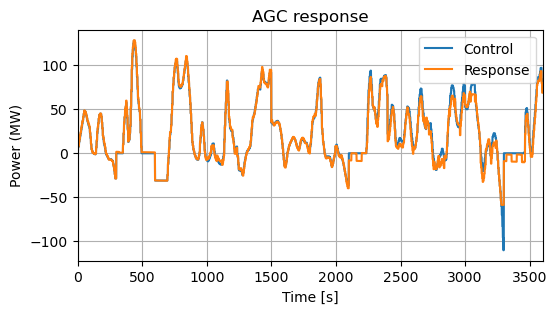

In [12]:
sse.plot_agc()

In [13]:
col = ['u', 'lc', 'c', 'c0', 'soc', 'soc0', 'socd', 'c', 'sx', 'agc', 'na0', 'na', 'nam']
sse.ev[(sse.ev['lc']==0)][col]

,u,lc,c,c0,soc,soc0,socd,c,sx,agc,na0,na,nam
0,1,0,0,1,0.871037,0.712835,0.772808,0,17,0,330,-229,3108
1,1,0,0,1,0.788055,0.658368,0.738327,0,15,0,132,129,2441
2,1,0,1,0,0.555971,0.367779,0.798253,1,11,0,0,123,2794
3,1,0,-1,2,0.935528,0.798007,0.812458,-1,18,1,588,240,3054
4,1,0,-1,2,0.995000,1.000000,0.806227,-1,19,1,3424,5396,2837
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17368,1,0,0,1,0.689132,0.423124,0.856442,0,13,1,0,456,3914
17369,1,0,1,0,0.417828,0.265367,0.778061,1,8,0,0,0,3175
17370,1,0,0,1,0.689316,0.517518,0.770784,0,13,1,0,752,3051
17371,1,0,-1,2,0.983040,0.891676,0.813977,-1,19,1,1487,2515,2895


/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_55772/3484866467.py:121: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{np.round(i*100,0)}\%' for i in np.arange(0, 1.1, 0.2)])


Total cost=300824.93


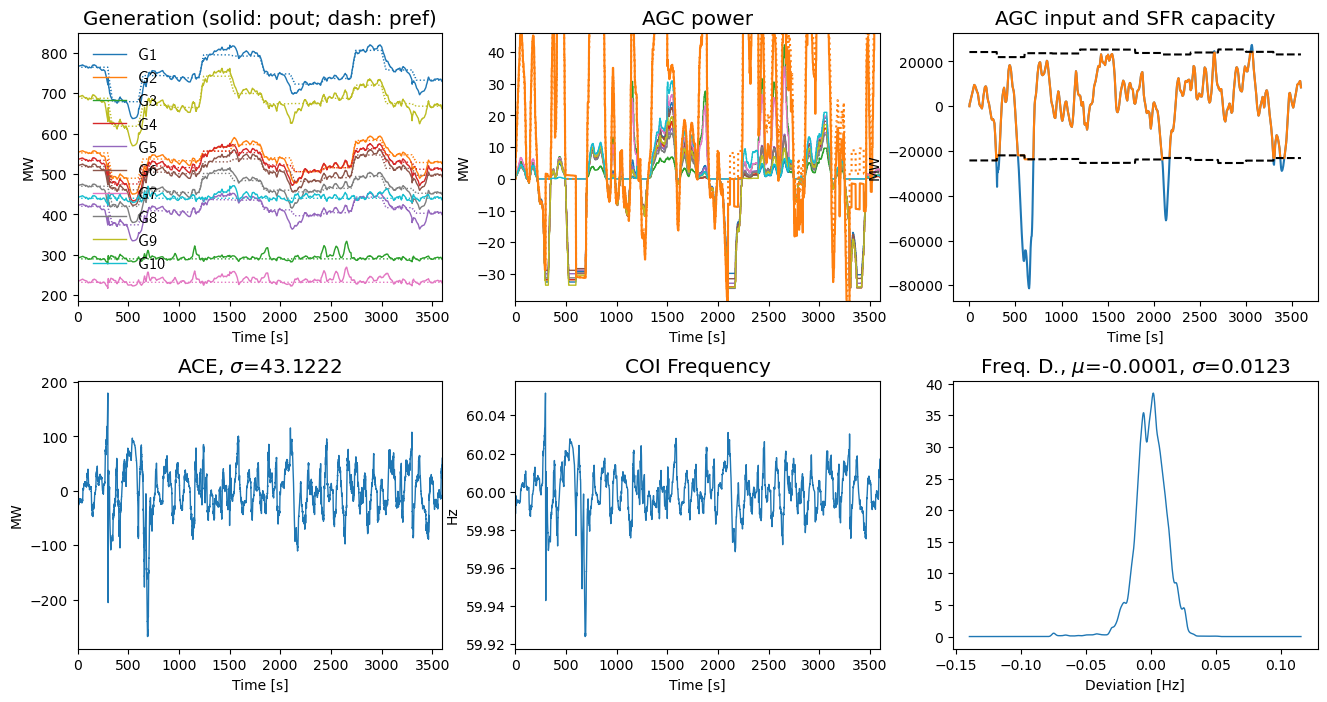

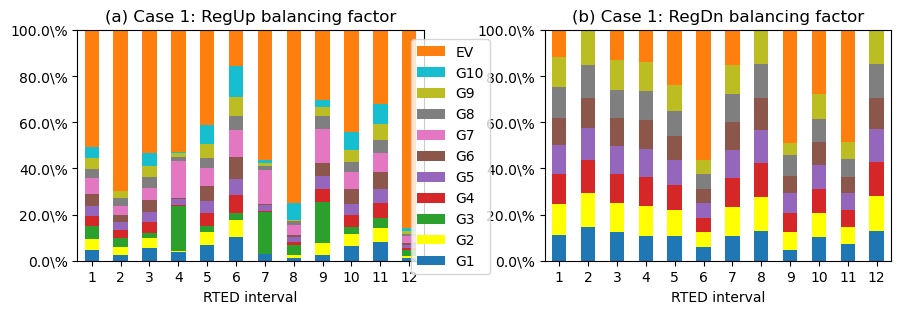

In [14]:
right = end_time

# data format conversion
ev_soc = pd.DataFrame(ev_soc_data.T, columns=range(t_total))
ev_agc = pd.DataFrame(ev_agc_data.T, columns=range(t_total))
sfr_res = pd.DataFrame(sfr_res_data, columns=['time', 'ace', 'up', 'dn', 'in'])
sfr_res['ace'] = sfr_res['ace'] * ssa.config.mva
sfr_res['up'] = sfr_res['up'] * ssa.config.mva
sfr_res['dn'] = sfr_res['dn'] * ssa.config.mva
sfr_res['in'] = sfr_res['in'] * ssa.config.mva

# data save
# Complement AGC table
agc_smooth = pd.DataFrame(np.repeat(agc_in[list(np.arange(0, t_total, 4))].values, 4, axis=1),
                          columns=list(np.arange(0, t_total, 1)))
# Record EV output
sse_out = sse.tsd.copy()

fig_gen, ax_gen = plt.subplots(2, 3, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.2, hspace=0.3)

yheader = [f'G{i}' for i in range(1, 11)]

ssa.TDS.plt.plot(ssa.TGOV1N.pout,
                 linestyles=['-'],
                 yheader=yheader, ytimes=ssa.config.mva,
                 legend=True, show=False, right=right,
                 title=r'Generation (solid: pout; dash: pref)',
                 ylabel='MW',
                 fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.pref, ytimes=ssa.config.mva,
                 legend=False, show=False, right=right,
                 linestyles=[':'],
                 fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.paux,
                 linestyles=['-'],
                 yheader=yheader, ytimes=ssa.config.mva,
                 legend=False, show=False, right=right,
                 title=r'AGC power', ylabel='MW',
                 fig=fig_gen, ax=ax_gen[0, 1])

# Plot EV AGC response, hard code
ax_gen[0, 1].plot(3600*(np.array(sse.tsd['ts'])-caseH), sse.tsd['Pr'], color='tab:orange', linestyle=':')
ax_gen[0, 1].plot(3600*(np.array(sse.tsd['ts'])-caseH), sse.tsd['Prc'], color='tab:orange', linestyle='-')
# ax_gen[0, 1].set_ylim(top=max(1.2 * max(sse.Prl), ax_gen[0, 1].get_ylim()))

ax_gen[0, 2].plot(sfr_res.time,
                  ssa.config.mva * sfr_res['ace'],
                  label='AGC raw')
ax_gen[0, 2].plot(sfr_res.time, 
                  ssa.config.mva * sfr_res['in'],
                  label='AGC input')
ax_gen[0, 2].plot(sfr_res.time,
                  ssa.config.mva * sfr_res['up'],
                  label='SFR capacity',
                  linestyle='--', color='k')
ax_gen[0, 2].plot(sfr_res.time, 
                  ssa.config.mva * sfr_res['dn'],
                  linestyle='--', color='k')
ax_gen[0, 2].set_ylabel('MW')
ax_gen[0, 2].set_xlabel('Time [s]')
ax_gen[0, 2].set_title('AGC input and SFR capacity')

aced = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1) * ssa.config.mva
ssa.TDS.plt.plot(ssa.ACEc.ace,
                 legend=False, show=False, right=right,
                 linestyles=['-'], ytimes=ssa.config.mva,
                 title=f'ACE, $\sigma$={aced.std().round(4)}', ylabel='MW',
                 fig=fig_gen, ax=ax_gen[1, 0])

ssa.TDS.plt.plot(ssa.COI.omega,
                 legend=False, show=False, right=right,
                 linestyles=['-'], ylabel='Hz',
                 ytimes=ssa.config.freq,
                 title=r'COI Frequency',
                 fig=fig_gen, ax=ax_gen[1, 1])

f_coi = pd.DataFrame()
f_coi['f'] = ssa.dae.ts.y[:, ssa.COI.omega.a].reshape(-1).copy() * ssa.config.freq - ssa.config.freq
f_coi.plot(kind='kde', legend=False, linewidth=1,
           fig=fig_gen, ax=ax_gen[1, 2],
           title=f'Freq. D., $\mu$={f_coi.f.mean().round(4)}, $\sigma$={f_coi.f.std().round(4)}')
ax_gen[1, 2].set(xlabel='Deviation [Hz]', ylabel='')

# --- plot bu, bd ---
# --- collect data ---
irry = np.array(-1 * np.ones((n_ed, ssd.gen.shape[0])))
bu = irry.copy()
bd = irry.copy()
pg = irry.copy()
for rted_idx in rted_res.keys():
    bu[rted_idx] = pd.DataFrame.from_dict(rted_res[rted_idx]).loc['bu'].values
    bd[rted_idx] = pd.DataFrame.from_dict(rted_res[rted_idx]).loc['bd'].values
    pg[rted_idx] = pd.DataFrame.from_dict(rted_res[rted_idx]).loc['pg'].values
col = pd.DataFrame.from_dict(rted_res[rted_idx]).loc['gen']
bu_df = pd.DataFrame(bu, columns=col)
bd_df = pd.DataFrame(bd, columns=col)
pg_df = pd.DataFrame(pg, columns=col)

import matplotlib.font_manager
plt.style.use('default')

color = ['tab:blue', 'yellow', 'tab:green',
         'tab:red', 'tab:purple', 'tab:brown',
         'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:orange']

figs, axes = plt.subplots(1, 2, figsize=(10.5, 3))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.35, hspace=None)
new_cols = ['PV_1', 'PV_2', 'PV_3', 'PV_4', 'PV_5', 'PV_6',
            'PV_7', 'PV_8', 'PV_9', 'Slack_10', 'PV_10']
bu_df[new_cols].plot.bar(stacked=True, ax=axes[0], legend=False, color=color)
bd_df[new_cols].plot.bar(stacked=True, ax=axes[1], legend=False, color=color)

for ax in axes:
    ax.tick_params(axis='x', labelrotation = 0)
    ax.set_ylim([0, 1])
    ax.set_yticklabels([f'{np.round(i*100,0)}\%' for i in np.arange(0, 1.1, 0.2)])
    ax.set_xticklabels([i for i in range(1,13,1)])
    ax.set_xlabel('RTED interval')
axes[0].set_title('(a) Case 1: RegUp balancing factor')
axes[1].set_title('(b) Case 1: RegDn balancing factor')
lines_labels = [ax.get_legend_handles_labels() for ax in axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
line_plot = lines[0:11]
line_plot.reverse()
label_g = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'EV']
label_g.reverse()
figs.legend(line_plot, label_g, loc='center')

# --- generation cost ---
gtc = 0
for i in pg_df.index:
    c = ssd.cost.c2.values * np.power(pg_df.loc[i].values, 2) \
        + ssd.cost.c1.values * pg_df.loc[i].values \
        + ssd.cost.c1.values
    gtc += np.sum(c)

agc_out.fillna(0, inplace=True)
agc_out_sort = pd.merge(left=agc_out.rename(columns={'stg_idx':'idx'}),
                        right=ssd.cost[['idx']], on='idx', how='right')
agc_mile = pd.DataFrame(columns=list(np.arange(intv_agc, t_total, intv_agc)))
for col_id in np.arange(intv_agc, t_total, intv_agc):
    agc_mile[col_id] = np.abs(agc_out_sort[col_id] - agc_out_sort[int(col_id-intv_agc)])
agc_mile[agc_mile.columns] *= 100

# --- SFR mileage cost ---
ftc = 0
for i in agc_mile.columns:
    c = ssd.cost.c1.abs().values * agc_mile[i].values
    ftc += np.sum(c)

print(f"Total cost={np.round(gtc+ftc, 2)}")

# --- save data ---
cosim_out = pd.DataFrame()
cosim_out['Time'] = ssa.dae.ts.t
# alter the sign of ACE
cosim_out['ACE'] = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1).copy() * ssa.config.mva * -1
cosim_out['freq'] = ssa.dae.ts.y[:, ssa.COI.omega.a].reshape(-1).copy() * ssa.config.freq
pout9 = ssa.dae.ts.y[:, ssa.TGOV1N.pout.a[2]].reshape(-1)
pref9 = ssa.dae.ts.y[:, ssa.TGOV1N.pref.a[2]].reshape(-1)
cosim_out['paux9'] = ssa.config.mva * (pout9-pref9)


In [15]:
# ssa.TDS.save_output()

/Users/jinningwang/Documents/work/andes/jwang/notes/cosim_plot.py:122: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{np.round(i*100,0)}%' for i in np.arange(0, 1.1, 0.2)])


Total cost=300824.93


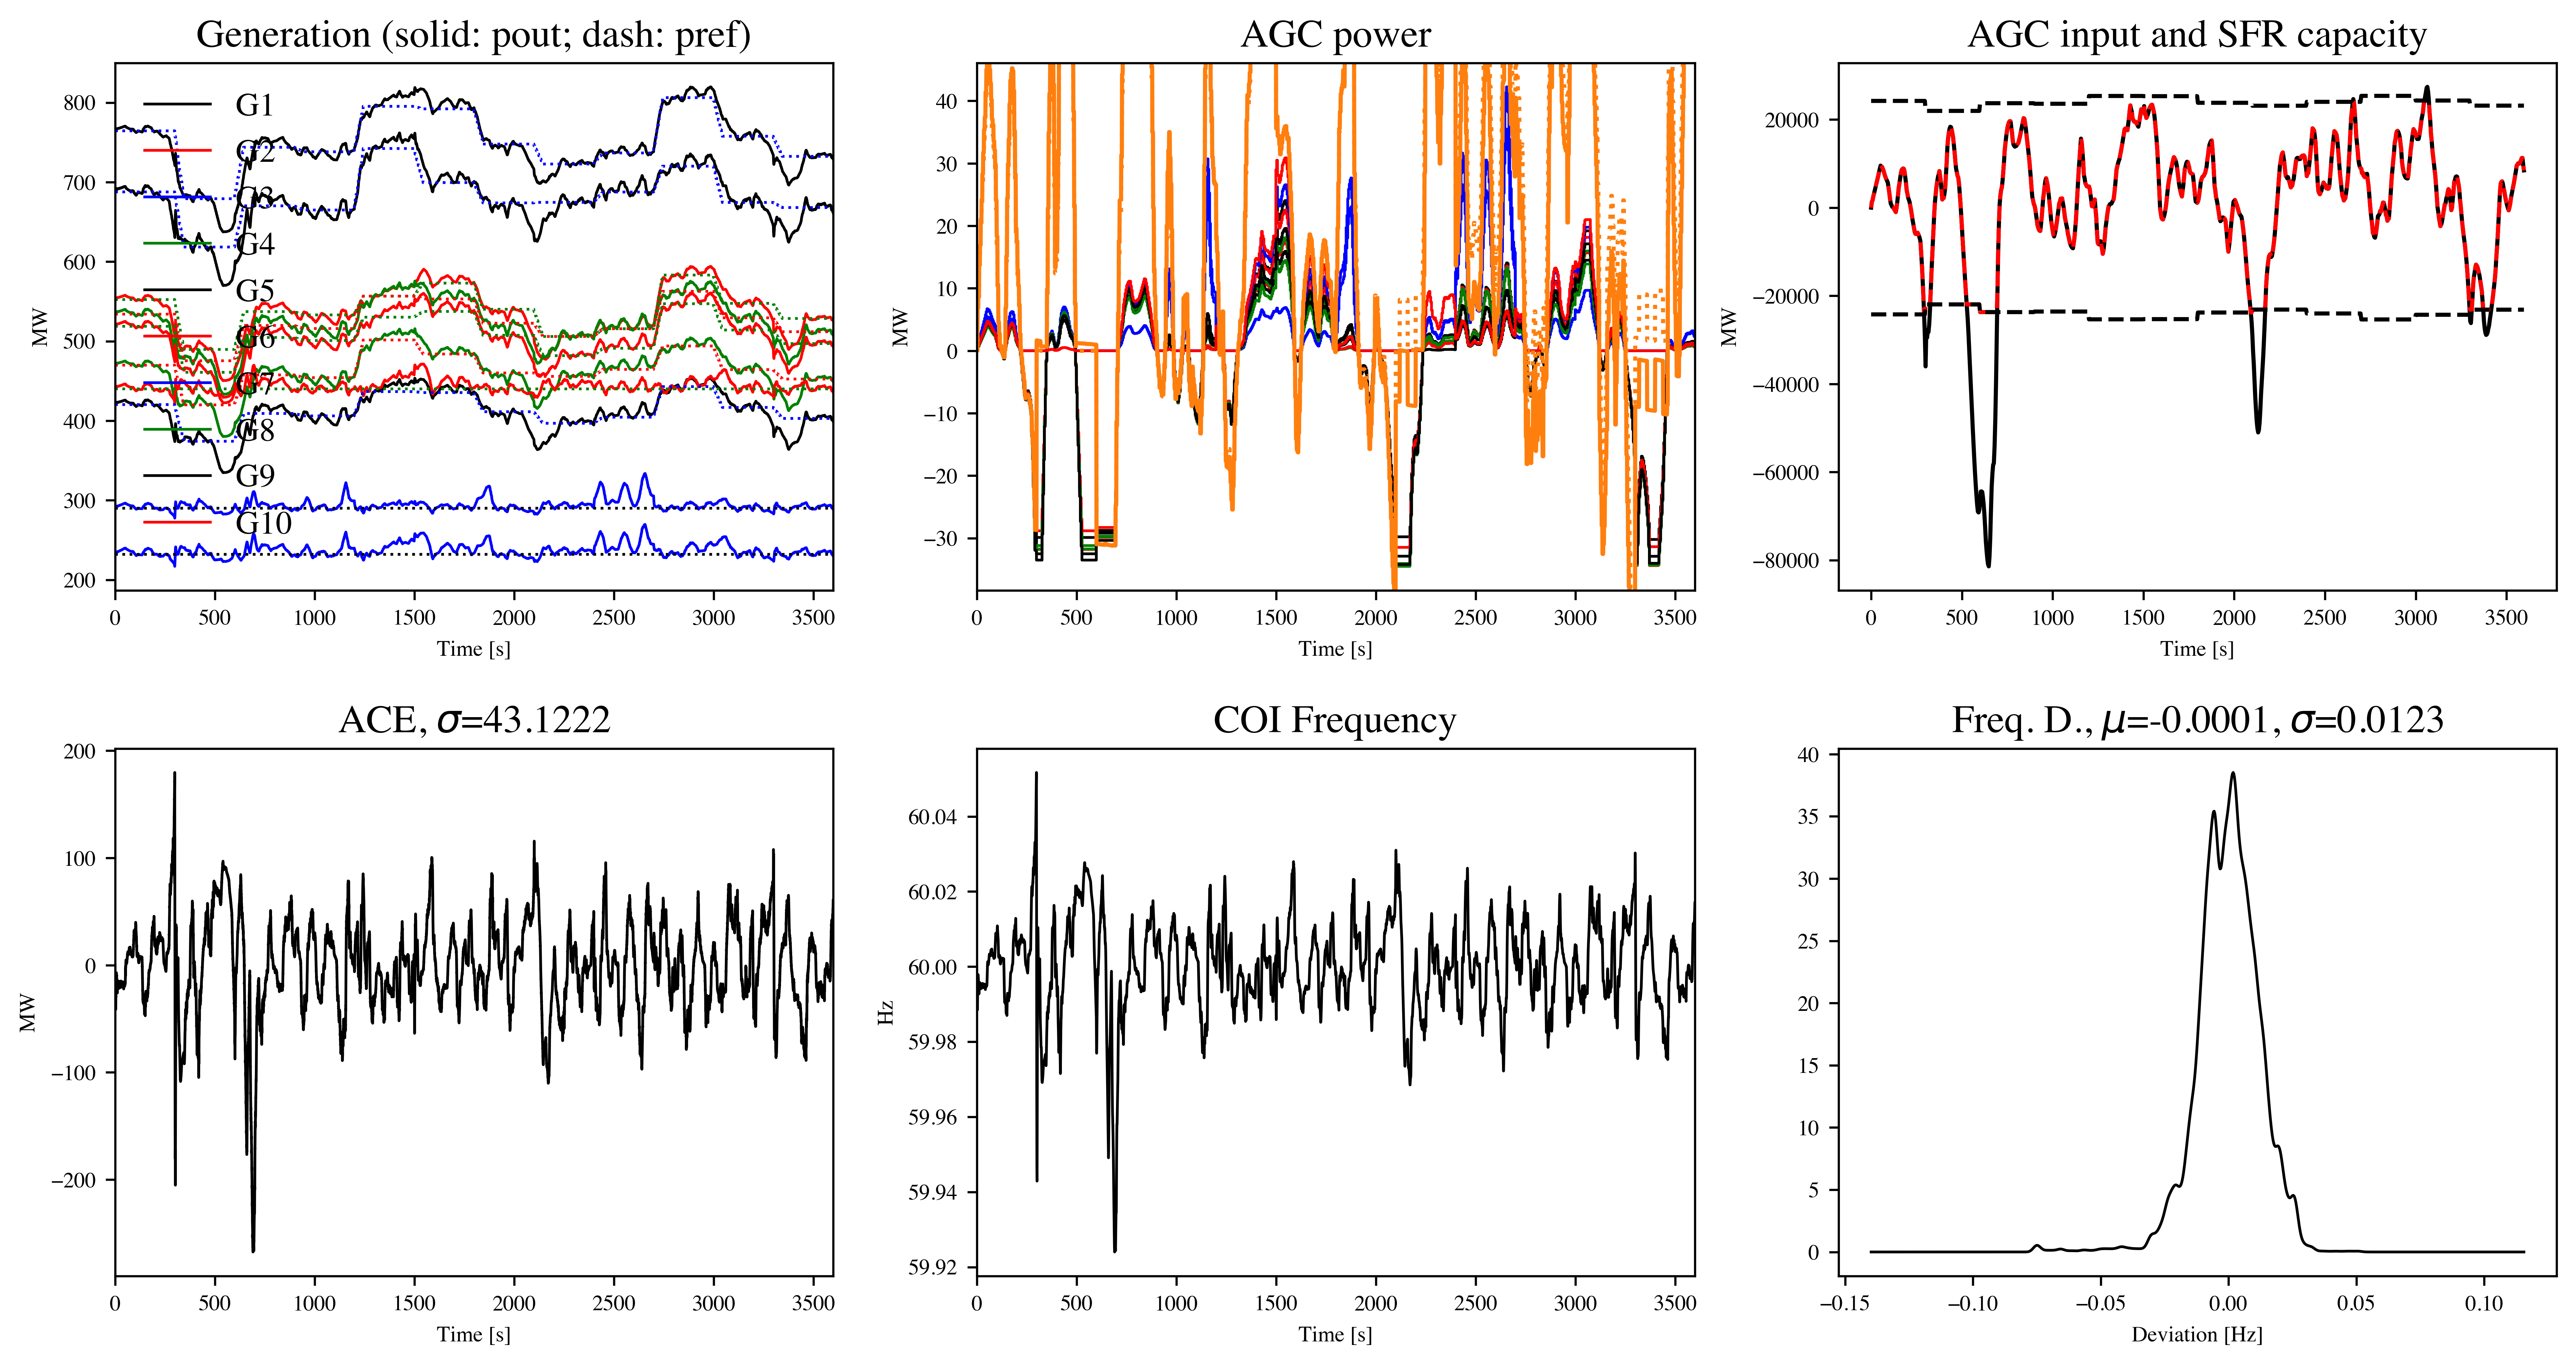

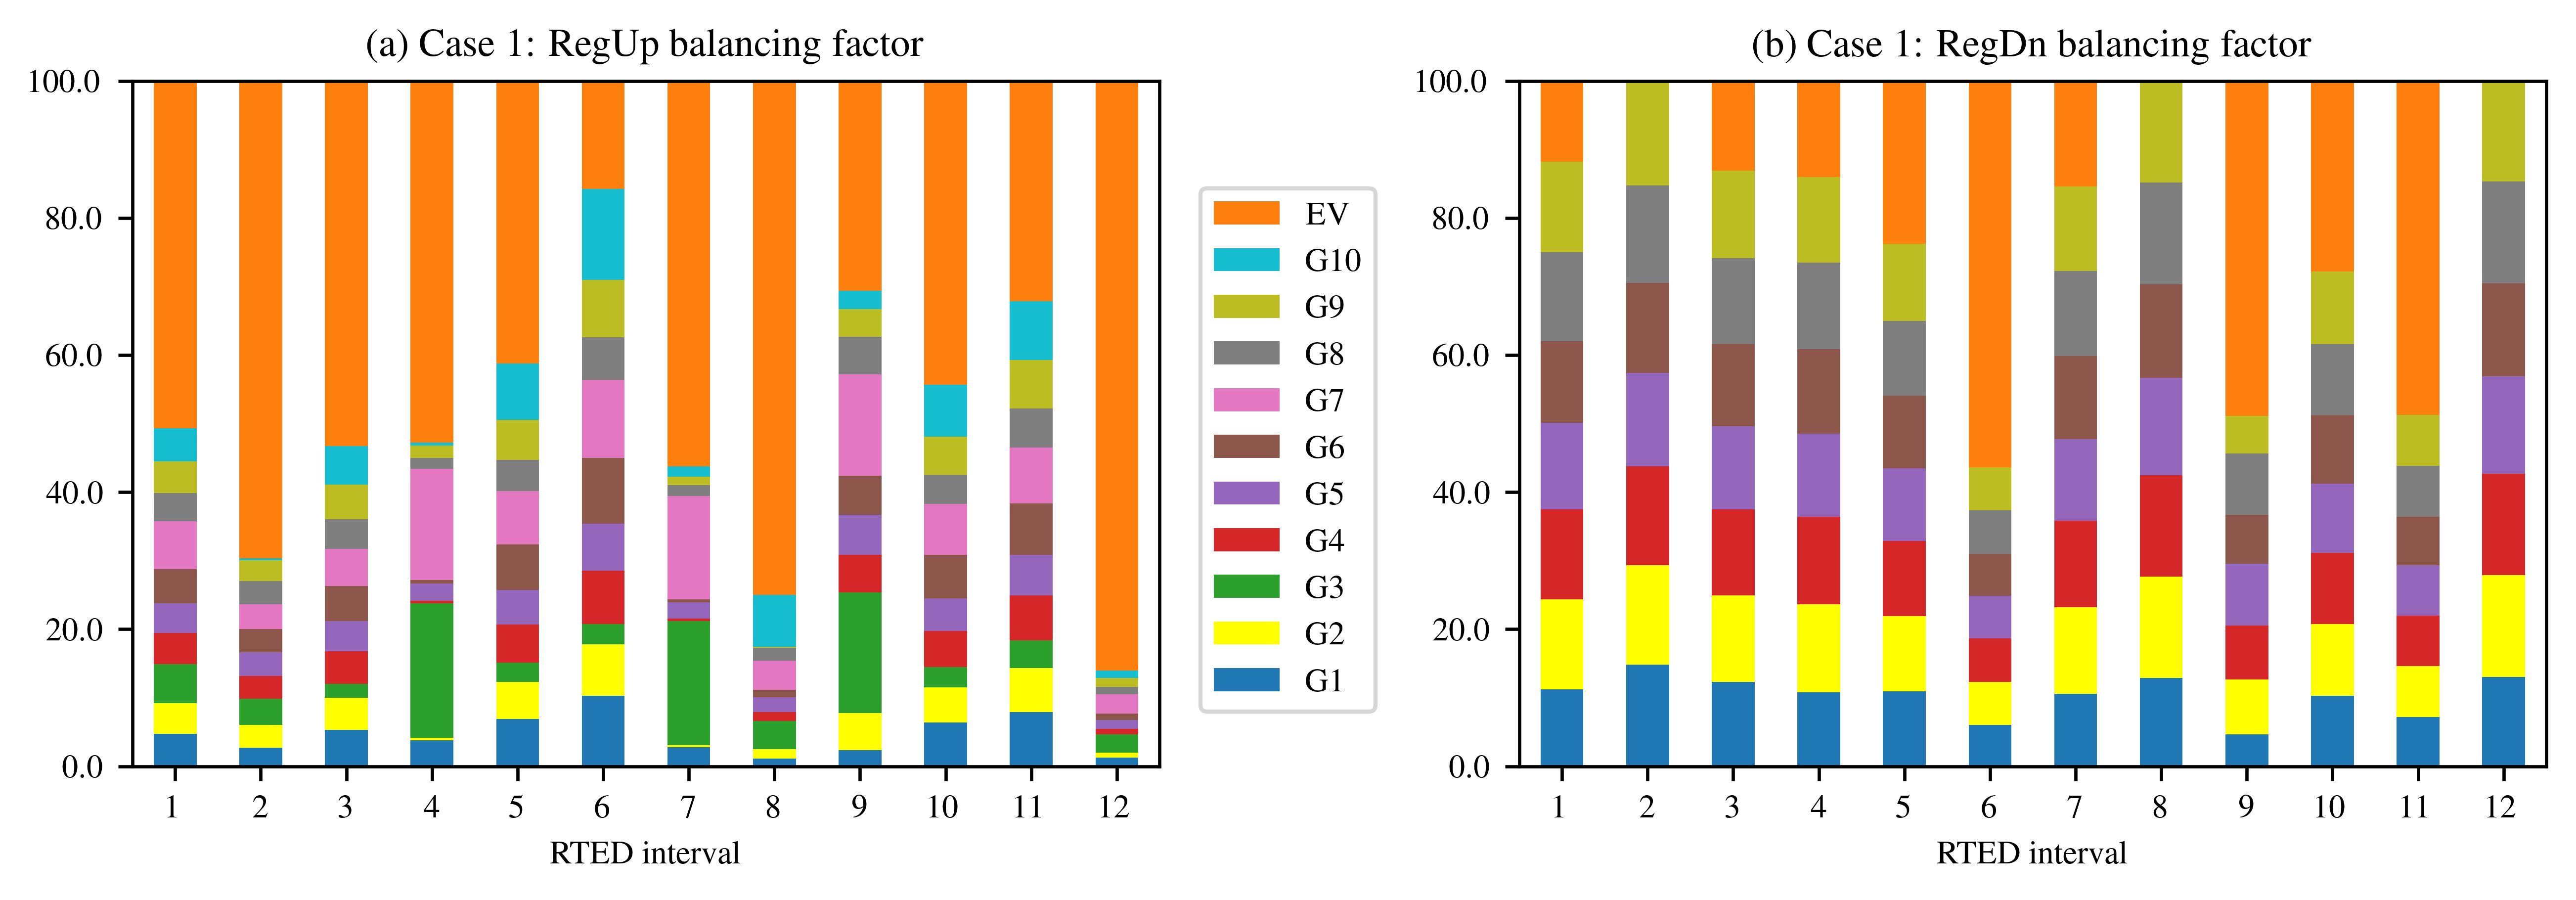

In [16]:
%run -i 'cosim_plot.py'

In [17]:
# plot the AGC signal

# figa, axa = plt.subplots()
# axa.plot(range(0, 3600, 4),
#          ssa.config.mva * agc_out.values[10:, 1:].reshape(900, 1),
#          color='tab:orange')
# axa.plot(range(0, 3600, 4),
#          ssa.config.mva * agc_in.values[10:, 1:].reshape(900, 1),
#          color='tab:red')
# ssa.TDS.plt.plot(ssa.TGOV1N.paux,
#                  linestyles=['-'],
#                  yheader=yheader,
#                  ytimes=ssa.config.mva,
#                  legend=False, show=False,
#                  title=r'AGC power', ylabel='MW',
#                  fig=figa, ax=axa, style='default',
#                  left=1000, right=2000)
# axa.legend(['AGC_out-EV', 'AGC_in-EV'])

In [20]:
sim_name = '_F'
cosim_out.to_csv('cosim_18' + sim_name + '_out.csv', index=False)
sse_out.to_csv('cosim_18' + sim_name + '_sse.csv', index=False)
bu_df.to_csv('cosim_18' + sim_name + '_bu.csv', index=False)
bd_df.to_csv('cosim_18' + sim_name + '_bd.csv', index=False)
pg_df.to_csv('cosim_18' + sim_name + '_pg.csv', index=False)
agc_mile.to_csv('cosim_18' + sim_name + '_agcm.csv', index=False)
sfr_res.to_csv('cosim_18' + sim_name + '_sfr.csv', index=False)
ev_agc.to_csv('cosim_18' + sim_name + '_evagc.csv', index=False)
ev_soc.iloc[0:800].to_csv('cosim_18' + sim_name + '_evsoc1.csv', index=False)
ev_soc.iloc[800:].to_csv('cosim_18' + sim_name + '_evsoc2.csv', index=False)
sse.ev.to_csv('cosim_18' + sim_name + '_evdata.csv', index=False)

import csv
new_path = open('cosim_18' + sim_name + '_rted.csv', 'w')
z = csv.writer(new_path)
for new_k, new_v in rted_res.items():
    z.writerow([new_k, new_v])
new_path.close()

In [19]:
# split -l 4 index.txt split_file
# !ls -lh

plt.style.use('science')
%run -i 'cosim_plotev.py'